In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import pandas as pd

import statistics
from tqdm import tqdm
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Dataset
# from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader

import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import sklearn
from math import sqrt
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_x = pd.read_csv(r'../PreparedData/X/Divided_2016.csv')

In [4]:
df_x.columns

Index(['Unnamed: 0', 'FeatureTyp', 'SegmentTyp', 'TrafDir', 'SegmentID',
       'XFrom', 'YFrom', 'XTo', 'YTo', 'StreetWidt', 'SegmentID_',
       'SpatialJoi', 'D_Busstop', 'D_Subway', 'Length', 'NodeIDFrom',
       'NodeIDTo', 'X', 'Y', 'SVIID', 'Commercial', 'CulturalFa', 'EducationF',
       'Government', 'HealthServ', 'Miscellane', 'PublicSafe', 'Recreation',
       'ReligiousI', 'Residentia', 'SocialServ', 'Transporta', 'Water',
       'Avg_Area_1', 'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3',
       'Avg_B02001', 'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1',
       'Avg_B080_2', 'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001',
       'Avg_B19013', 'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2',
       'Avg_B240_3', 'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7',
       'Avg_B240_8', 'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12',
       'Avg_B24_13', 'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17',
       'Avg_B24_18', '

In [5]:
columns = ['SVIID',
           'StreetWidt', 'Length',  
           'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
           'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
           'SocialServ', 'Transporta', 'Water',
           'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
           'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
           'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
           'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
           'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
           'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
           'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
           'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']

In [6]:
df_x = df_x[columns]

In [7]:
svi_df = pd.read_csv(r'../PreparedData/X/scene.csv').drop(columns=['Unnamed: 0']).values

In [8]:
svi_df.shape

(23149, 365)

In [9]:
class NYCTrafficCountDataset(Dataset):
    def __init__(self, path):
        super(NYCTrafficCountDataset, self).__init__(None)
        self.path = path
        self.time_list = os.listdir(self.path) 

        self.x_folder = r'../PreparedData/X/'

        edge_path = r'../PreparedData/adjacentMatrix.csv'
        
        self.column_list = ['SVIID',
                            'StreetWidt', 'Length',  
                            'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
                            'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
                            'SocialServ', 'Transporta', 'Water',
                            'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
                            'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
                            'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
                            'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
                            'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
                            'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
                            'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
                            'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']

        edge_df = pd.read_csv(edge_path)

        self.From = edge_df['From'].values
        self.To = edge_df['To'].values
        self.svi_x = pd.read_csv(r'../PreparedData/X/scene.csv').drop(columns=['Unnamed: 0']).values
        
    def len(self):
        return len(self.time_list)
    @property
    def raw_file_names(self):
        return []
#     def processed_file_names(self):
#         return ['files']
#     def download(self):
#         return 0.5
#     def indices


    
    def get(self, idx):
        
        time = self.time_list[idx]
        year = time.split('_')[0]
        
        x_name = 'Divided_' + year + '.csv'
        x_path = os.path.join(self.x_folder, x_name)
#         print(x_path)
        x_df = pd.read_csv(x_path)
        x_df = x_df[self.column_list]
        
#         x_df = (x_df - x_df.min())/(x_df.max() - x_df.min())
#         x_df['SVIID'] = sviid
        self.x = x_df.values
        self.x = np.append(self.x, self.svi_x, 1)
        
        
        
        time_path = os.path.join(self.path, time)
        df_time_series = pd.read_csv(time_path).drop('Unnamed: 0', axis=1)
        mask = df_time_series['0']!= -1
        df_time_series[mask] = df_time_series[mask] * 156.377030788485 + 106.66053597731798
        df_time_series[mask] = (df_time_series[mask] - 139) / 150
        df_time_series = df_time_series.values
        
#         x_extend_start = random.choice(range(20, 70))
        x_extend_start = 20
        
        x_extend_length = 20
        y_extend_length = 56
        
        x_extend = df_time_series[:, x_extend_start: x_extend_start + x_extend_length]
        y = df_time_series[:, x_extend_start + x_extend_length : x_extend_start + x_extend_length + y_extend_length]
#         y = np.sum(y, axis=1)
        x_raw = self.x.copy()
        x_new = np.append(x_raw, x_extend, 1)
        
        g_y = torch.tensor(y, dtype=torch.float)
        g_x = torch.tensor(x_new, dtype=torch.float)
        edge_index = torch.tensor([self.From, self.To], dtype=torch.long)
        data = Data(x=g_x, edge_index=edge_index, y=g_y)
        
        return data
        

In [10]:
train_dataset = NYCTrafficCountDataset(r'../PreparedData/Y_time/good/Weekday/Train/')
# train_dataset = train_dataset.shuffle()
val_dataset = NYCTrafficCountDataset(r'../PreparedData/Y_time/good/Weekday/Val/')
# val_dataset = val_dataset.shuffle()
test_dataset = NYCTrafficCountDataset(r'../PreparedData/Y_time/good/Weekday/Test/')

In [11]:
training_dataloader = DataLoader(train_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 num_workers=5)
validation_dataloader = DataLoader(val_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 num_workers=5)
test_dataloader = DataLoader(test_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 num_workers=5)

In [12]:
train_dataset[0].x[1000][0:55]

tensor([7.5600e+02, 3.0000e+01, 7.2245e-02, 1.0000e+00, 9.0000e+00, 6.0000e+00,
        2.0000e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 6.0000e+00, 6.0000e+00,
        3.4000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3562e+04, 6.8410e+03,
        6.7211e+03, 3.8144e+03, 8.9410e+03, 1.0535e+03, 2.3517e+02, 6.6129e+03,
        2.4152e+03, 4.7739e+02, 3.1878e+05, 0.0000e+00, 2.9655e+03, 6.4059e+03,
        2.2624e+05, 1.0347e+02, 2.4739e+05, 2.0994e+05, 1.5434e+04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.7344e+05, 1.5139e+05, 1.5137e+05, 1.9729e+05,
        0.0000e+00, 8.2527e+04, 0.0000e+00, 2.6032e+05, 0.0000e+00, 0.0000e+00,
        3.1136e+04, 1.4587e+05, 1.3522e+05, 1.5010e+05, 0.0000e+00, 1.2417e+05,
        0.0000e+00])

In [17]:
train_dataset[0].x[:, 421:].shape

torch.Size([23149, 20])

In [18]:
train_dataset[0].x[:, 421:].reshape((1, train_dataset[0].x.shape[0], 20)).shape

torch.Size([1, 23149, 20])

In [13]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.num_layers = 1
        
# #         street view images features extraction
#         self.svi1 = nn.Linear(256 * 64 * 64, 256)
#         self.svi2 = nn.Linear(256, 128)
#         self.svi3 = nn.Linear(128, 128)
        
# #         remote sensing images features extraction
#         self.rm1 = nn.Linear(256 * 64 * 64, 256)
#         self.rm2 = nn.Linear(256, 128)
#         self.rm3 = nn.Linear(128, 128)
        
#         road segment features extraction
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        self.sep3_2 = nn.Linear(365, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        self.sep7 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(384-128, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

        self.lstm1 = nn.LSTM(20, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(128, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 64)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(64, 56)
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
        x_road = x_all[:, 1:3]
        x_location = x_all[:,3:16]
        x_se = x_all[:, 16:56]
        x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

        x_road = self.sep1(x_road)
        x_road = F.sigmoid(x_road)
        x_road = self.sep4(x_road)
        x_road = F.relu(x_road)
        
        x_location = self.sep2(x_location)
        x_location = F.sigmoid(x_location)
        x_location = self.sep5(x_location)
        x_location = F.relu(x_location)
        
        x_se = self.sep3(x_se)
        x_se = F.sigmoid(x_se)
        x_se = self.sep6(x_se)
        x_se = F.relu(x_se)
        
#         **************SVI********************************
#         x_svi = self.sep3_2(x_svi)
#         x_svi = F.relu(x_svi)
#         x_svi = self.sep7(x_svi)
#         x_svi = F.relu(x_svi)
        
#         x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
        x = torch.cat((x_road, x_location, x_se), 1)
    
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

        _, (hn, _) = self.lstm1(t, (h0, c0))

        t = hn[0]
        x = torch.cat((x, t), 1)
        
        x = self.linear1(x)
        x = F.relu(x)
#         x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return x

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# model = Net().to(device)

learning_rate = 0.001
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
# loss_function = MAPE()
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [17]:
def MAPE(pred, real):
    pred = pred * 150 + 139
    real = real * 150 + 139
    mask_2 = (real!= 0)
    real = real[mask_2]
    pred = pred[mask_2]
    return torch.mean(torch.abs((pred - real)/(real)))

In [ ]:
# model = Net().to(device)
# model.load_state_dict(torch.load(r'../Weights/best.pt'))
epoch = 300


train_loss_list = []
val_loss_list = []

train_loss_percentage_list = []
val_loss_percentage_list = []


for i in range(epoch):
    
    print('------------' + str(i) + '-------------')
    train_loss = []
    validation_loss = []
    train_loss_percentage = []
    validation_loss_percentage = []
    best = 100000000
    best_path = r'../Weights_nosvi/best.pt'
    
    
    
    for batch in tqdm(training_dataloader):

        optimizer.zero_grad()
        batch.to(device)
        out = model(batch)
#         print(out)

#         l = loss_function(out, batch.y[10:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]
    
    
        l = MAPE(out[mask_1], real)
#         print(l)
        l.backward()
        optimizer.step()

        train_loss.append(l.tolist())
#         train_loss_percentage.append(l.tolist()/(batch.y[train_mask].mean().tolist()+0.000001)) 

    
    with torch.no_grad():
        for batch in validation_dataloader:
            batch.to(device)
            out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
            mask_1 = batch.y[:, 0] != -1
            real = batch.y[mask_1]
    
    
            loss_val = MAPE(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)
    
            
            validation_loss.append(loss_val.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
                
    train_loss = np.array(train_loss)
#     train_loss_percentage = np.array(train_loss_percentage)

    train_loss = train_loss[~pd.isnull(train_loss)].tolist()
#     train_loss_percentage = train_loss_percentage[~pd.isnull(train_loss_percentage)].tolist()
    
    

    validation_loss = np.array(validation_loss)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_train_loss = sum(train_loss)/len(train_loss)
    average_val_loss = sum(validation_loss)/len(validation_loss)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)
#     average_val_loss_percentage = sum(validation_loss_percentage)/len(validation_loss_percentage)
    
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)
#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('Trainning loss is: ' + str(average_train_loss) + '    , validation loss is: ' + str(average_val_loss))
#     print('Trainning loss p is: ' + str(average_train_loss_percentage) + '    , validation p loss is: ' + str(average_val_loss_percentage))

    
    if average_val_loss < best:
        best = average_val_loss
        torch.save(model.state_dict(), best_path)
    if i%5 == 0:
        epoch_path = os.path.join(r'../Weights_nosvi/', str(i) + '_3.pt')
        torch.save(model.state_dict(), epoch_path)

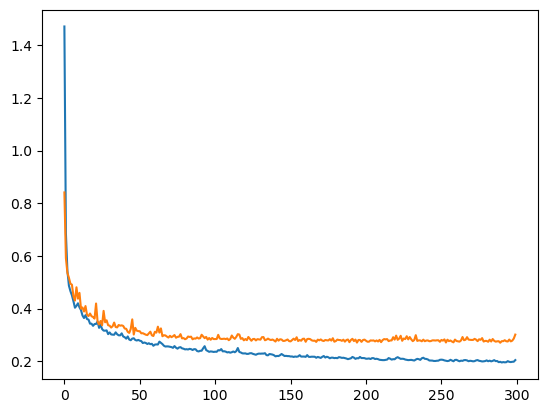

In [231]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

In [232]:
loss = {'training': train_loss_list, 'val':val_loss_list}

In [233]:
loss = pd.DataFrame(loss)

In [240]:
loss.to_csv(r'../Weights_nosvi/loss.csv')

#### Test without street view images

In [18]:
model = Net1().to(device)
model.load_state_dict(torch.load(r'../Weights_nosvi/best.pt'))
model.eval()

Net1(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(256, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56

In [19]:
validation_loss = []
rmse_all = []
with torch.no_grad():
    for batch in test_dataloader:
        batch.to(device)
        out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]


        loss_val = MAPE(out_val[mask_1], real)
        rmse = loss_function(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)


        validation_loss.append(loss_val.tolist())
        rmse_all.append(rmse.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
    
    

    validation_loss = np.array(validation_loss)
    rmse_all = np.array(rmse_all)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
    rmse_all = rmse_all[~pd.isnull(rmse_all)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_val_loss = sum(validation_loss)/len(validation_loss)
    average_rmse_loss = sum(rmse_all)/len(rmse_all)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)

#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('mape: ' + str(average_val_loss) + ', rmse: ' + str(average_rmse_loss * 150))
#     print('Trainning loss p is: ' + str(average_train_lo

mape: 0.22570025282246725, rmse: 26.345583663455077


#### All in: test: 0.239
#### no svi: test: 0.274

In [20]:
# i = 111
# a = out_val[mask_1][i]* 150 + 139
# b = batch.y[mask_1][i]* 150 + 139
# plt.plot(a.cpu().detach().numpy())
# plt.plot(b.cpu().detach().numpy())

#### Test with street view images

#### Train all in

In [21]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        self.num_layers = 1
        
# #         street view images features extraction
#         self.svi1 = nn.Linear(256 * 64 * 64, 256)
#         self.svi2 = nn.Linear(256, 128)
#         self.svi3 = nn.Linear(128, 128)
        
# #         remote sensing images features extraction
#         self.rm1 = nn.Linear(256 * 64 * 64, 256)
#         self.rm2 = nn.Linear(256, 128)
#         self.rm3 = nn.Linear(128, 128)
        
#         road segment features extraction
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        self.sep3_2 = nn.Linear(365, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        self.sep7 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(384, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

        self.lstm1 = nn.LSTM(20, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(128, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 64)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(64, 56)
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
        x_road = x_all[:, 1:3]
        x_location = x_all[:,3:16]
        x_se = x_all[:, 16:56]
        x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

        x_road = self.sep1(x_road)
        x_road = F.sigmoid(x_road)
        x_road = self.sep4(x_road)
        x_road = F.relu(x_road)
        
        x_location = self.sep2(x_location)
        x_location = F.sigmoid(x_location)
        x_location = self.sep5(x_location)
        x_location = F.relu(x_location)
        
        x_se = self.sep3(x_se)
        x_se = F.sigmoid(x_se)
        x_se = self.sep6(x_se)
        x_se = F.relu(x_se)
        
#         **************SVI********************************
        x_svi = self.sep3_2(x_svi)
        x_svi = F.relu(x_svi)
        x_svi = self.sep7(x_svi)
        x_svi = F.relu(x_svi)
        
        x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
#         x = torch.cat((x_road, x_location, x_se), 1)
    
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

        _, (hn, _) = self.lstm1(t, (h0, c0))

        t = hn[0]
        x = torch.cat((x, t), 1)
        
        x = self.linear1(x)
        x = F.relu(x)
#         x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return x

In [192]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = Net2().to(device)

learning_rate = 0.001
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
# loss_function = MAPE()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [193]:
# model = Net().to(device)
# model.load_state_dict(torch.load(r'../Weights/best.pt'))
epoch = 300


train_loss_list = []
val_loss_list = []

train_loss_percentage_list = []
val_loss_percentage_list = []


for i in range(epoch):
    
    print('------------' + str(i) + '-------------')
    train_loss = []
    validation_loss = []
    train_loss_percentage = []
    validation_loss_percentage = []
    best = 100000000
    best_path = r'../Weights_all/best.pt'
    
    
    
    for batch in tqdm(training_dataloader):

        optimizer.zero_grad()
        batch.to(device)
        out = model(batch)
#         print(out)

#         l = loss_function(out, batch.y[10:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]
    
    
        l = MAPE(out[mask_1], real)
#         print(l)
        l.backward()
        optimizer.step()

        train_loss.append(l.tolist())
#         train_loss_percentage.append(l.tolist()/(batch.y[train_mask].mean().tolist()+0.000001)) 

    
    with torch.no_grad():
        for batch in validation_dataloader:
            batch.to(device)
            out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
            mask_1 = batch.y[:, 0] != -1
            real = batch.y[mask_1]
    
    
            loss_val = MAPE(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)
    
            
            validation_loss.append(loss_val.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
                
    train_loss = np.array(train_loss)
#     train_loss_percentage = np.array(train_loss_percentage)

    train_loss = train_loss[~pd.isnull(train_loss)].tolist()
#     train_loss_percentage = train_loss_percentage[~pd.isnull(train_loss_percentage)].tolist()
    
    

    validation_loss = np.array(validation_loss)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_train_loss = sum(train_loss)/len(train_loss)
    average_val_loss = sum(validation_loss)/len(validation_loss)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)
#     average_val_loss_percentage = sum(validation_loss_percentage)/len(validation_loss_percentage)
    
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)
#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('Trainning loss is: ' + str(average_train_loss) + '    , validation loss is: ' + str(average_val_loss))
#     print('Trainning loss p is: ' + str(average_train_loss_percentage) + '    , validation p loss is: ' + str(average_val_loss_percentage))

    
    if average_val_loss < best:
        best = average_val_loss
        torch.save(model.state_dict(), best_path)
    if i%5 == 0:
        epoch_path = os.path.join(r'../Weights_all/', str(i) + '_3.pt')
        torch.save(model.state_dict(), epoch_path)

------------0-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.74it/s]


Trainning loss is: 1.4739643335342407    , validation loss is: 0.8752148316966163
------------1-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.7148460071337851    , validation loss is: 0.5830525176392661
------------2-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.5483873361035397    , validation loss is: 0.5792528490225474
------------3-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.06it/s]


Trainning loss is: 0.4978066792613582    , validation loss is: 0.49367672039402855
------------4-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.08it/s]


Trainning loss is: 0.44835668645407023    , validation loss is: 0.4518648750252194
------------5-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.424340421431943    , validation loss is: 0.4473215523693297
------------6-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.43294659021653625    , validation loss is: 0.47857728434933555
------------7-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.4164385544626336    , validation loss is: 0.4325373735692766
------------8-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.4015046420850252    , validation loss is: 0.4202082720067766
------------9-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.39299601316452026    , validation loss is: 0.4125919822189543
------------10-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.4029228342206855    , validation loss is: 0.4473179148303138
------------11-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.38818918874389247    , validation loss is: 0.40070950074328315
------------12-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.36254907673911047    , validation loss is: 0.37713053491380477
------------13-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.35196999460458755    , validation loss is: 0.3792453250951237
------------14-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.346665548650842    , validation loss is: 0.35373519112666446
------------15-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.34341384274394887    , validation loss is: 0.3707704957988527
------------16-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.34806869688786957    , validation loss is: 0.46706272330549026
------------17-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.34890449988214595    , validation loss is: 0.36982307334740955
------------18-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.3251864698372389    , validation loss is: 0.3735797256231308
------------19-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.3250823613060148    , validation loss is: 0.36605830076668
------------20-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.3259181595946613    , validation loss is: 0.32750294274753994
------------21-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.3141746838626109    , validation loss is: 0.3388955932524469
------------22-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.3238223442121556    , validation loss is: 0.34532942954036927
------------23-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.320077572213976    , validation loss is: 0.3379226409726673
------------24-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.31206931526723664    , validation loss is: 0.3297697744435734
------------25-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.3119918900100808    , validation loss is: 0.35974323749542236
------------26-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.30993498548081044    , validation loss is: 0.3362649629513423
------------27-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.3078538257824747    , validation loss is: 0.3508665967318747
------------28-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.30093131528088923    , validation loss is: 0.3179004498653942
------------29-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.29504668987111043    , validation loss is: 0.3211316391825676
------------30-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2932067599735762    , validation loss is: 0.32975589897897506
------------31-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2981517561956456    , validation loss is: 0.3297504608829816
------------32-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.29321563557574626    , validation loss is: 0.31879116346438724
------------33-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.29068749162711593    , validation loss is: 0.31251183566119933
------------34-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2837746770758378    , validation loss is: 0.32685594840182197
------------35-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2898161842634803    , validation loss is: 0.3403572092453639
------------36-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.30216723994204875    , validation loss is: 0.35853126479519737
------------37-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2927569695993474    , validation loss is: 0.3145841128296322
------------38-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.285924080563219    , validation loss is: 0.3110580262210634
------------39-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.27929561820469406    , validation loss is: 0.311101705663734
------------40-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2762376626855449    , validation loss is: 0.30112802899546093
------------41-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2814600024568407    , validation loss is: 0.33715476675166023
------------42-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.2814812511205673    , validation loss is: 0.32690729863113827
------------43-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2807985320687294    , validation loss is: 0.31335033145215774
------------44-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.28054583425584595    , validation loss is: 0.30074506998062134
------------45-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2758402832244572    , validation loss is: 0.3019692740506596
------------46-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.27431993304114594    , validation loss is: 0.30159395270877415
------------47-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.27503517387728943    , validation loss is: 0.3163794270820088
------------48-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2718386375590375    , validation loss is: 0.3096047027243508
------------49-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.2722122810388866    , validation loss is: 0.29973048385646606
------------50-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.01it/s]


Trainning loss is: 0.2816399653491221    , validation loss is: 0.3075387469596333
------------51-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.14it/s]


Trainning loss is: 0.2685879868896384    , validation loss is: 0.2927689461244477
------------52-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.27164331588305923    , validation loss is: 0.3105541219313939
------------53-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2660082166916446    , validation loss is: 0.2971676290035248
------------54-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.99it/s]


Trainning loss is: 0.26789799763968114    , validation loss is: 0.2981705748372608
------------55-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.92it/s]


Trainning loss is: 0.2643400634589948    , validation loss is: 0.28685059067275787
------------56-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.04it/s]


Trainning loss is: 0.2610028033193789    , validation loss is: 0.300838612847858
------------57-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.26073352639612396    , validation loss is: 0.29222609682215583
------------58-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.25740772721014527    , validation loss is: 0.2912379081050555
------------59-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2563286294278346    , validation loss is: 0.288565000726117
------------60-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2536603702526343    , validation loss is: 0.28664244214693707
------------61-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.25693245388959585    , validation loss is: 0.28701230386892956
------------62-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.26it/s]


Trainning loss is: 0.25462937394255086    , validation loss is: 0.2870364139477412
------------63-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.25618617001332733    , validation loss is: 0.28477810737159515
------------64-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.25527221905557734    , validation loss is: 0.29066257344351876
------------65-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.25835150793979045    , validation loss is: 0.29101716313097215
------------66-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.22it/s]


Trainning loss is: 0.2562432359707983    , validation loss is: 0.2960470774107509
------------67-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.26177558146025004    , validation loss is: 0.31710126913256115
------------68-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.25it/s]


Trainning loss is: 0.26274702501924413    , validation loss is: 0.29689517203304505
------------69-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.08it/s]


Trainning loss is: 0.2541173351438422    , validation loss is: 0.28563403007056976
------------70-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.24842469394207    , validation loss is: 0.2801336795091629
------------71-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.2482551838222303    , validation loss is: 0.2988235081235568
------------72-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.24890984516394765    , validation loss is: 0.2899578917357657
------------73-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.251156000714553    , validation loss is: 0.28399283273352516
------------74-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.29it/s]


Trainning loss is: 0.2486515707875553    , validation loss is: 0.28141918198929894
------------75-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.24561936016145505    , validation loss is: 0.28666313654846615
------------76-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.24498550201717176    , validation loss is: 0.2869575520356496
------------77-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.24467036873102188    , validation loss is: 0.28814443531963563
------------78-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.24524309564577906    , validation loss is: 0.29107333057456547
------------79-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.24238650579201548    , validation loss is: 0.28379325154754853
------------80-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.23938201250214325    , validation loss is: 0.28400929934448665
------------81-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.23879049679166392    , validation loss is: 0.2836914410193761
------------82-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.2381998896598816    , validation loss is: 0.29923416756921345
------------83-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.11it/s]


Trainning loss is: 0.2398608981778747    , validation loss is: 0.2809260172976388
------------84-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.96it/s]


Trainning loss is: 0.2385430688920774    , validation loss is: 0.282694511115551
------------85-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.23878112749049538    , validation loss is: 0.2787173605627484
------------86-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.23830816620274595    , validation loss is: 0.2883986284335454
------------87-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.23713023568454542    , validation loss is: 0.2933389362361696
------------88-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.23922328062747655    , validation loss is: 0.28176773339509964
------------89-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.23702134897834376    , validation loss is: 0.28521493408415055
------------90-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.23837735543125554    , validation loss is: 0.2806883545385467
------------91-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.23639090790560371    , validation loss is: 0.2793477889564302
------------92-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.23906956260141574    , validation loss is: 0.29330407165818745
------------93-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2386520375546656    , validation loss is: 0.28334008902311325
------------94-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.235116687260176    , validation loss is: 0.28401587572362685
------------95-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.23371922577682294    , validation loss is: 0.2815801319148805
------------96-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2327637480277764    , validation loss is: 0.28559085561169517
------------97-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.23241631961182543    , validation loss is: 0.284411227537526
------------98-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.23165107792929598    , validation loss is: 0.28031404813130695
------------99-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2289882964993778    , validation loss is: 0.27827992455826867
------------100-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.23075463269886218    , validation loss is: 0.28565740171406007
------------101-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.2382710799574852    , validation loss is: 0.29067806899547577
------------102-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.06it/s]


Trainning loss is: 0.23511944711208344    , validation loss is: 0.2859406570593516
------------103-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.23129288616933322    , validation loss is: 0.2840903103351593
------------104-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.23287340371232285    , validation loss is: 0.2878549214866426
------------105-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.23419108869213806    , validation loss is: 0.28535985201597214
------------106-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.23378138204938487    , validation loss is: 0.28641324241956073
------------107-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.23068640734020032    , validation loss is: 0.27711357921361923
------------108-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.22989695205500252    , validation loss is: 0.28144576566086876
------------109-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.23735943475836202    , validation loss is: 0.2959244151910146
------------110-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.24419617888174558    , validation loss is: 0.28404179629352355
------------111-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.23169961454052673    , validation loss is: 0.27931470506721073
------------112-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.23042328381224683    , validation loss is: 0.2785106226801872
------------113-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.22933963803868546    , validation loss is: 0.2797543894913461
------------114-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.23028545669819178    , validation loss is: 0.28640830682383644
------------115-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22897579560154363    , validation loss is: 0.28019749538766014
------------116-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2308085764709272    , validation loss is: 0.2798959157533116
------------117-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.22622310448633998    , validation loss is: 0.2790829961498578
------------118-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.223614165657445    , validation loss is: 0.277192622423172
------------119-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22799901036839737    , validation loss is: 0.2827947859962781
------------120-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.231108868200528    , validation loss is: 0.29694675157467526
------------121-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.2421718208413375    , validation loss is: 0.28692156655920875
------------122-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.23373019891349892    , validation loss is: 0.2790683259566625
------------123-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.25it/s]


Trainning loss is: 0.2268574869162158    , validation loss is: 0.2782316505908966
------------124-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.17it/s]


Trainning loss is: 0.2258060174553018    , validation loss is: 0.27790192349089515
------------125-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.22373912444240168    , validation loss is: 0.2825811215572887
------------126-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.89it/s]


Trainning loss is: 0.2248314826896316    , validation loss is: 0.27827229764726424
------------127-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.22449274361133575    , validation loss is: 0.2752726715472009
------------128-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22284736562716334    , validation loss is: 0.2775869121154149
------------129-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2222379183298663    , validation loss is: 0.28028400987386703
------------130-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.22157954699114749    , validation loss is: 0.280548589097129
------------131-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.22060875320120862    , validation loss is: 0.2765403762459755
------------132-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2209141768122974    , validation loss is: 0.2781560296813647
------------133-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.2201036901066178    , validation loss is: 0.2819792603453
------------134-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2222344738088156    , validation loss is: 0.2753280881378386
------------135-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.22073950618505478    , validation loss is: 0.2770639086763064
------------136-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.21954921358510068    , validation loss is: 0.2755159272087945
------------137-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22040742949435585    , validation loss is: 0.27722011092636323
------------138-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.21995111907783307    , validation loss is: 0.27937878171602887
------------139-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.22108700204836695    , validation loss is: 0.28170564853482777
------------140-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.2188940134487654    , validation loss is: 0.27805008076959187
------------141-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.22409066165748395    , validation loss is: 0.2880905552042855
------------142-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2218160103810461    , validation loss is: 0.27626249856419033
------------143-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2204713095959864    , validation loss is: 0.2785450584358639
------------144-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.21863413758968053    , validation loss is: 0.2776726442906592
------------145-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2192951060439411    , validation loss is: 0.2838990017771721
------------146-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.2197551413586265    , validation loss is: 0.2803524492515458
------------147-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.83it/s]


Trainning loss is: 0.22552876096022756    , validation loss is: 0.2839537229802873
------------148-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.93it/s]


Trainning loss is: 0.23225438006614385    , validation loss is: 0.2894667685031891
------------149-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.22330160988004585    , validation loss is: 0.2823804227842225
------------150-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.2197780115039725    , validation loss is: 0.27797628111309475
------------151-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.21678439331682106    , validation loss is: 0.2786193581091033
------------152-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.21994120941350334    , validation loss is: 0.2795151049892108
------------153-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.21957765284337497    , validation loss is: 0.28093564096424317
------------154-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2227199391314858    , validation loss is: 0.27522118472390705
------------155-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.22015733899254547    , validation loss is: 0.2794455306397544
------------156-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.22188344362534976    , validation loss is: 0.28304993112881977
------------157-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.21766694713579982    , validation loss is: 0.28786379595597583
------------158-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.2169213722410955    , validation loss is: 0.27548229363229537
------------159-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.216969228496677    , validation loss is: 0.2803555230299632
------------160-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2218188110150789    , validation loss is: 0.27809027002917397
------------161-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22018242078392128    , validation loss is: 0.28003661500083077
------------162-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.21669057129245056    , validation loss is: 0.27489929563469356
------------163-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.21960805552570442    , validation loss is: 0.28120124008920455
------------164-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.21981102424232582    , validation loss is: 0.27766019850969315
------------165-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.21859648353175112    , validation loss is: 0.27874224964115357
------------166-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.21878807717248014    , validation loss is: 0.2819475887550248
------------167-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.21955299926431557    , validation loss is: 0.2738151227434476
------------168-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.21524590018548465    , validation loss is: 0.27005744973818463
------------169-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.21356444374511116    , validation loss is: 0.27643610371483696
------------170-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2136947363615036    , validation loss is: 0.277593904071384
------------171-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.21157897891182648    , validation loss is: 0.2807645458314154
------------172-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.21669021680166847    , validation loss is: 0.27993183003531563
------------173-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.2130128772635209    , validation loss is: 0.2731713354587555
------------174-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.213141924848682    , validation loss is: 0.28351906024747425
------------175-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.21866741070621892    , validation loss is: 0.2764367163181305
------------176-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.19it/s]


Trainning loss is: 0.21478513941953056    , validation loss is: 0.27706655694378746
------------177-------------


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.73it/s]


Trainning loss is: 0.21432189212033623    , validation loss is: 0.2821488041016791
------------178-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.29it/s]


Trainning loss is: 0.21492782117504822    , validation loss is: 0.27492428405417335
------------179-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.21100862873227974    , validation loss is: 0.2697863338722123
------------180-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.21119292276470283    , validation loss is: 0.2782969648639361
------------181-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.21138623160751244    , validation loss is: 0.27465741998619503
------------182-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.21133688484367572    , validation loss is: 0.27603961278994876
------------183-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.21157392506536685    , validation loss is: 0.271126882897483
------------184-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2078404410889274    , validation loss is: 0.27239855461650425
------------185-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.21061998056738    , validation loss is: 0.27753132581710815
------------186-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2104948578696502    , validation loss is: 0.271921318438318
------------187-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.96it/s]


Trainning loss is: 0.2134031939663385    , validation loss is: 0.27630093031459385
------------188-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.84it/s]


Trainning loss is: 0.2120844788457218    , validation loss is: 0.276885475549433
------------189-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.21359012197507055    , validation loss is: 0.27509145190318424
------------190-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.01it/s]


Trainning loss is: 0.21337484882066124    , validation loss is: 0.27737662113375133
------------191-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.02it/s]


Trainning loss is: 0.21233945653626793    , validation loss is: 0.2825057241651747
------------192-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.01it/s]


Trainning loss is: 0.21008574766548058    , validation loss is: 0.2749545599023501
------------193-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.20961669322691465    , validation loss is: 0.2707015209727817
------------194-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.86it/s]


Trainning loss is: 0.2072662173917419    , validation loss is: 0.2757683926158481
------------195-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.20671167969703674    , validation loss is: 0.2729669710000356
------------196-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.13it/s]


Trainning loss is: 0.21041228230062284    , validation loss is: 0.2728817206290033
------------197-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.2079734072873467    , validation loss is: 0.27359820985131794
------------198-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.24it/s]


Trainning loss is: 0.20907617987770782    , validation loss is: 0.2725643151336246
------------199-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.17it/s]


Trainning loss is: 0.20990692902552455    , validation loss is: 0.2714275030626191
------------200-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2080709236232858    , validation loss is: 0.27330315858125687
------------201-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.99it/s]


Trainning loss is: 0.2064735207118486    , validation loss is: 0.27351047098636627
------------202-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.20616329029986732    , validation loss is: 0.27334551844331956
------------203-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.16it/s]


Trainning loss is: 0.206840133588565    , validation loss is: 0.27207736753755146
------------204-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.14it/s]


Trainning loss is: 0.20436654279106542    , validation loss is: 0.275228136115604
------------205-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.2067159453504964    , validation loss is: 0.2771174617939525
------------206-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.20516526346143923    , validation loss is: 0.2697017366687457
------------207-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.83it/s]


Trainning loss is: 0.20411262896500135    , validation loss is: 0.2726561692025926
------------208-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.20573753275369344    , validation loss is: 0.26928876009252334
------------209-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.93it/s]


Trainning loss is: 0.2046184429996892    , validation loss is: 0.2707541187604268
------------210-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.98it/s]


Trainning loss is: 0.20579650880474792    , validation loss is: 0.2687169338266055
------------211-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.20459987732924914    , validation loss is: 0.27715758151478237
------------212-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.20710489938133642    , validation loss is: 0.2717335315214263
------------213-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.20677747302933744    , validation loss is: 0.27753011302815545
------------214-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.21235827042868263    , validation loss is: 0.2724860790703032
------------215-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.20702018706422104    , validation loss is: 0.2677570523487197
------------216-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.20720880674688438    , validation loss is: 0.2776344352298313
------------217-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.14it/s]


Trainning loss is: 0.2051325024742829    , validation loss is: 0.2729882415797975
------------218-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.01it/s]


Trainning loss is: 0.20497240243773712    , validation loss is: 0.26928380214505726
------------219-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.203745483959976    , validation loss is: 0.2675195352898704
------------220-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.20303963516887866    , validation loss is: 0.2701987872521083
------------221-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.20281022198890386    , validation loss is: 0.2710106306605869
------------222-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2031427347346356    , validation loss is: 0.2737765560547511
------------223-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.20498834707235036    , validation loss is: 0.2718311879369948
------------224-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.2042787118177665    , validation loss is: 0.27489813086059356
------------225-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.20518732149350016    , validation loss is: 0.27685482717222637
------------226-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.20595700960410268    , validation loss is: 0.2714738804433081
------------227-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.20283719348280052    , validation loss is: 0.2772373987568749
------------228-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.04it/s]


Trainning loss is: 0.20435708447506554    , validation loss is: 0.2726224660873413
------------229-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2013912961671227    , validation loss is: 0.27579754922125077
------------230-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.20246432251051852    , validation loss is: 0.2758308814631568
------------231-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.20244829121388888    , validation loss is: 0.26730163478189045
------------232-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2011078831396605    , validation loss is: 0.27429983764886856
------------233-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.20232957993683062    , validation loss is: 0.2700014404124684
------------234-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.20455022391520047    , validation loss is: 0.27260448783636093
------------235-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.20364844563760257    , validation loss is: 0.27400008423460853
------------236-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.20302561709755346    , validation loss is: 0.2710763778951433
------------237-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.20305082594093524    , validation loss is: 0.2720649780498611
------------238-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.20253768131921165    , validation loss is: 0.27318930708699757
------------239-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.92it/s]


Trainning loss is: 0.2004151712906988    , validation loss is: 0.2693931957085927
------------240-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.19993668637777628    , validation loss is: 0.271531509856383
------------241-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.202795414940307    , validation loss is: 0.27489175813065636
------------242-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.20297434455470034    , validation loss is: 0.2712125877539317
------------243-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.21it/s]


Trainning loss is: 0.2007415898536381    , validation loss is: 0.2755744871166017
------------244-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.19989597483685143    , validation loss is: 0.27567542758252883
------------245-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.2017884152500253    , validation loss is: 0.27285751783185536
------------246-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.19953005172704397    , validation loss is: 0.2694458489616712
------------247-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2009941661044171    , validation loss is: 0.2746044513252046
------------248-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.23it/s]


Trainning loss is: 0.19916432664582603    , validation loss is: 0.2753750764661365
------------249-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.19932603796845988    , validation loss is: 0.2780072001947297
------------250-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.19792515510006956    , validation loss is: 0.26817625181542504
------------251-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.19it/s]


Trainning loss is: 0.19910044811273875    , validation loss is: 0.26993465423583984
------------252-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2004193836136868    , validation loss is: 0.272741153008408
------------253-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.2002293926320578    , validation loss is: 0.2785944814483325
------------254-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.2032314268381972    , validation loss is: 0.27186260372400284
------------255-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.27it/s]


Trainning loss is: 0.20350556232427297    , validation loss is: 0.2657582196924422
------------256-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.20142341836502678    , validation loss is: 0.2704298711485333
------------257-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.20118319164765508    , validation loss is: 0.2750463154580858
------------258-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.19892081108532453    , validation loss is: 0.26987972689999473
------------259-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.1979122926530085    , validation loss is: 0.2650391070379151
------------260-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.29it/s]


Trainning loss is: 0.1971464325722895    , validation loss is: 0.2731255284614033
------------261-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.1993430033326149    , validation loss is: 0.27041828880707425
------------262-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.1997072959416791    , validation loss is: 0.26323702931404114
------------263-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.19901298849206223    , validation loss is: 0.263418097462919
------------264-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.1986356008993952    , validation loss is: 0.26746247957150143
------------265-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.20083513150089666    , validation loss is: 0.2725186256898774
------------266-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.1969299414440205    , validation loss is: 0.2635480703579055
------------267-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.19517303022899127    , validation loss is: 0.2668563053011894
------------268-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.2000361731962154    , validation loss is: 0.2708662251631419
------------269-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.20101282000541687    , validation loss is: 0.266174729499552
------------270-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.1990454600829827    , validation loss is: 0.2663767354355918
------------271-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.18it/s]


Trainning loss is: 0.19723411610251979    , validation loss is: 0.2671952471137047
------------272-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.28it/s]


Trainning loss is: 0.19796304404735565    , validation loss is: 0.2695328990618388
------------273-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.1963200098589847    , validation loss is: 0.26937778128518
------------274-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.19832459915625422    , validation loss is: 0.27220501667923397
------------275-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.19792453356479345    , validation loss is: 0.26855669998460346
------------276-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.19497123831196836    , validation loss is: 0.26440558085838956
------------277-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.29it/s]


Trainning loss is: 0.20049844329294406    , validation loss is: 0.27891477445761365
------------278-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.15it/s]


Trainning loss is: 0.20156888428487277    , validation loss is: 0.2677186619904306
------------279-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.19915601179787987    , validation loss is: 0.27319685618082684
------------280-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.19959410515270734    , validation loss is: 0.26783640931049985
------------281-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.20198142175611697    , validation loss is: 0.27392928302288055
------------282-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.25it/s]


Trainning loss is: 0.20120581749238467    , validation loss is: 0.2672843974497583
------------283-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.1983688999163477    , validation loss is: 0.26872047533591586
------------284-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.19988909716668882    , validation loss is: 0.27480410618914497
------------285-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.20330964264116788    , validation loss is: 0.27008456322881913
------------286-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.19979052480898404    , validation loss is: 0.26728366646501756
------------287-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.20314127167588786    , validation loss is: 0.27276000960005653
------------288-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.20000669477801575    , validation loss is: 0.26567667971054715
------------289-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.1969431670088517    , validation loss is: 0.266653385427263
------------290-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.19705188980228022    , validation loss is: 0.2665047090914514
------------291-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.1976653019848623    , validation loss is: 0.26742176877127755
------------292-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.19643965912492653    , validation loss is: 0.26487460401323104
------------293-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.1949583190052133    , validation loss is: 0.265995141532686
------------294-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.28it/s]


Trainning loss is: 0.19532051015841334    , validation loss is: 0.2689621506465806
------------295-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.19455867221480921    , validation loss is: 0.2655451421936353
------------296-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.19342658158979917    , validation loss is: 0.26784490628374946
------------297-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.26it/s]


Trainning loss is: 0.19514194287751851    , validation loss is: 0.2668317018283738
------------298-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.1938168630003929    , validation loss is: 0.26444404158327317
------------299-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.26it/s]


Trainning loss is: 0.19358184972875997    , validation loss is: 0.26701801270246506


In [195]:
model = Net2().to(device)
model.load_state_dict(torch.load(r'../Weights_all/best.pt'))
model.eval()

Net2(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(384, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56

In [199]:
validation_loss = []
rmse_all = []
with torch.no_grad():
    for batch in test_dataloader:
        batch.to(device)
        out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]


        loss_val = MAPE(out_val[mask_1], real)
        rmse = loss_function(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)


        validation_loss.append(loss_val.tolist())
        rmse_all.append(rmse.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
    
    

    validation_loss = np.array(validation_loss)
    rmse_all = np.array(rmse_all)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
    rmse_all = rmse_all[~pd.isnull(rmse_all)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_val_loss = sum(validation_loss)/len(validation_loss)
    average_rmse_loss = sum(rmse_all)/len(rmse_all)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)

#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('mape: ' + str(average_val_loss) + ', rmse: ' + str(average_rmse_loss * 150))
#     print('Trainning loss p is: ' + str(average_train_lo

mape: 0.21482187190226146, rmse: 25.527628457971982


#### Plot results

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model1 = Net1().to(device)
model2 = Net2().to(device)
model1.load_state_dict(torch.load(r'../Weights_nosvi/best.pt'))
model2.load_state_dict(torch.load(r'../Weights/best.pt'))
model1.eval()
model2.eval()

Net2(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(384, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56

In [86]:
index = 0
mmm = 35
for batch in test_dataloader:
    if index == mmm:
        out1 = model1(batch.to(device))
        out2 = model2(batch.to(device))
        break
    else:
        index+= 1

In [87]:
font = {
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
# plt.figure(figsize=(16, 8))
# plt.plot(train_loss, label = 'training loss')
# plt.plot(val_loss, label='validation loss')
# plt.xlabel('Epoch', fontdict=font)
# plt.ylabel('MAPE', fontdict=font)
# plt.rcParams.update({'font.size': 18})

# plt.legend()
# plt.savefig(r'../Figure/training.png', pci = 300)

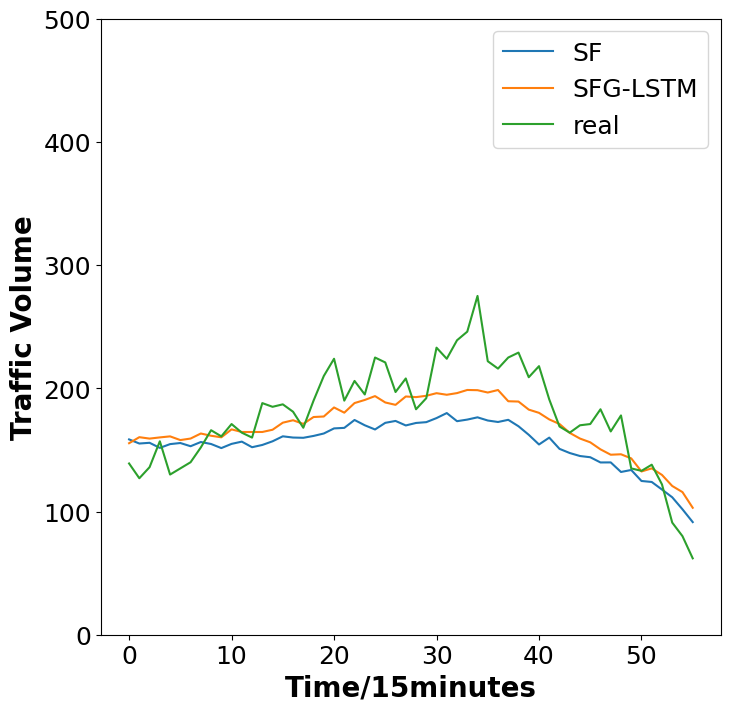

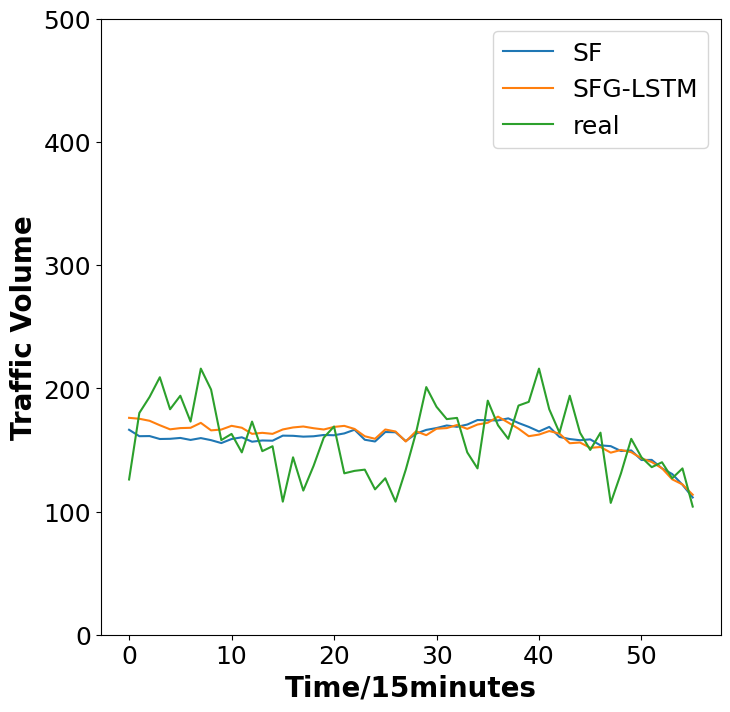

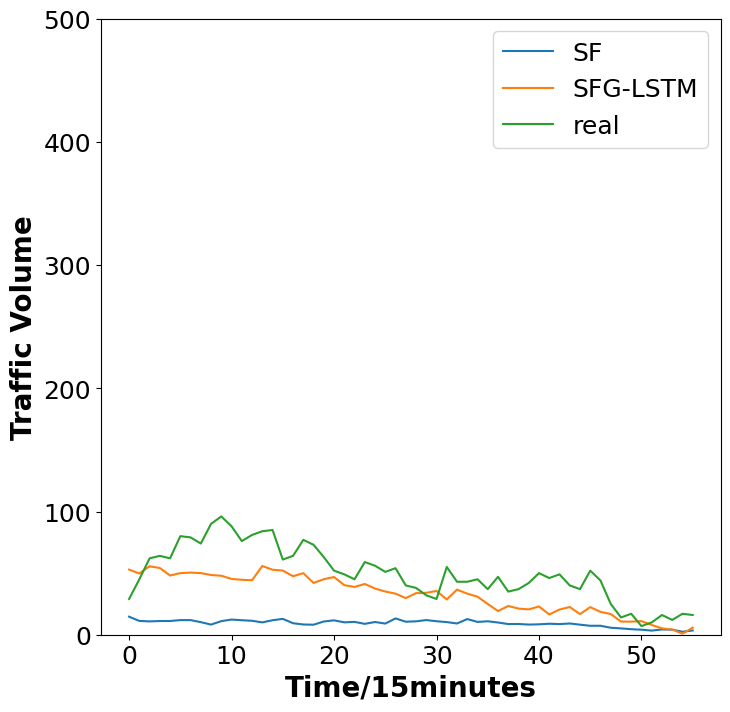

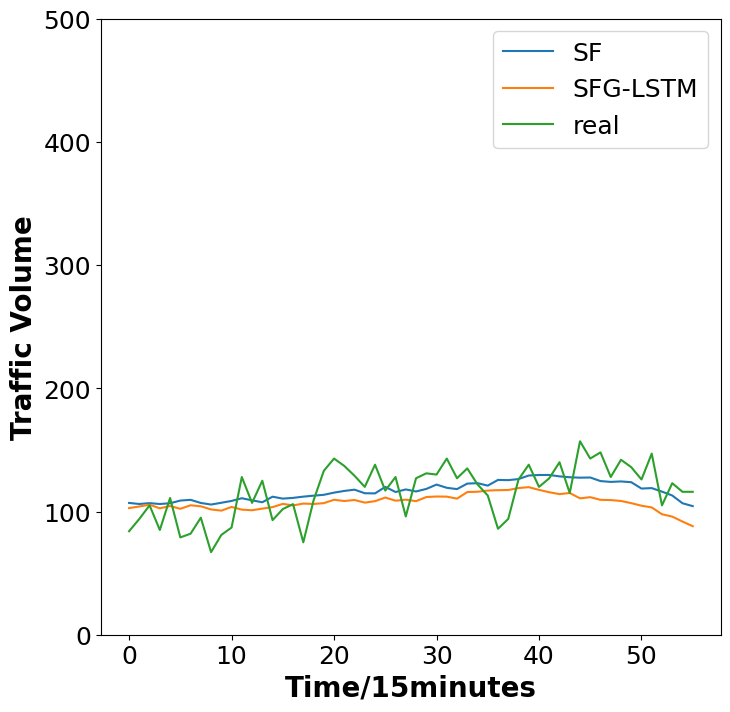

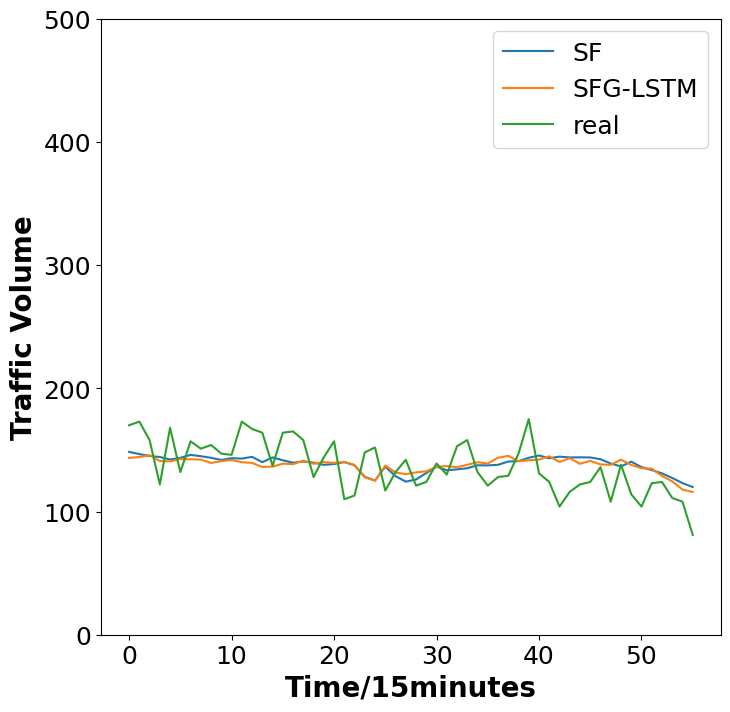

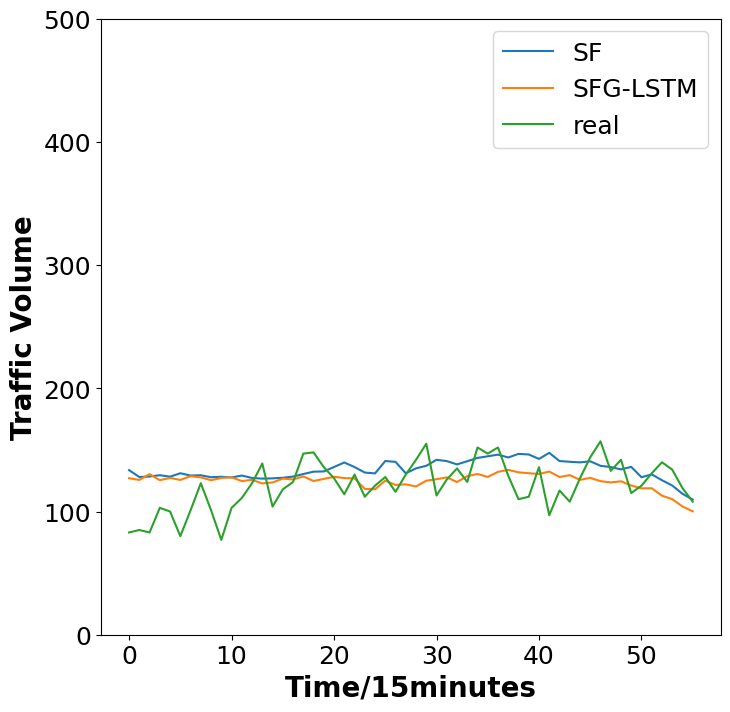

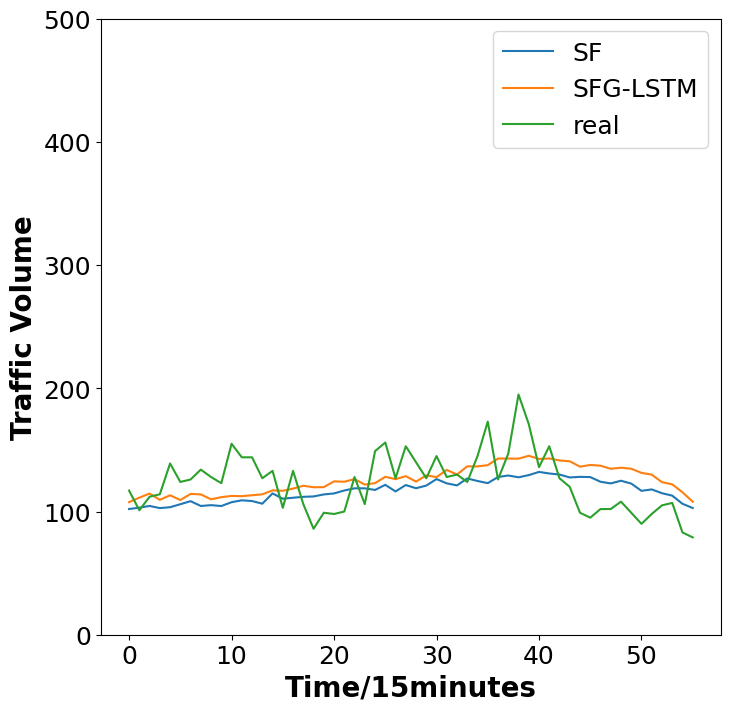

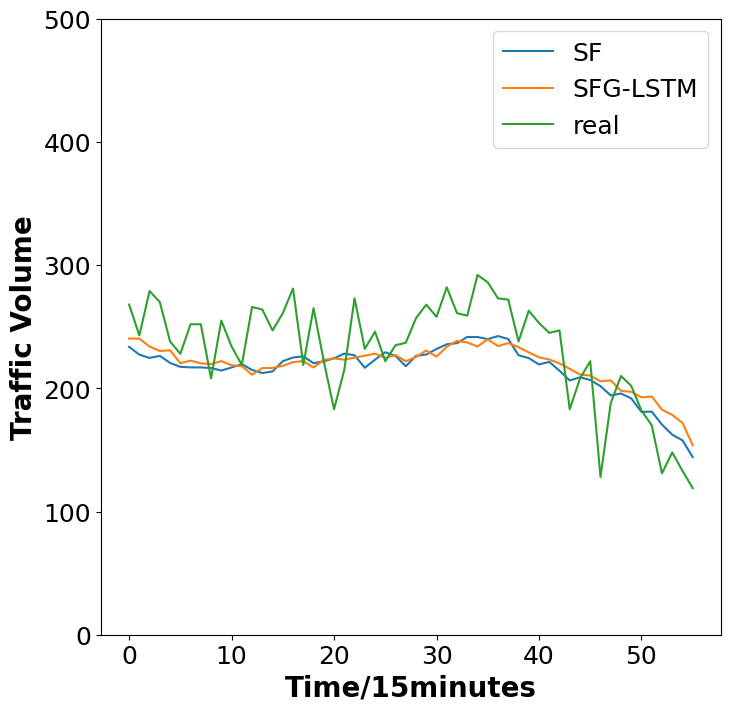

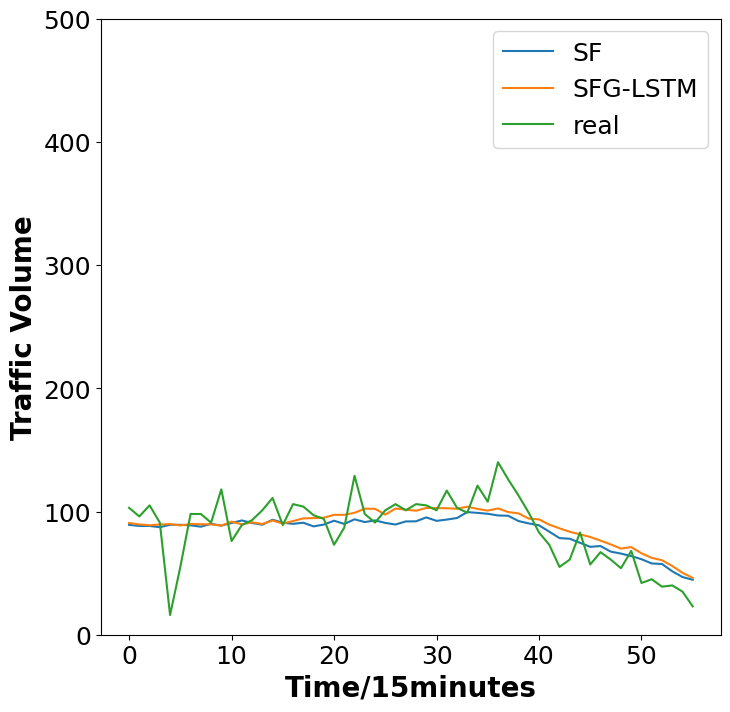

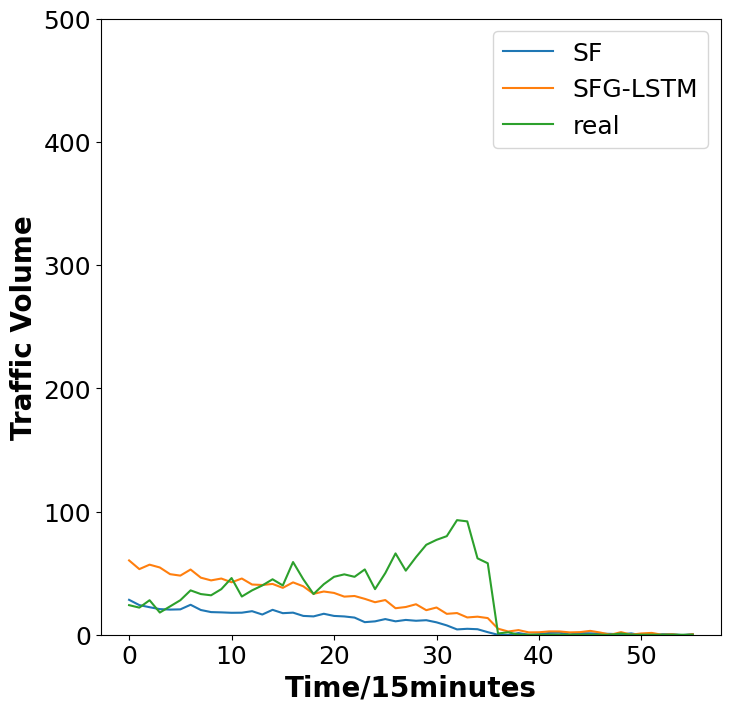

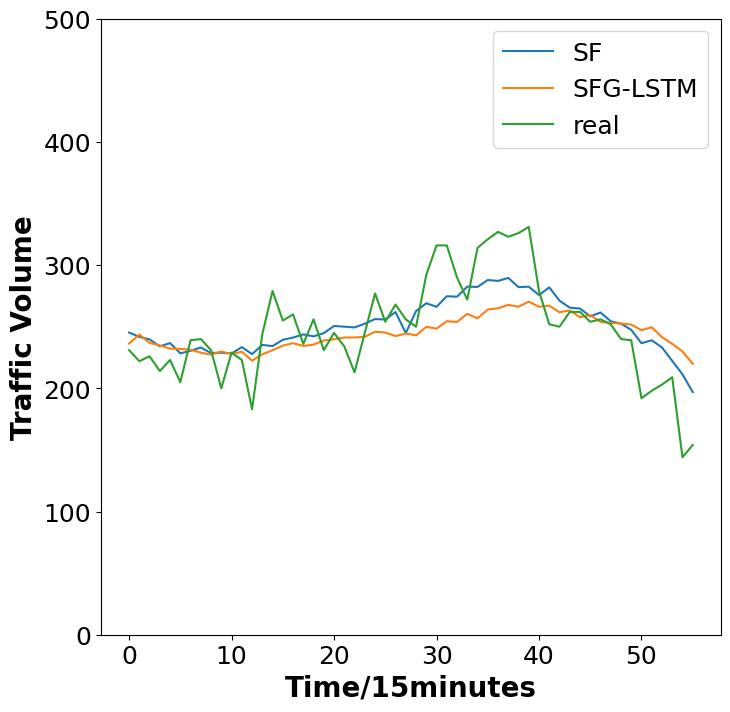

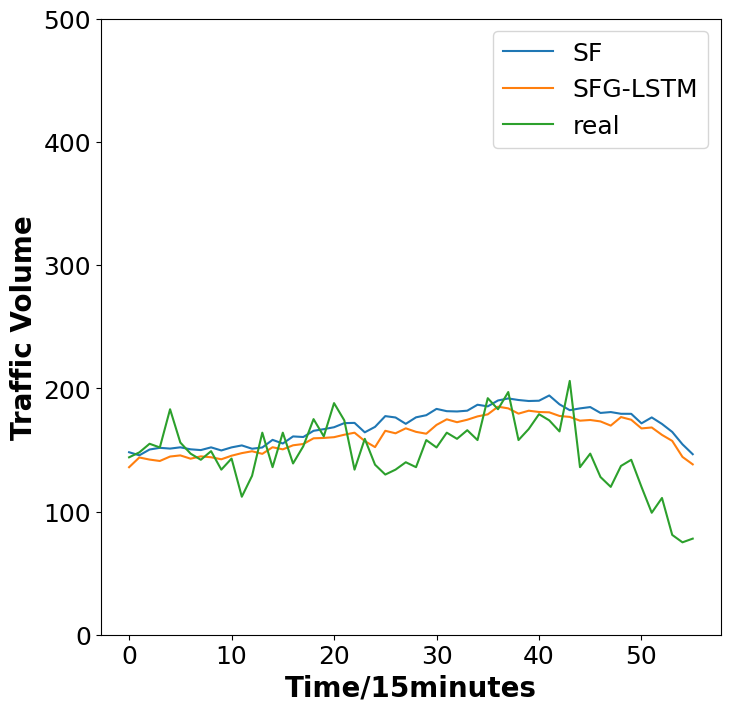

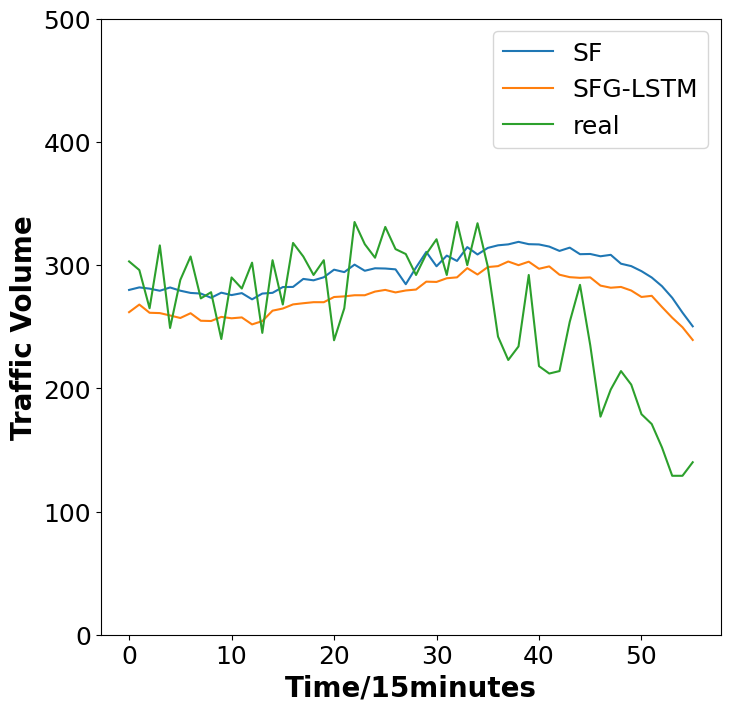

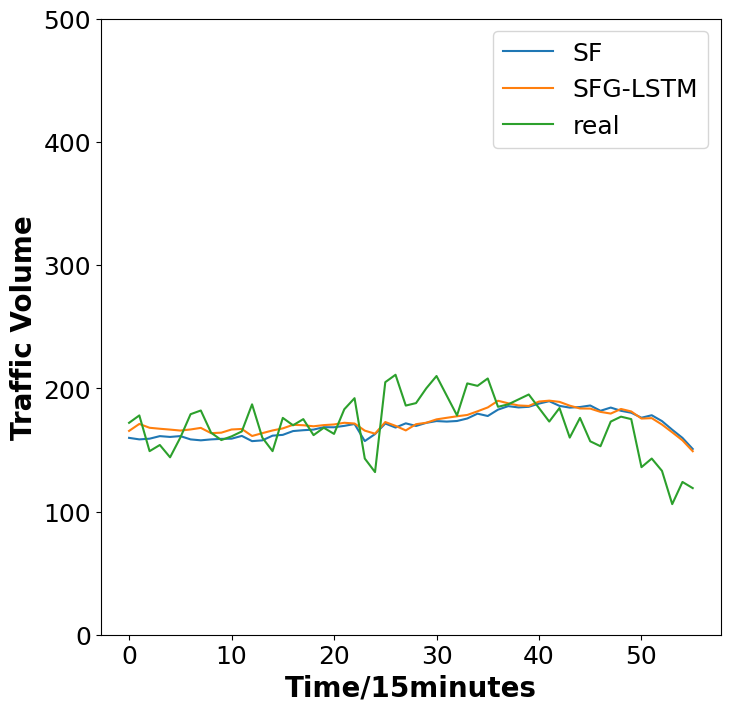

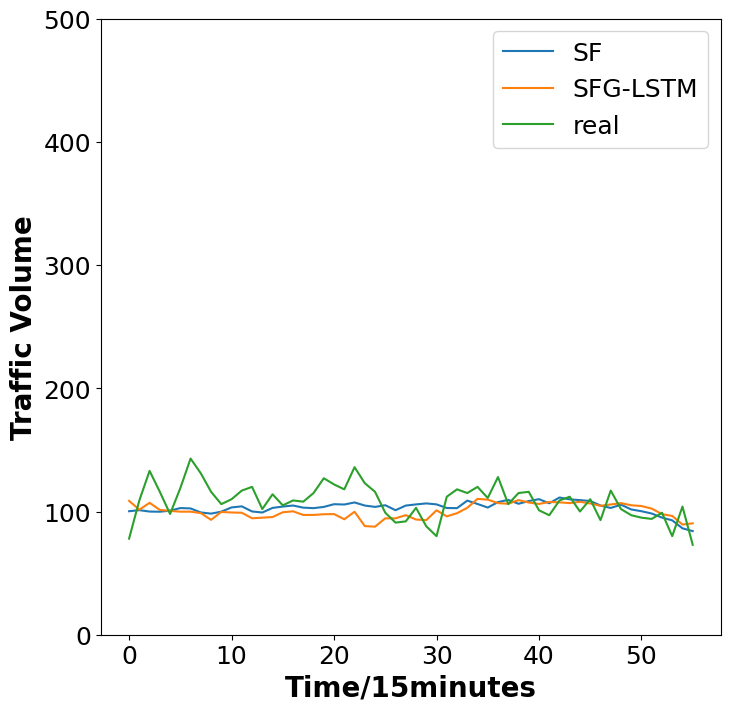

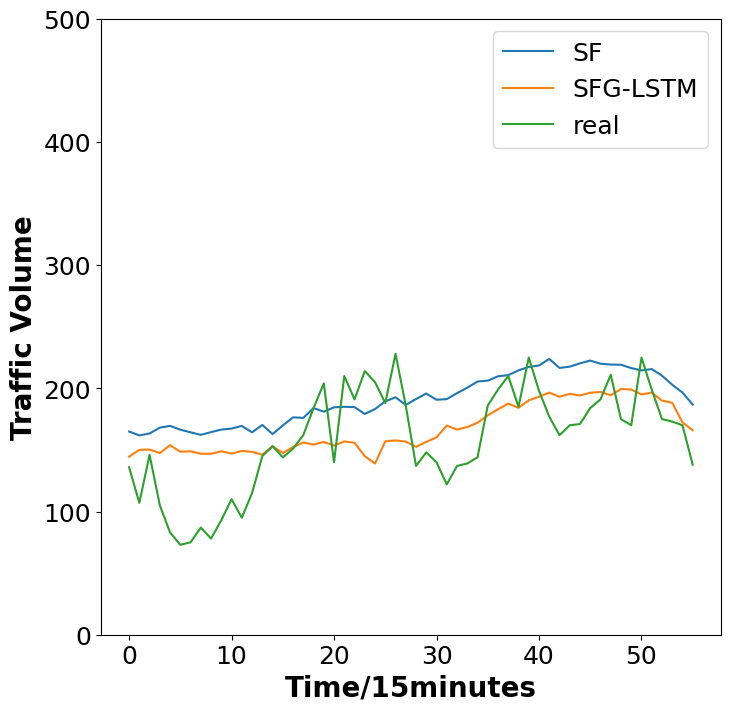

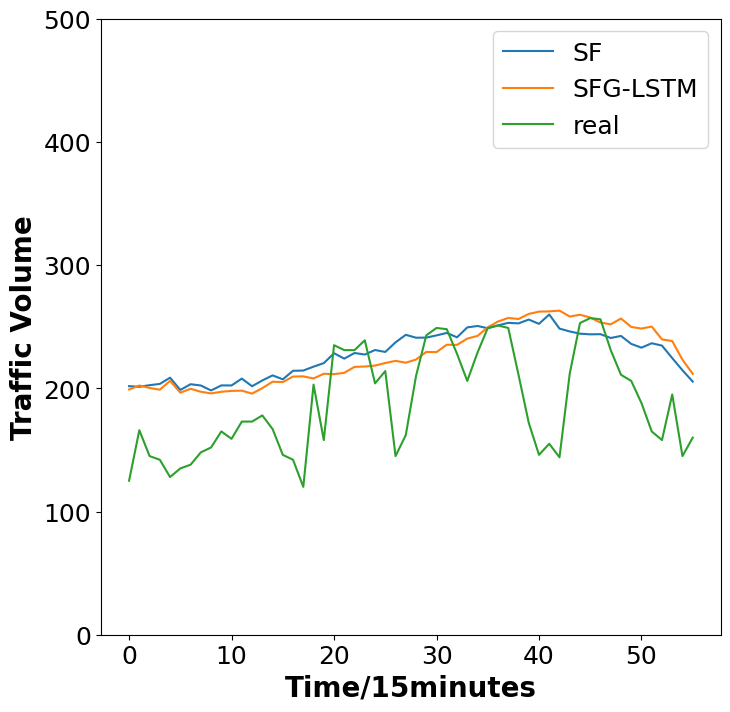

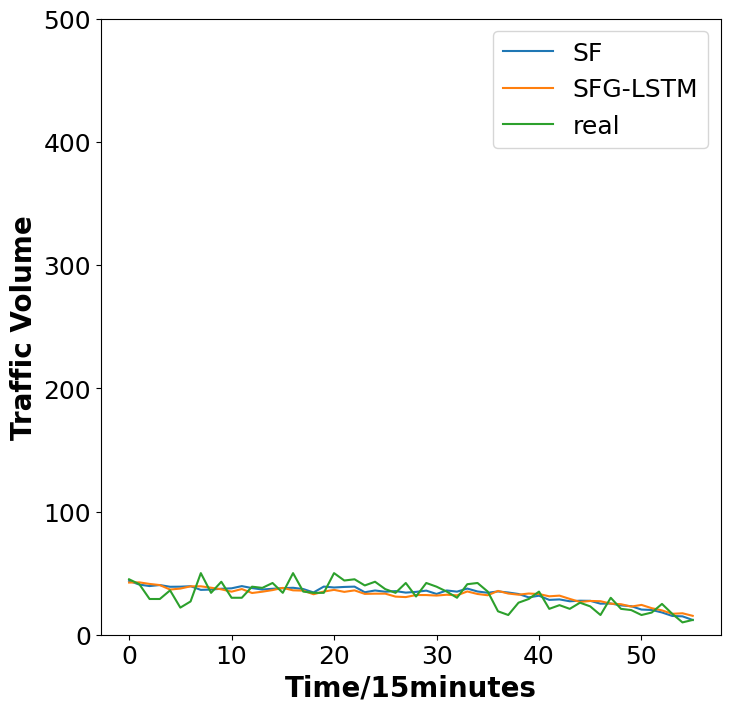

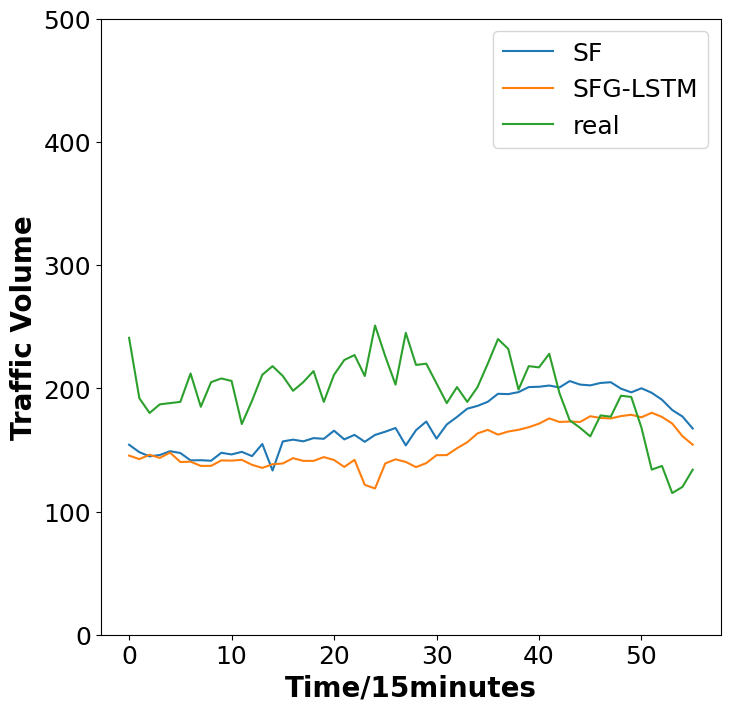

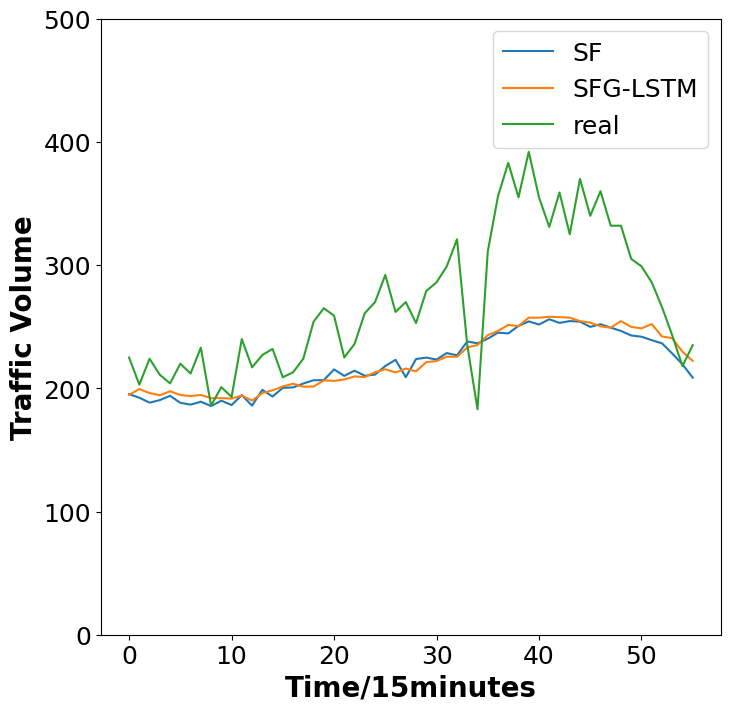

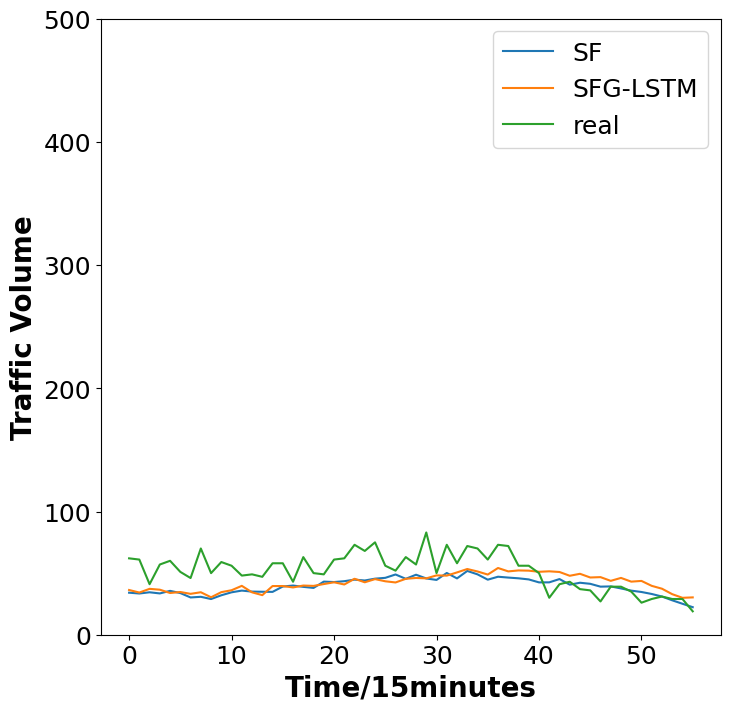

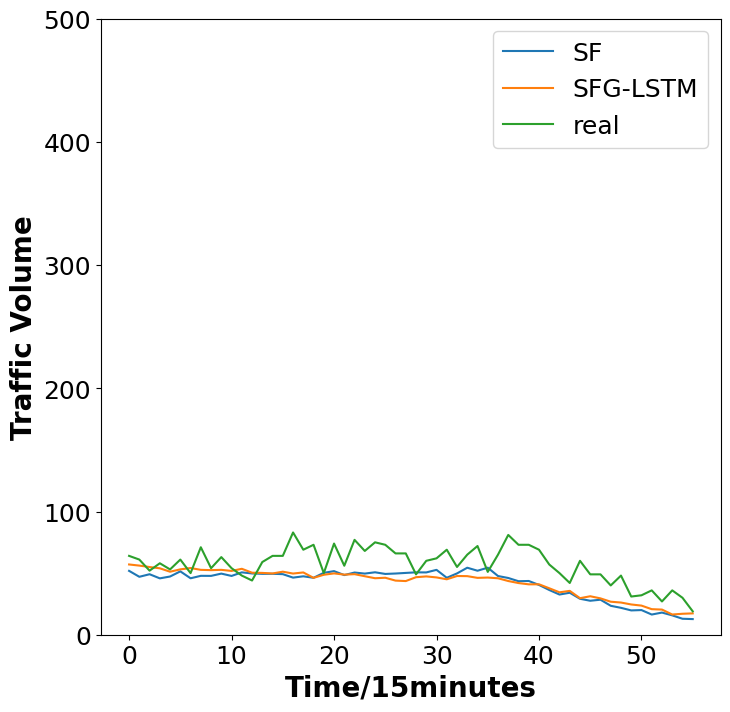

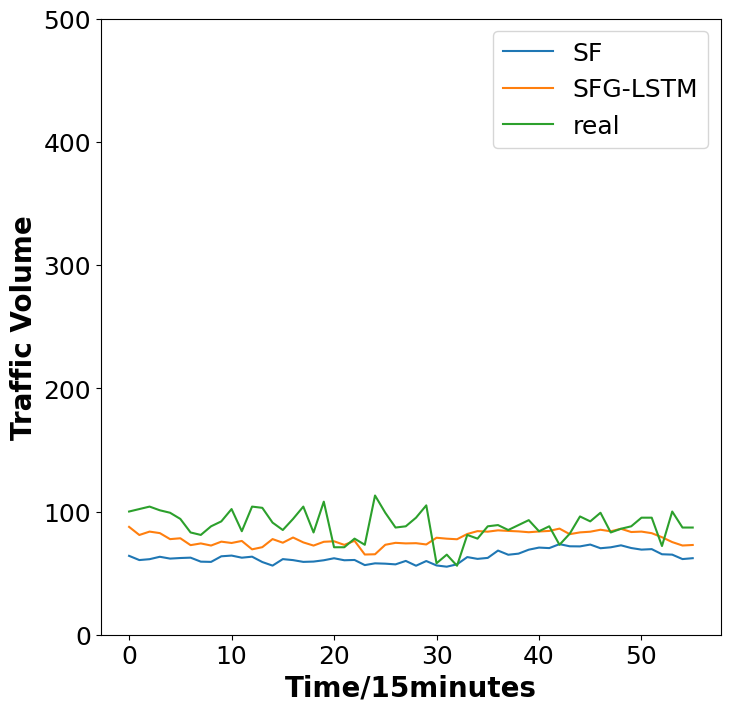

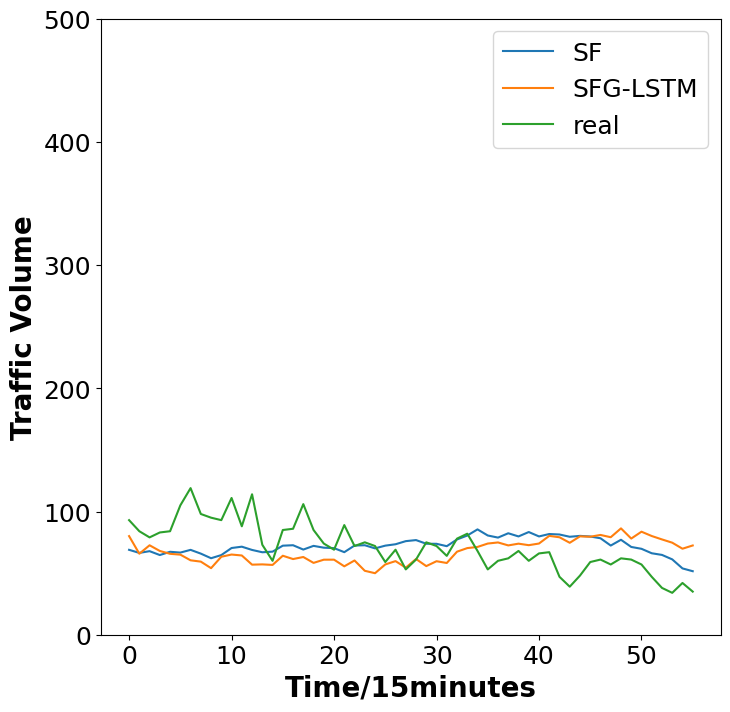

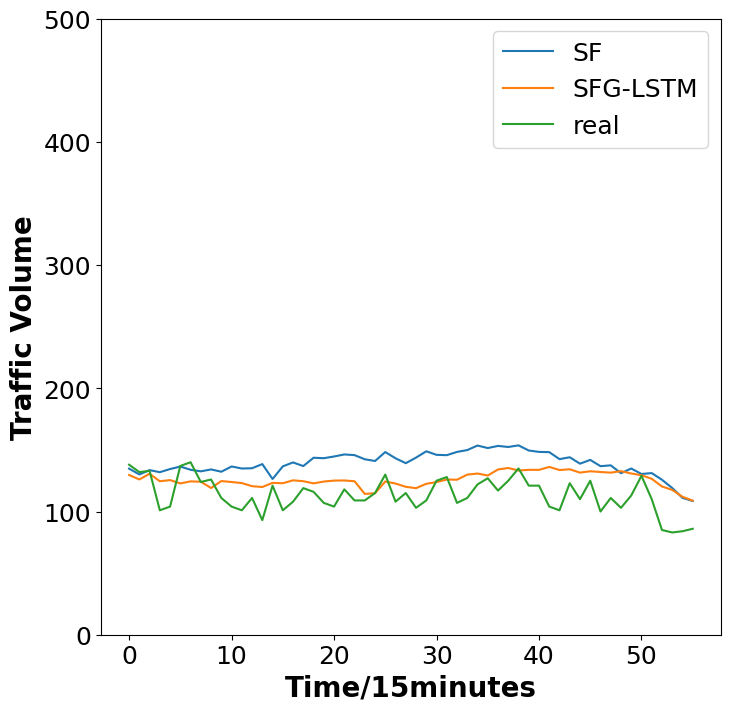

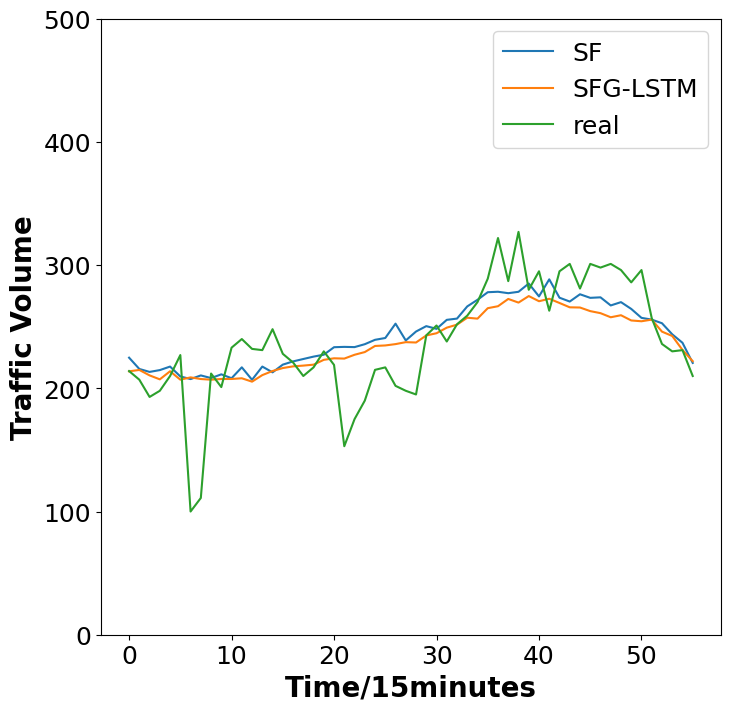

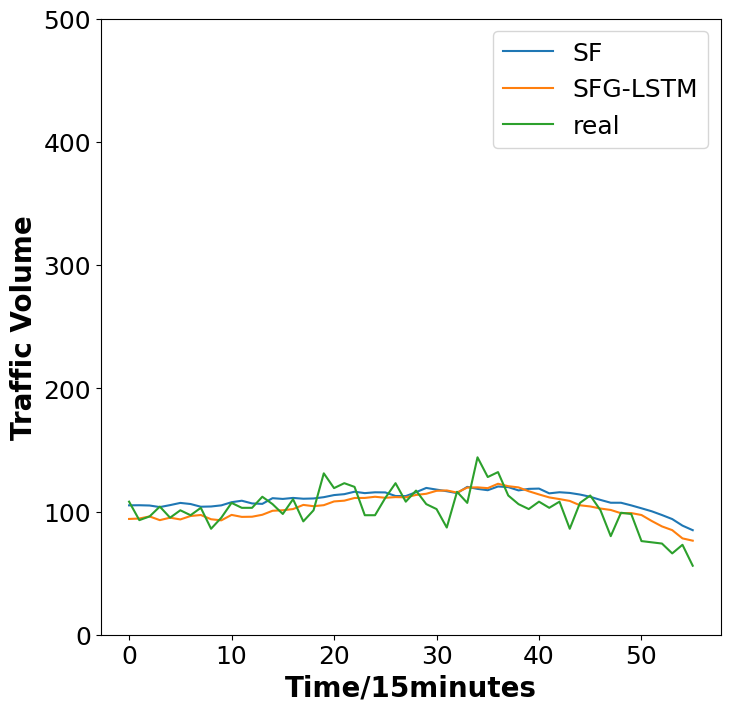

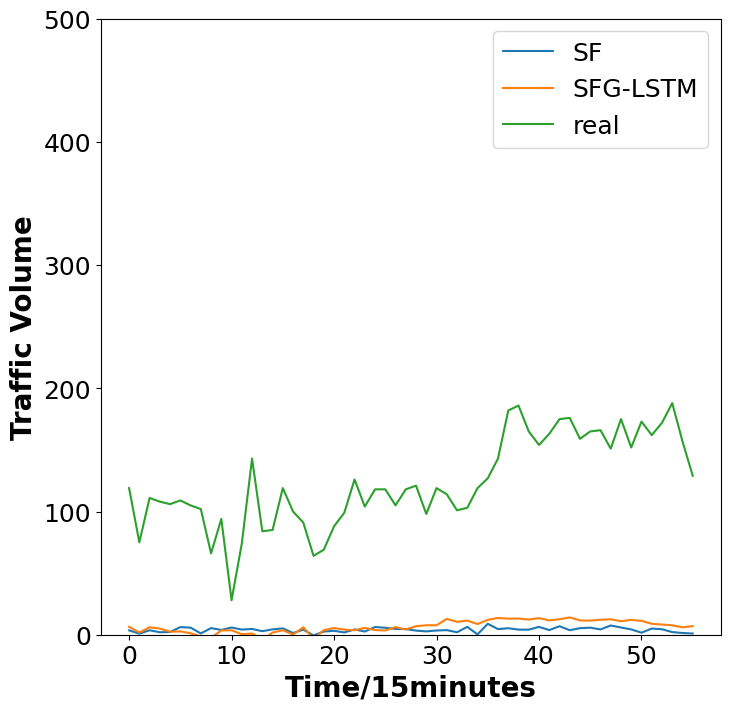

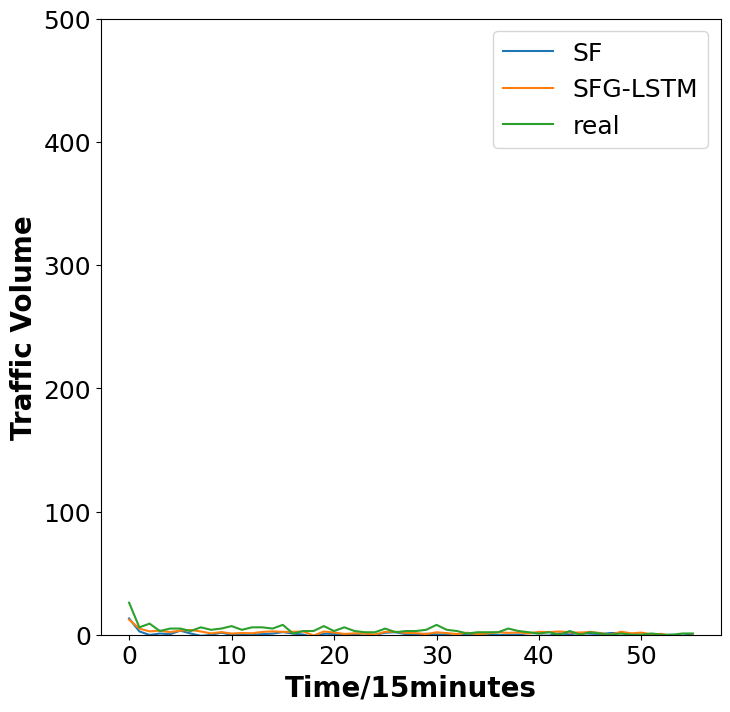

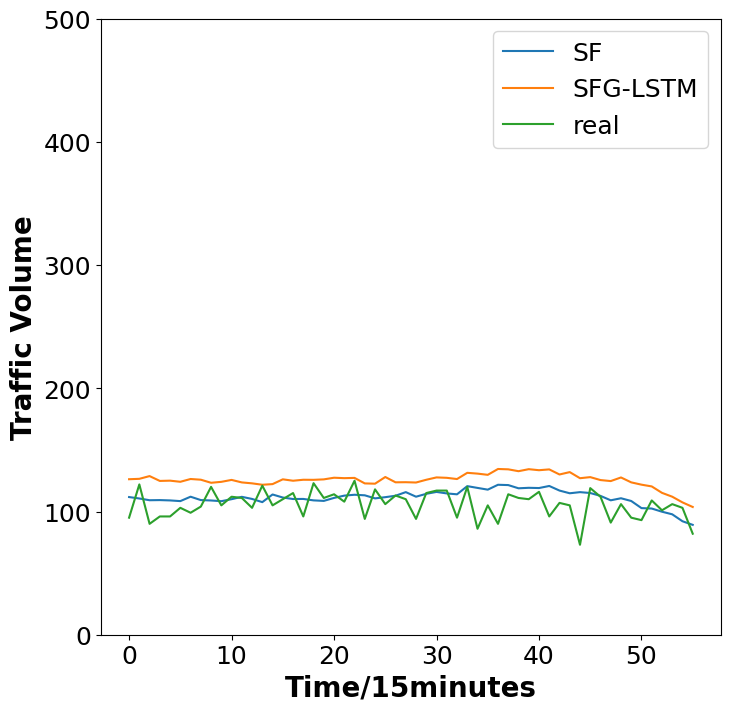

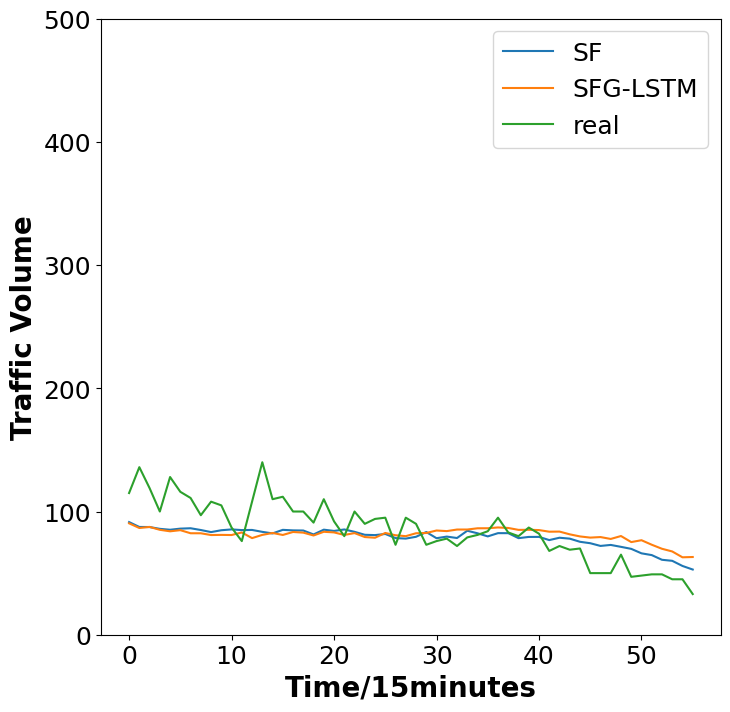

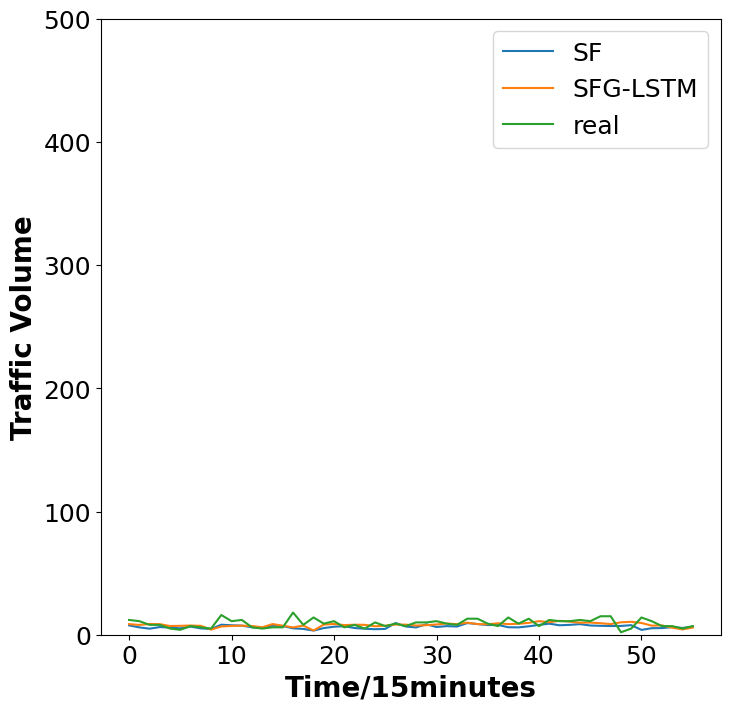

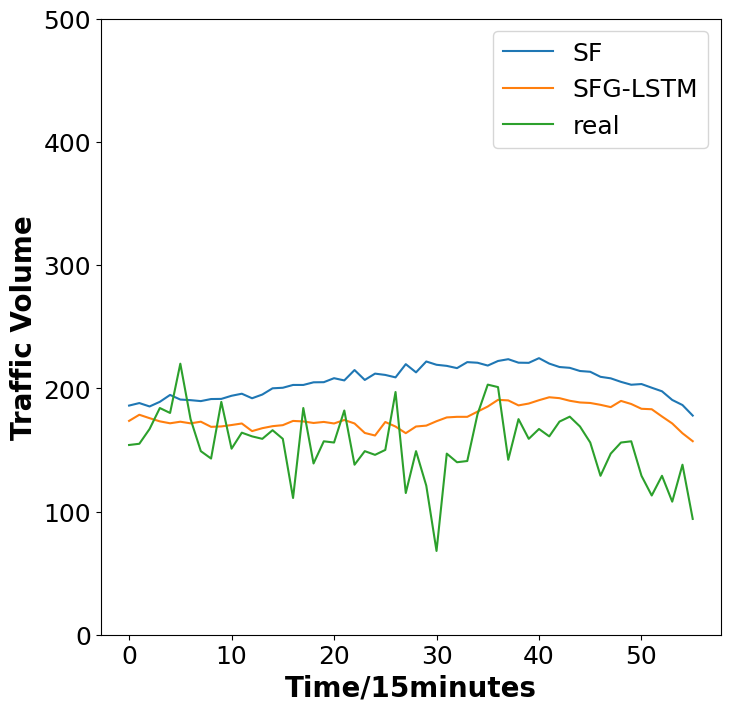

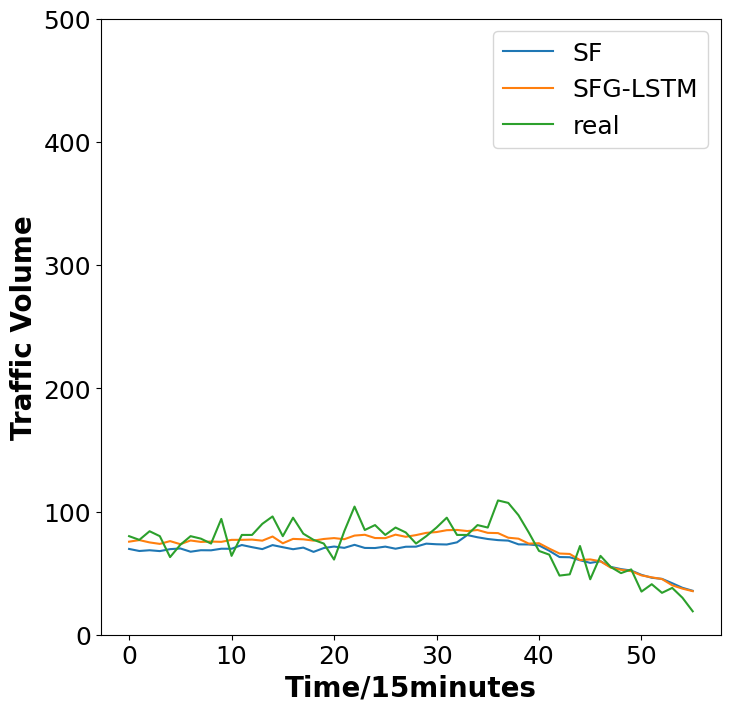

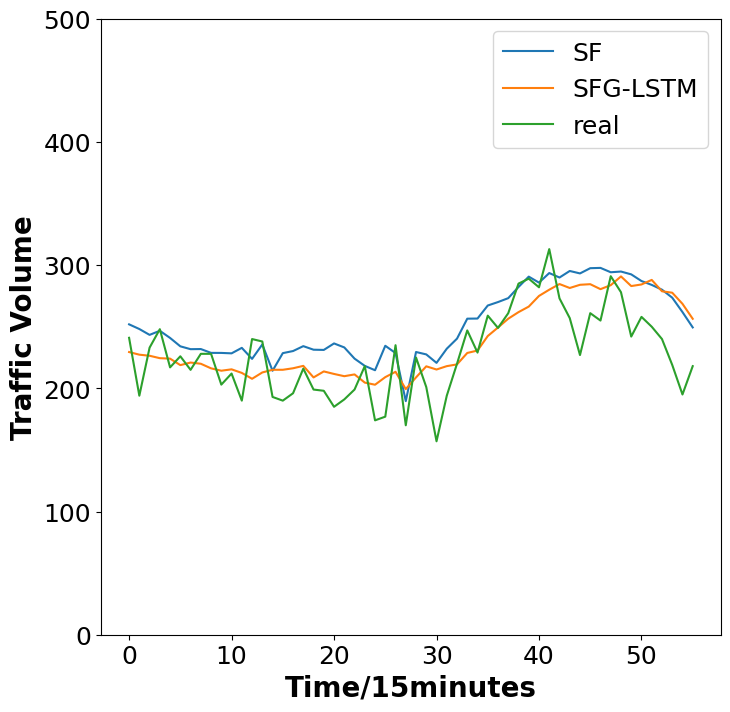

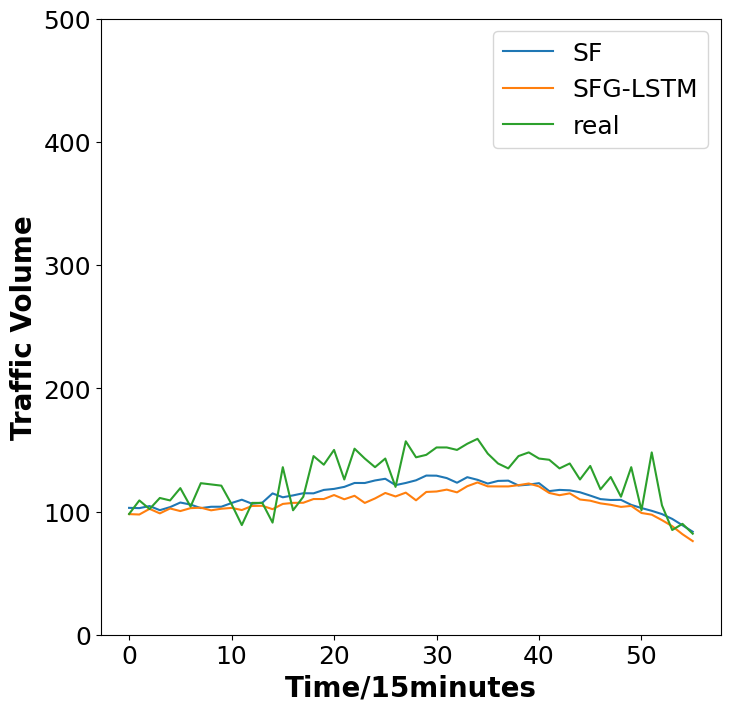

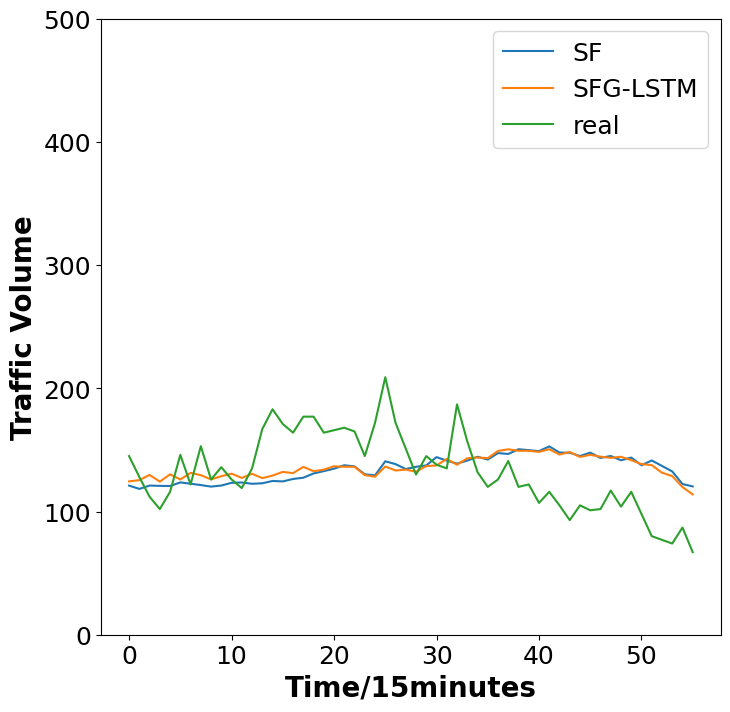

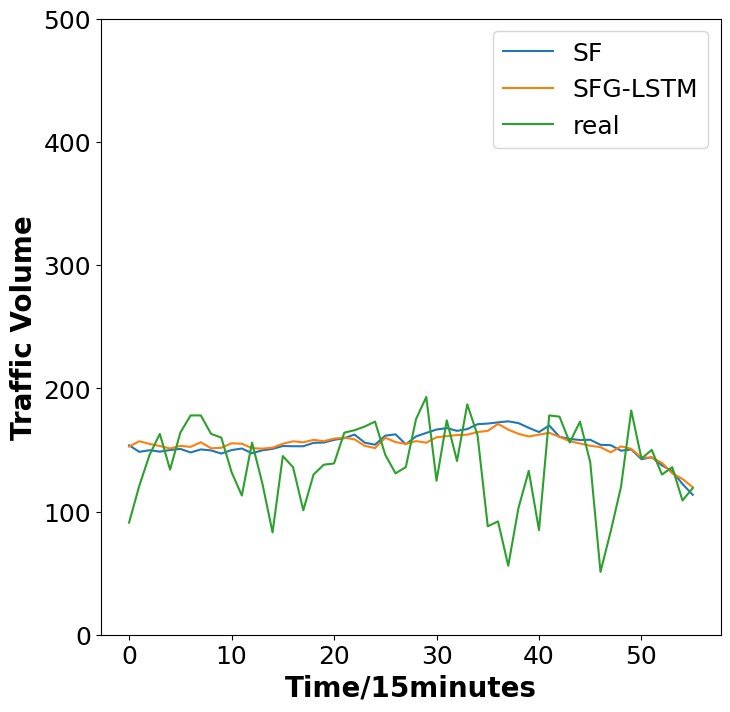

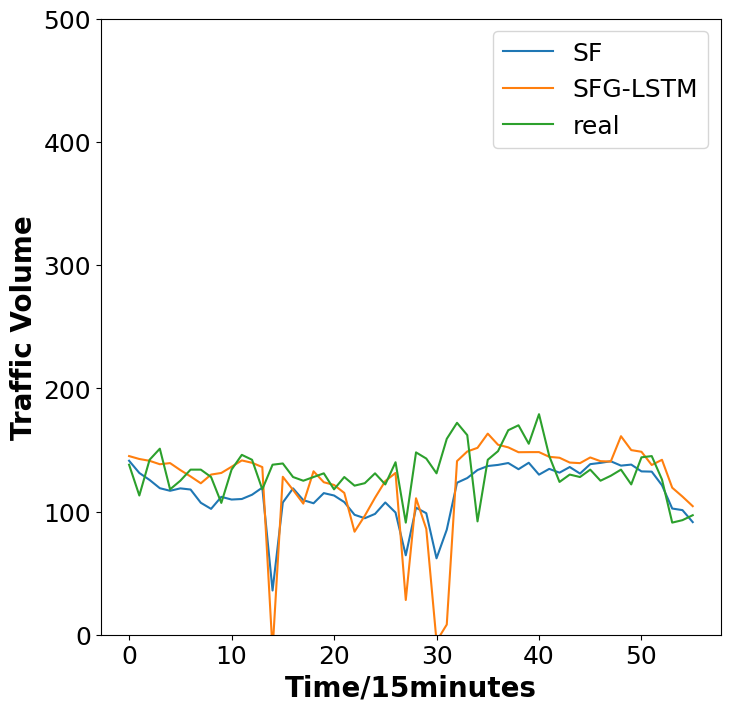

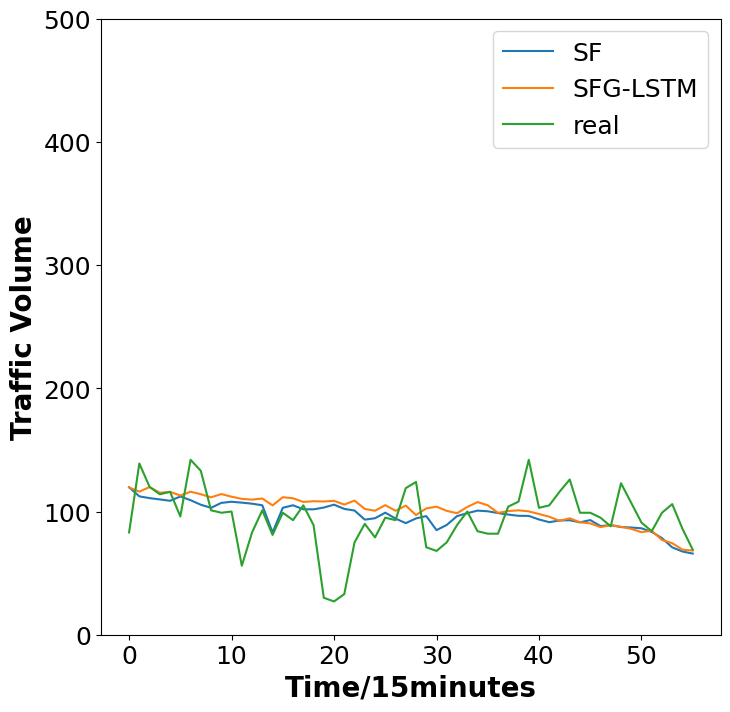

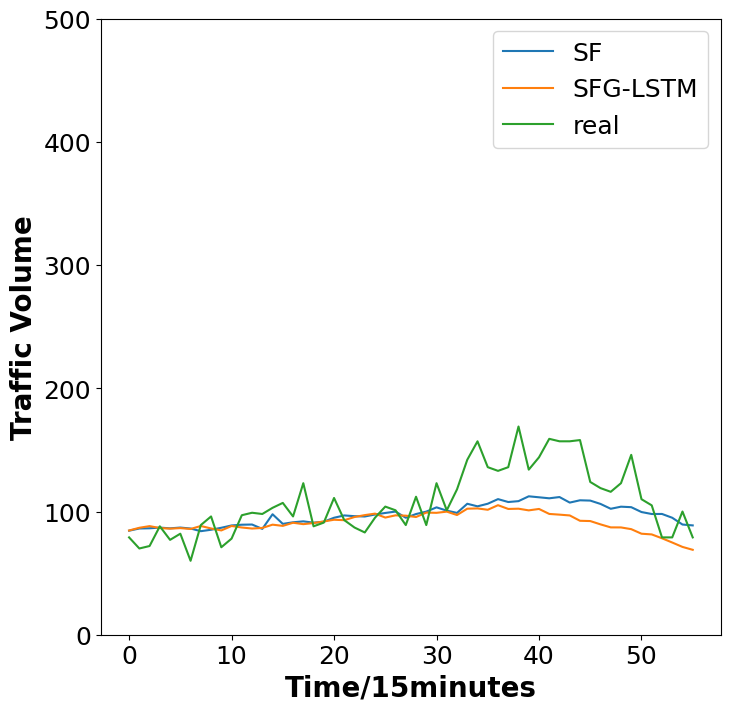

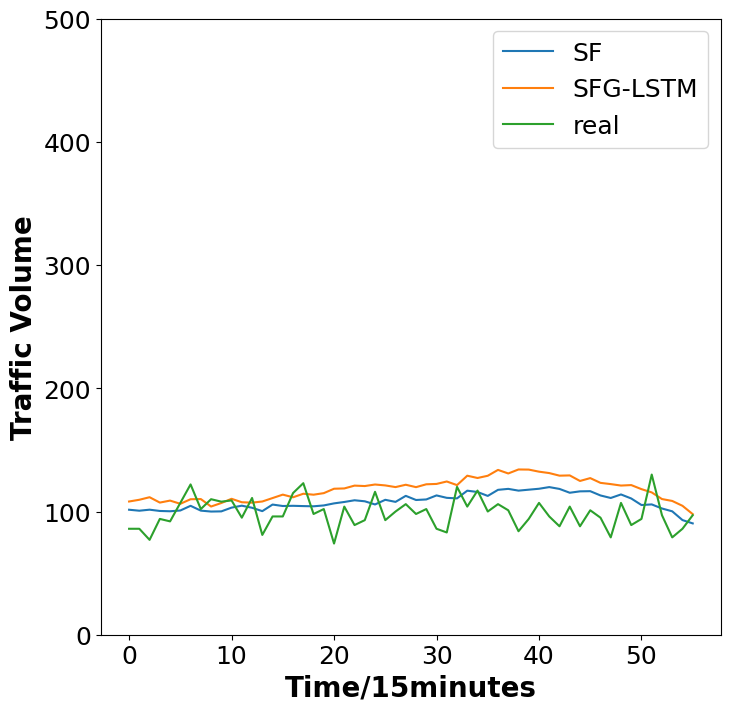

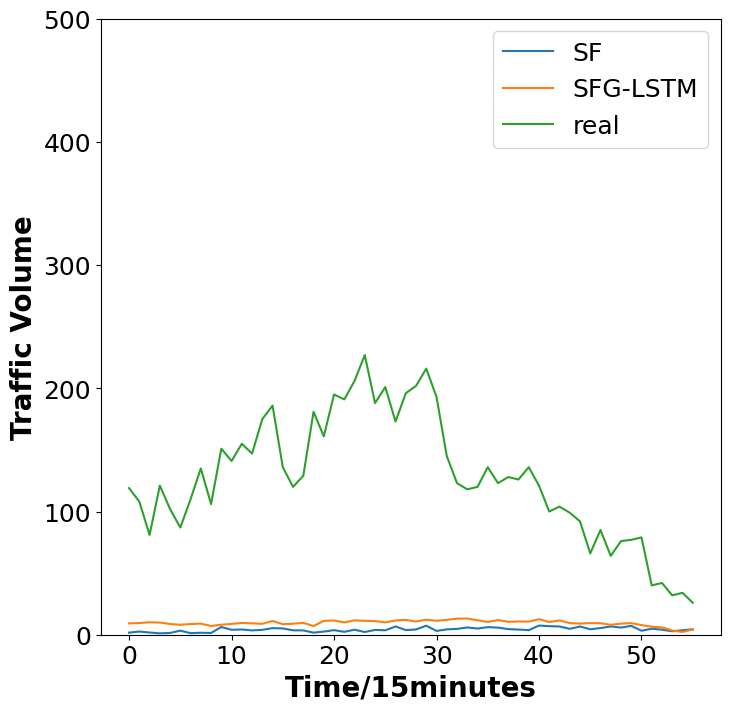

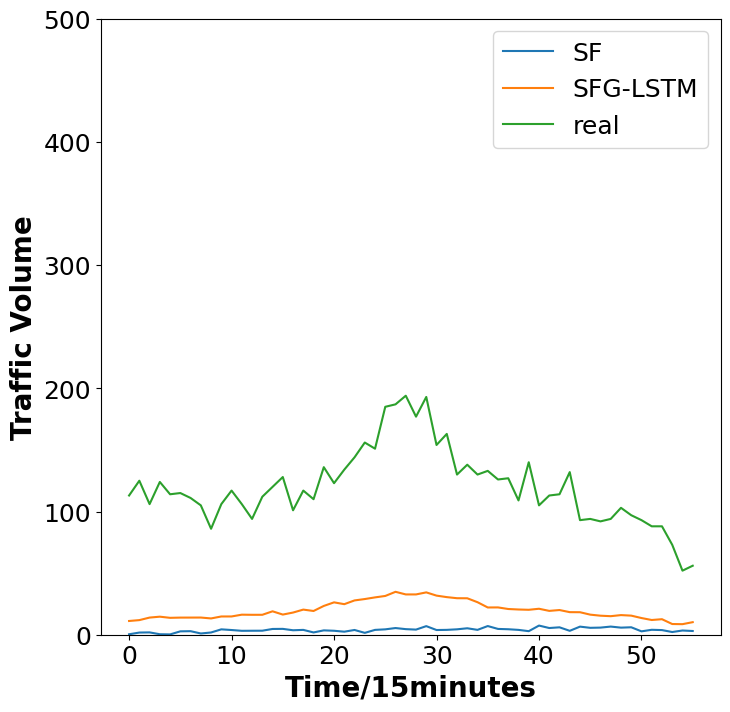

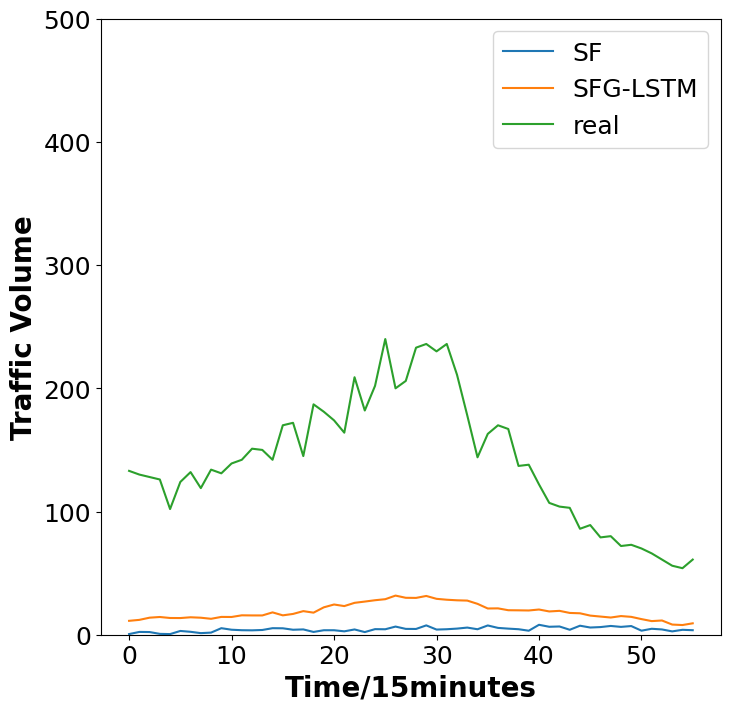

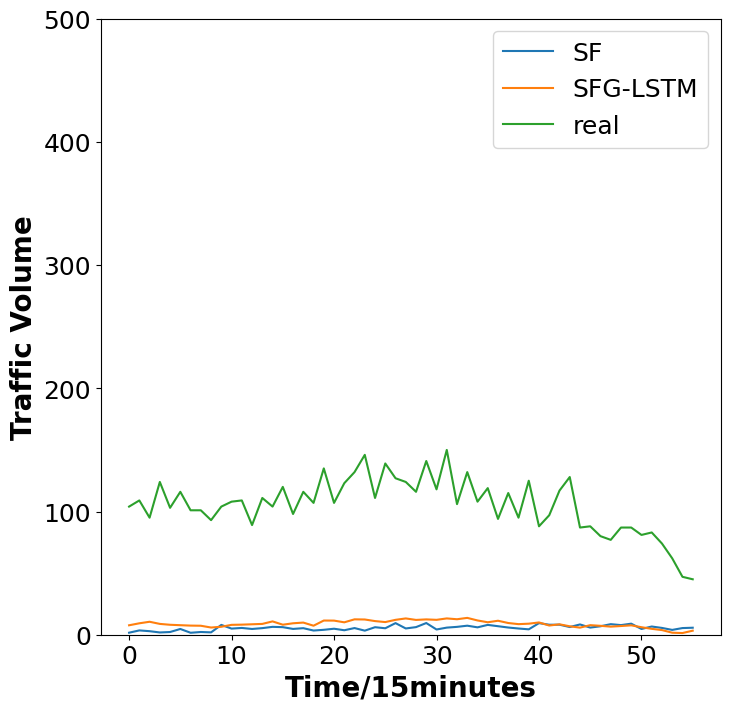

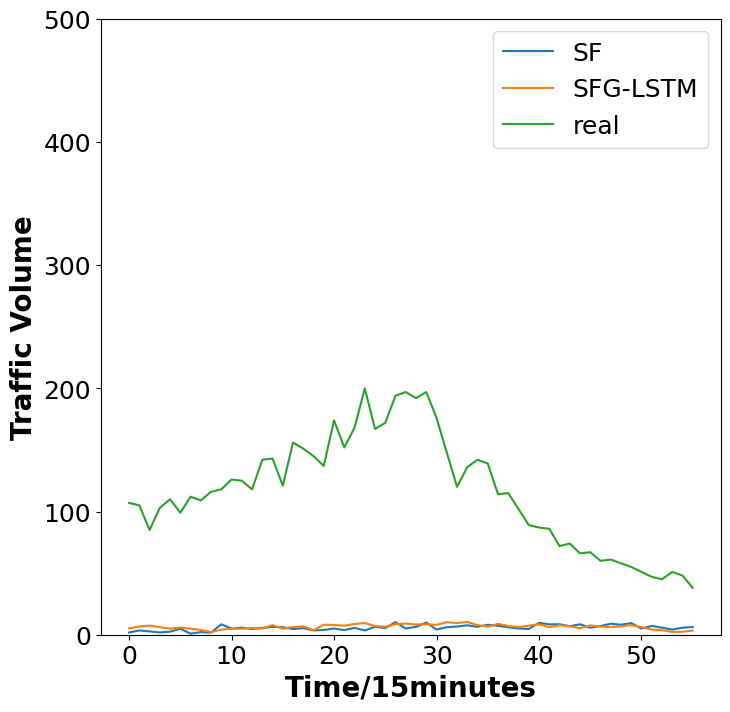

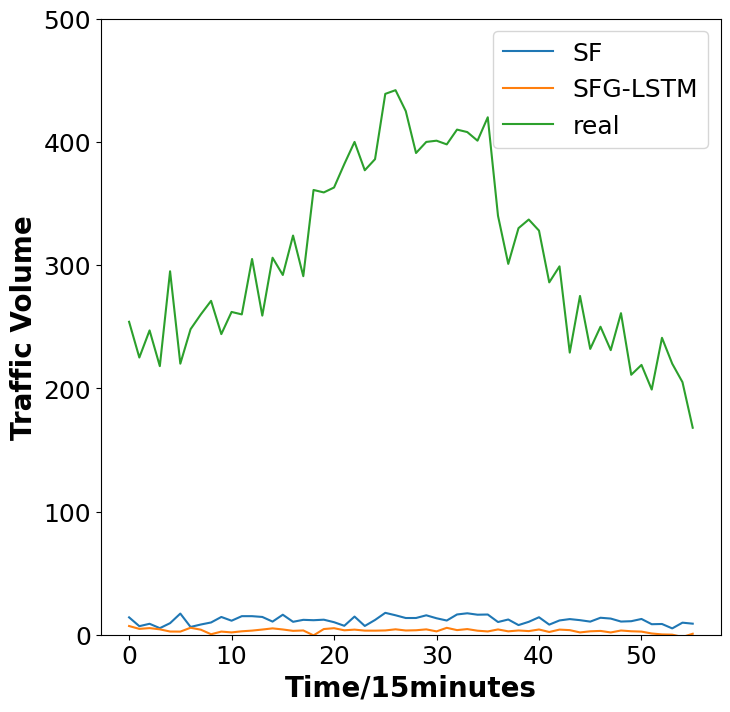

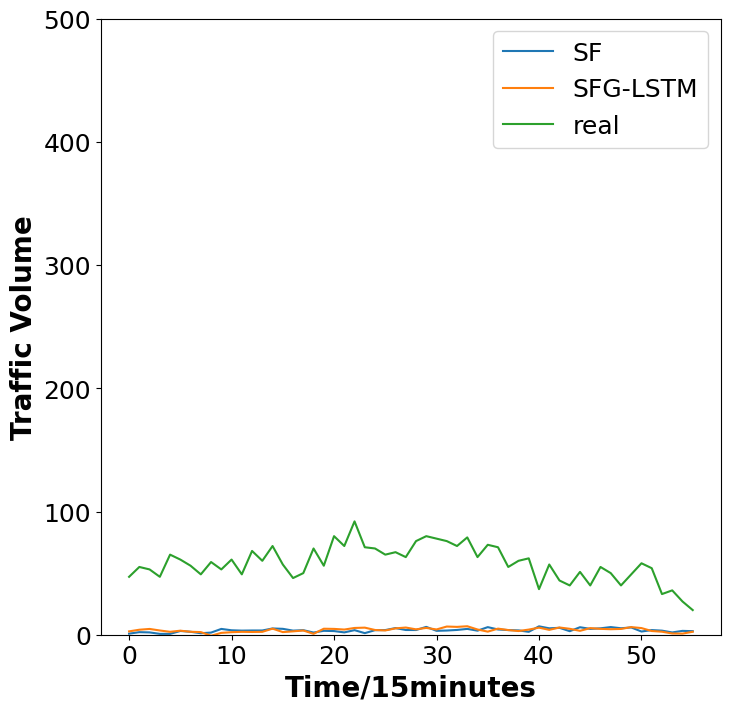

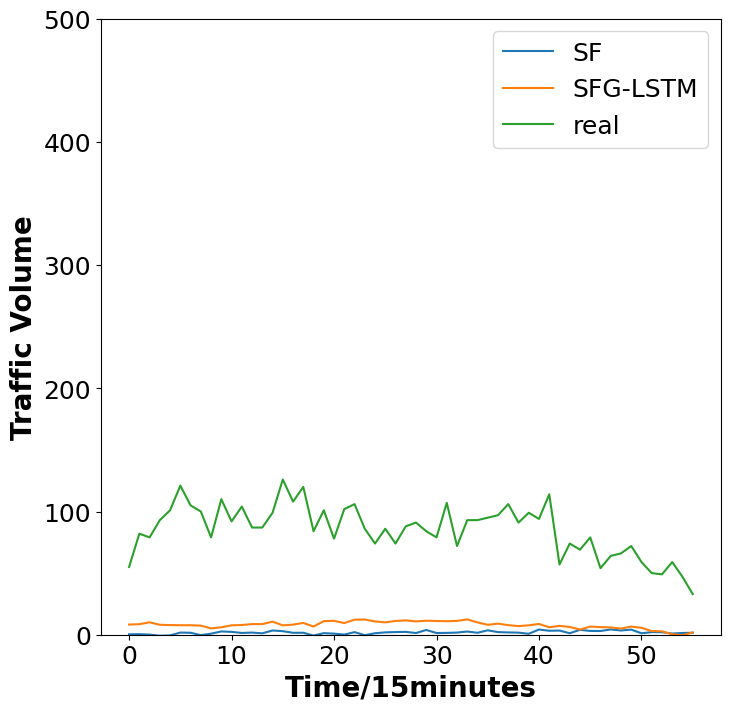

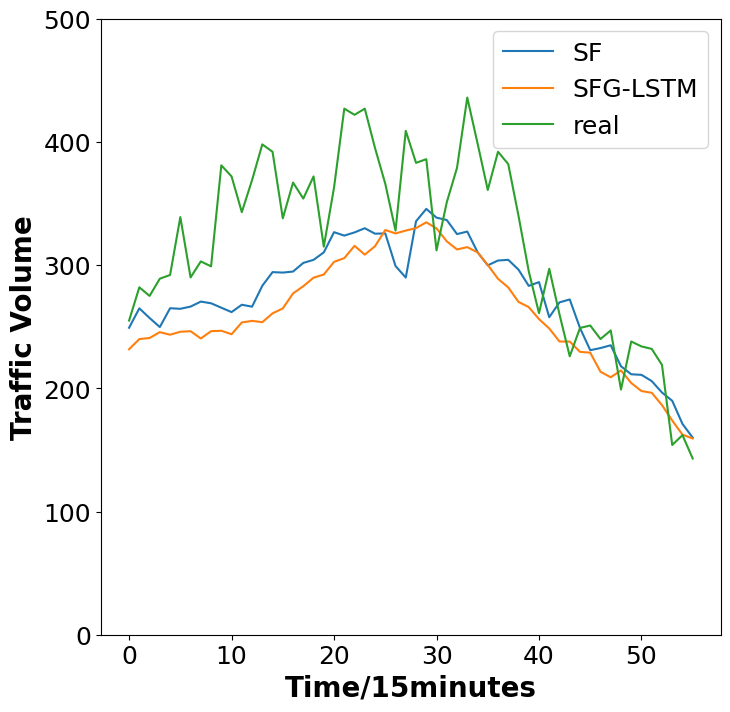

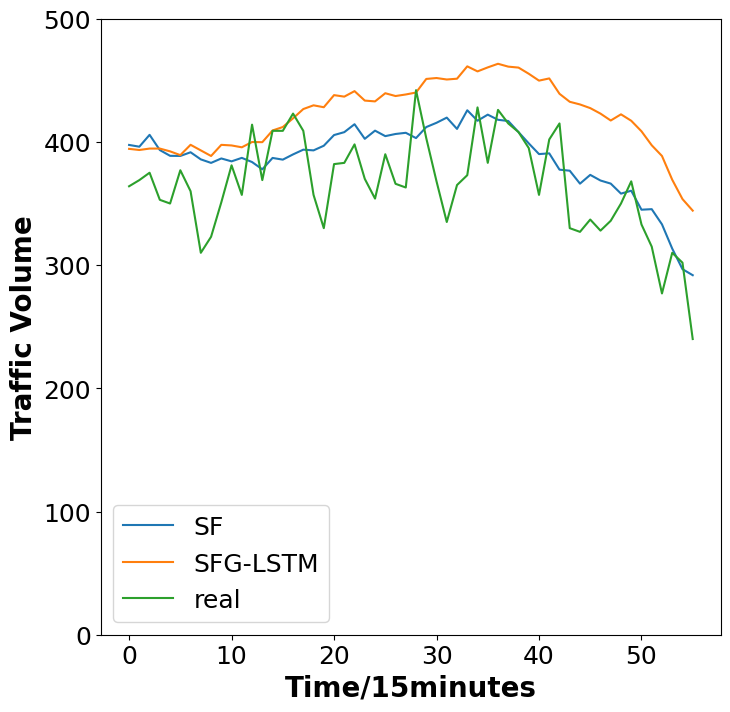

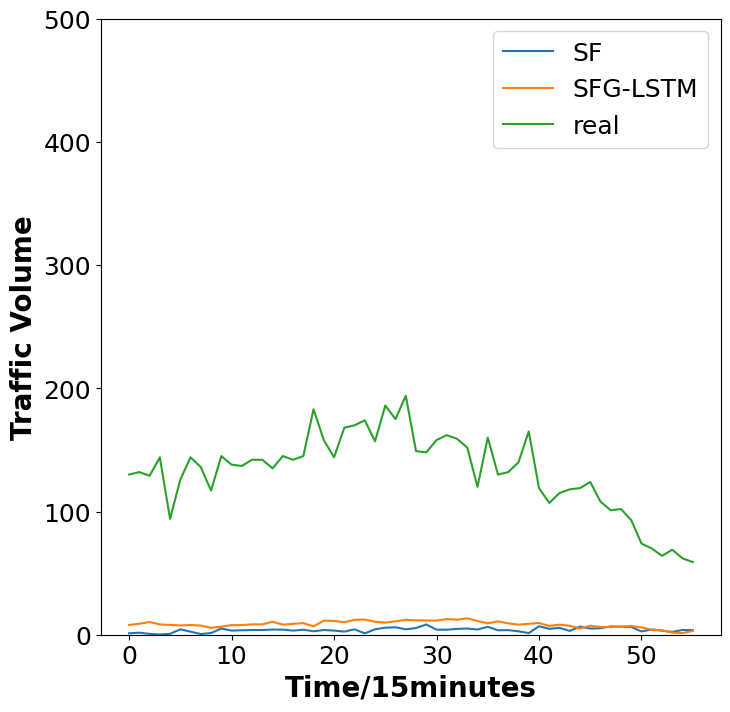

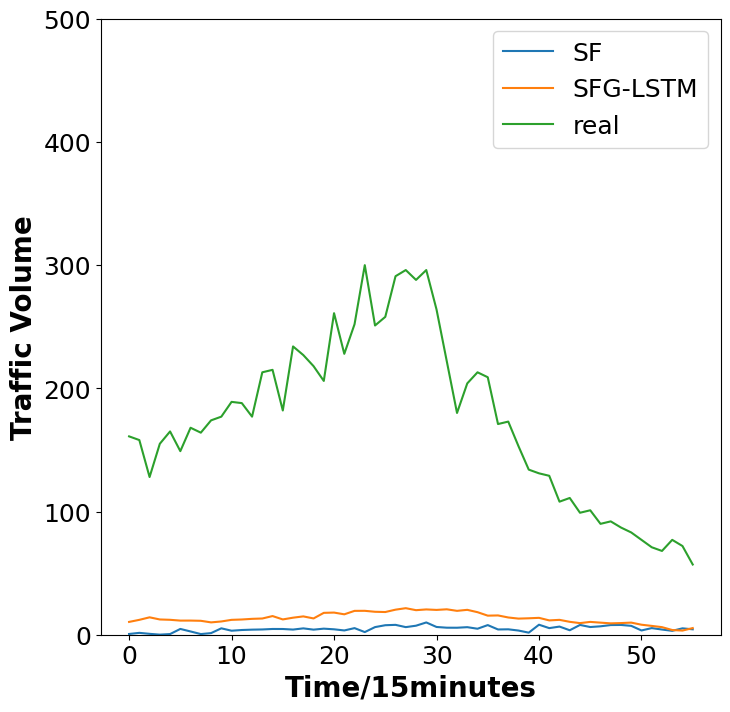

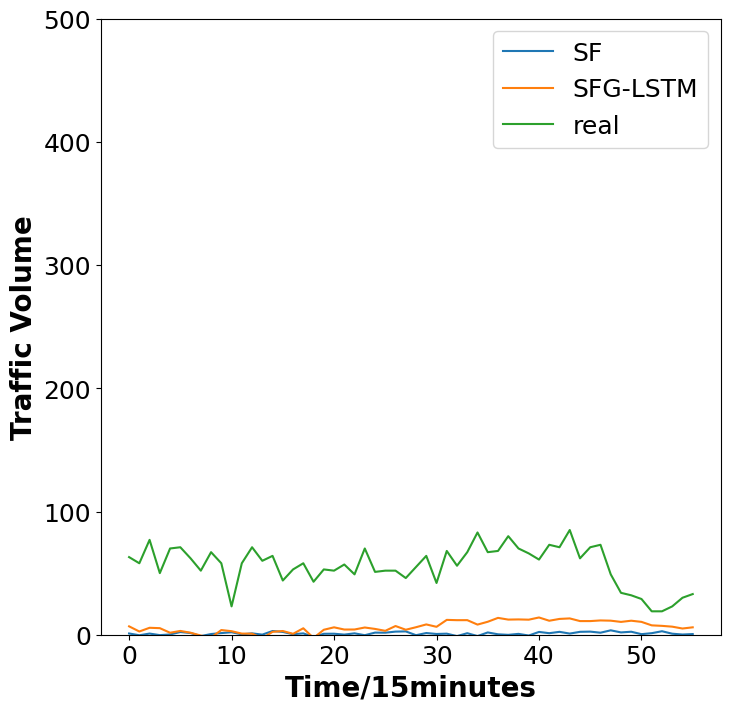

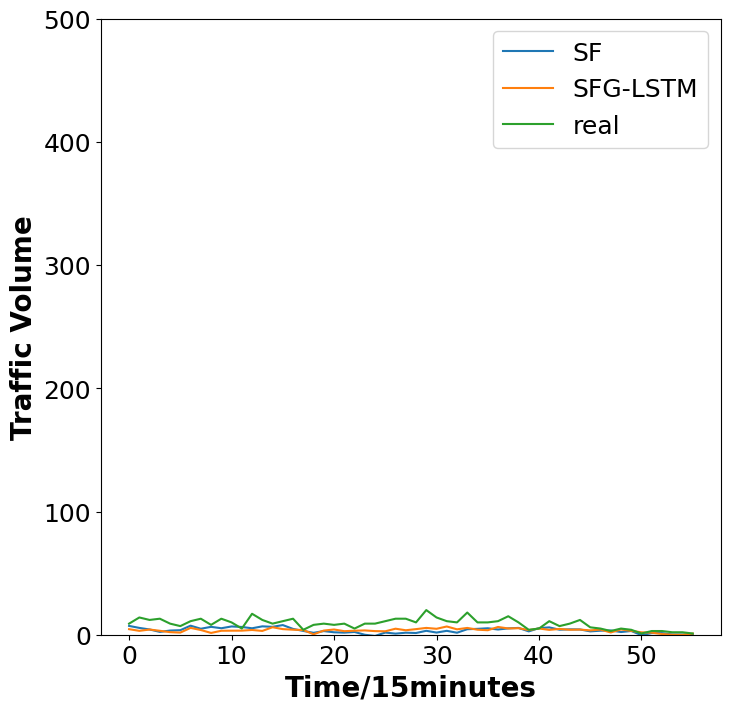

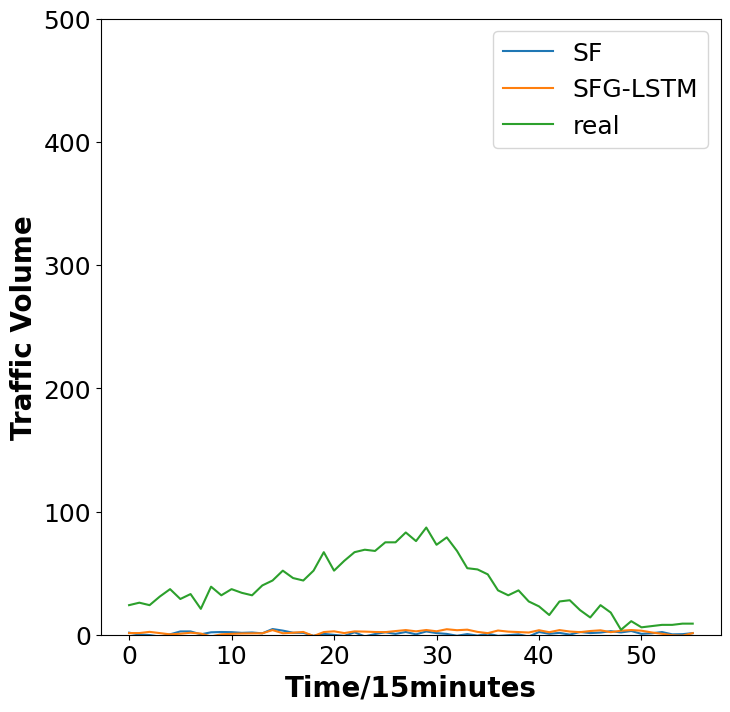

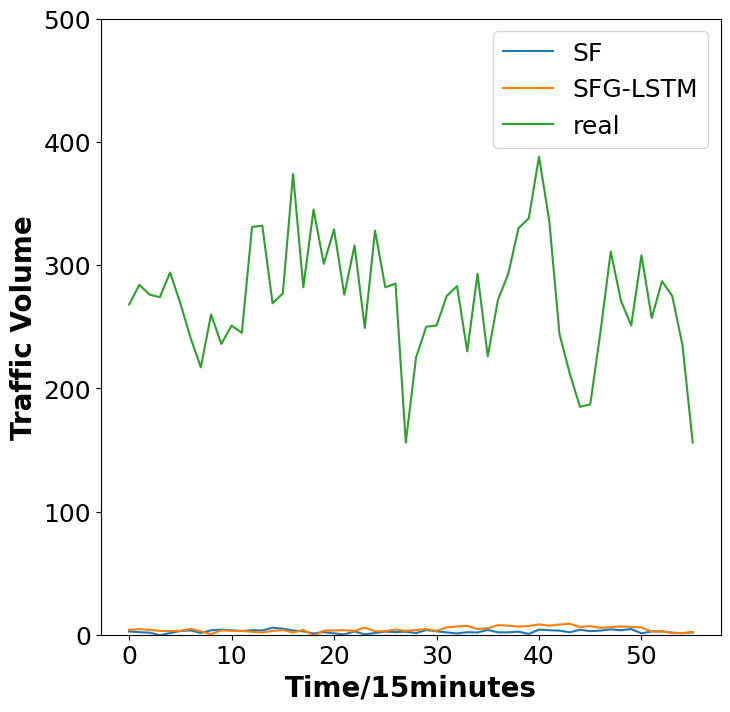

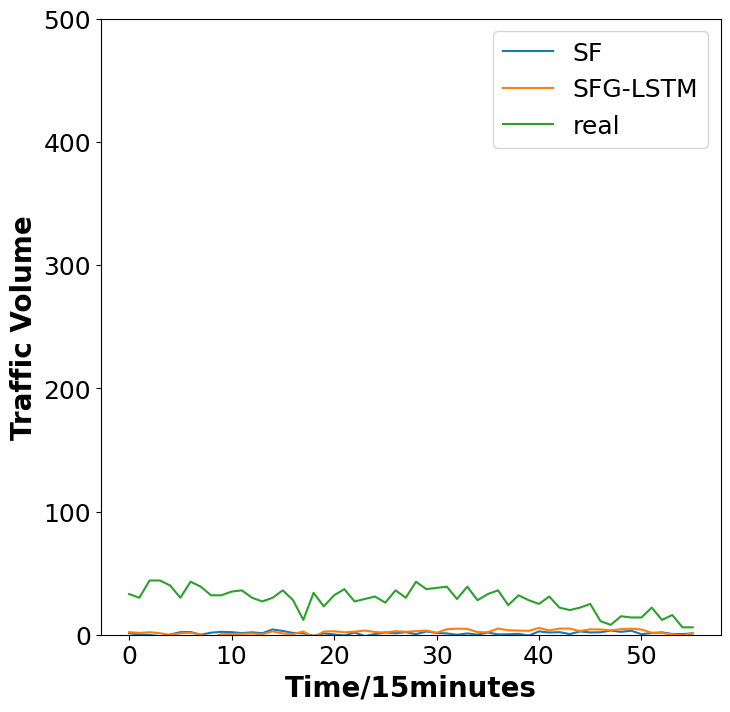

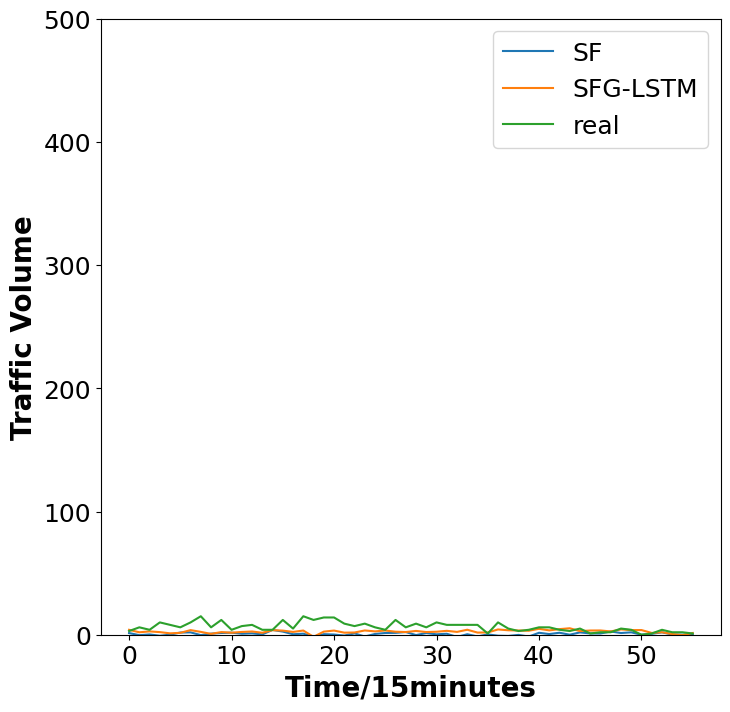

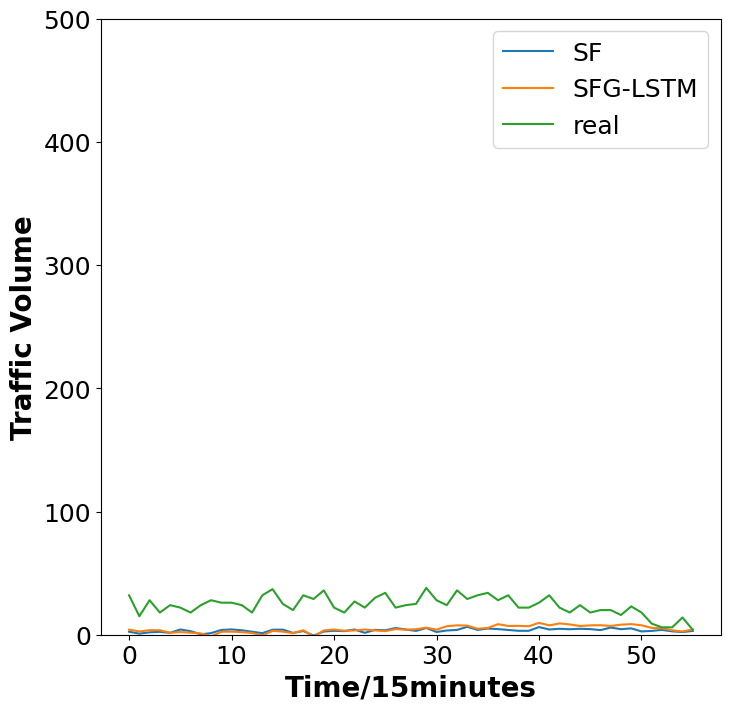

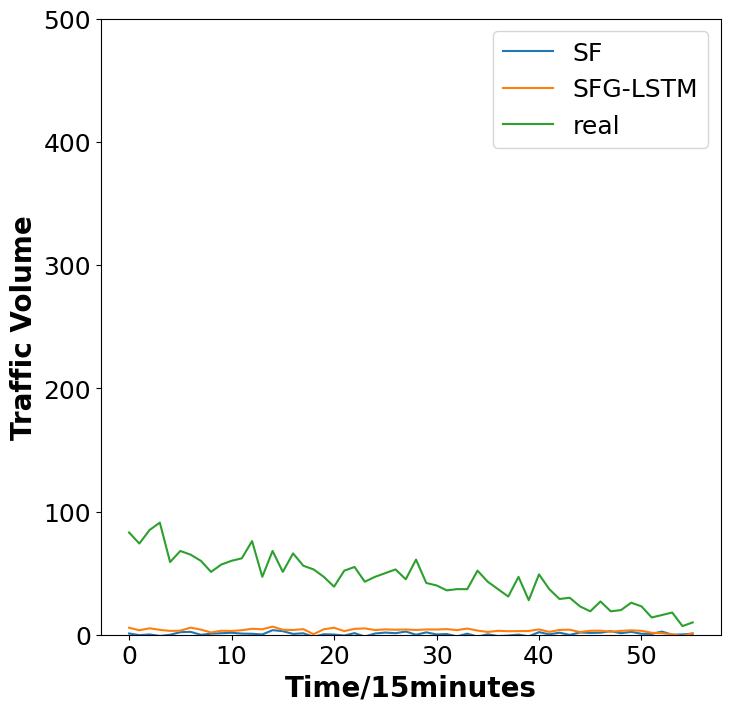

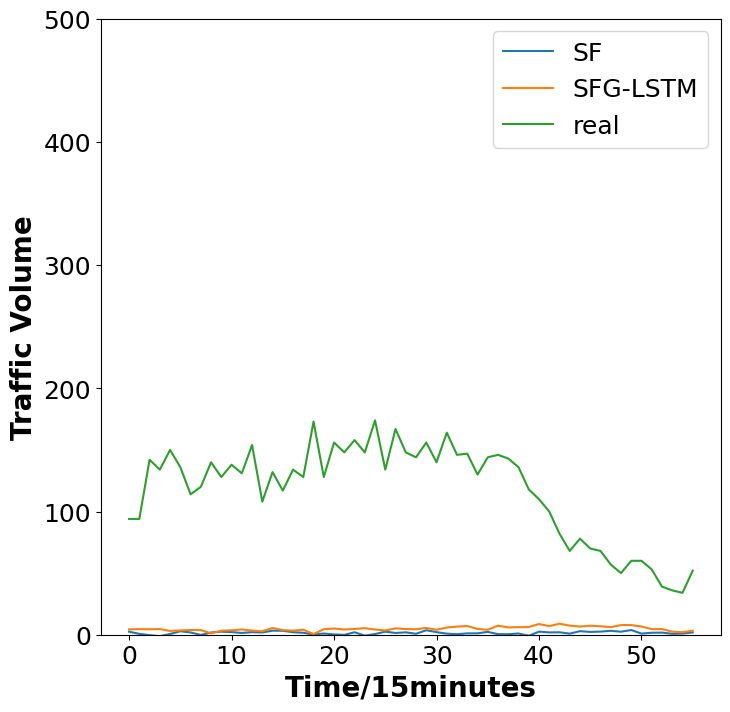

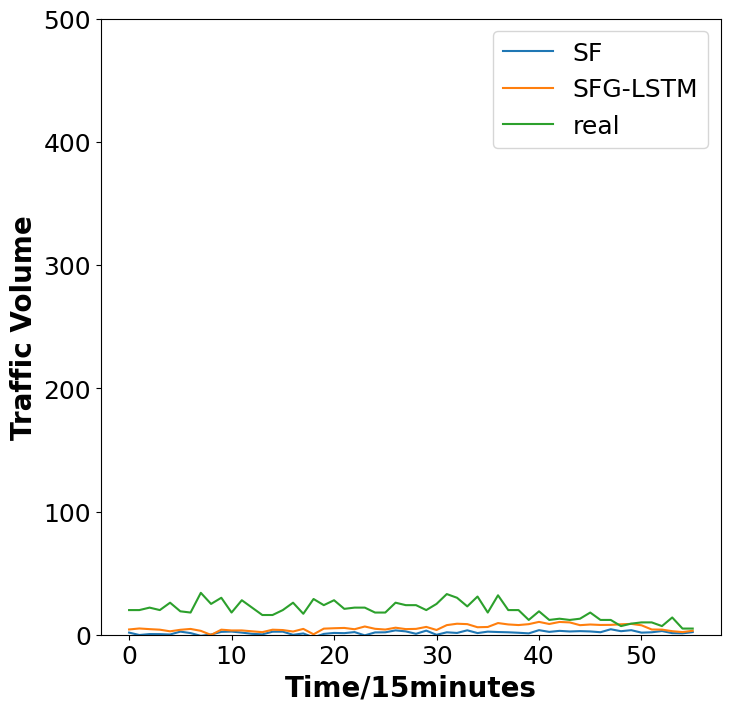

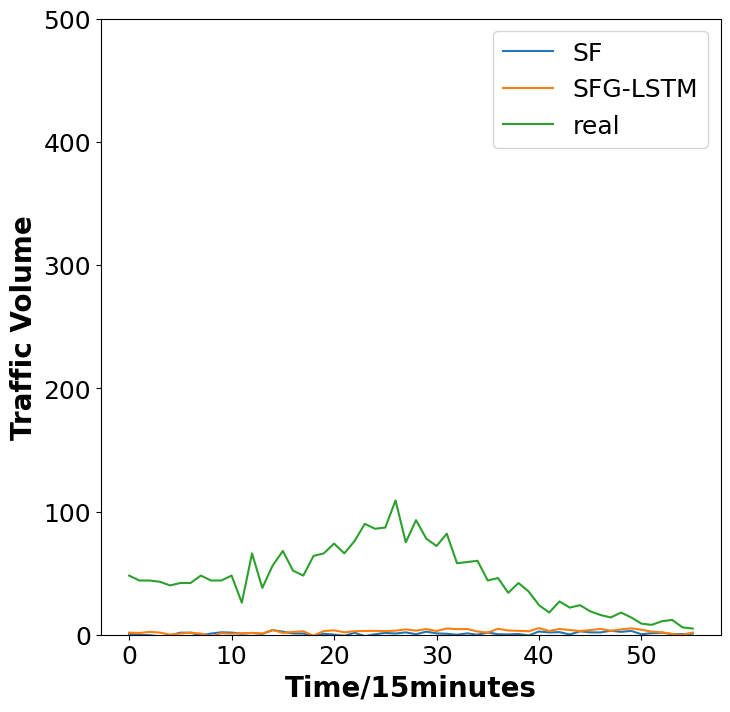

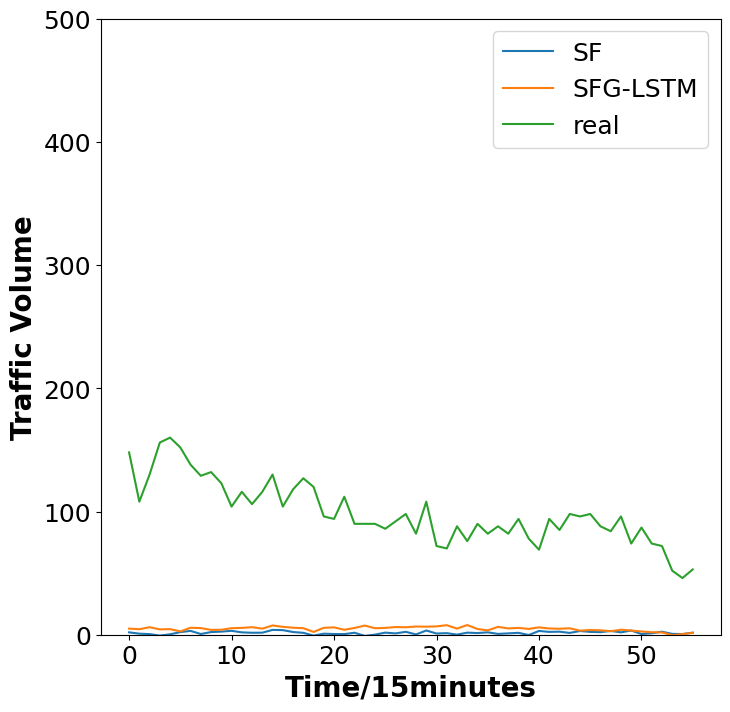

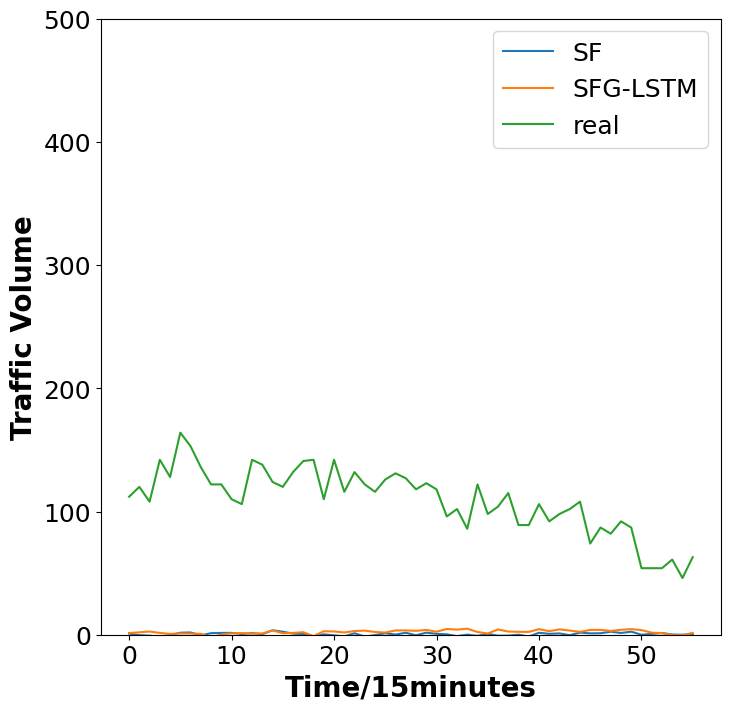

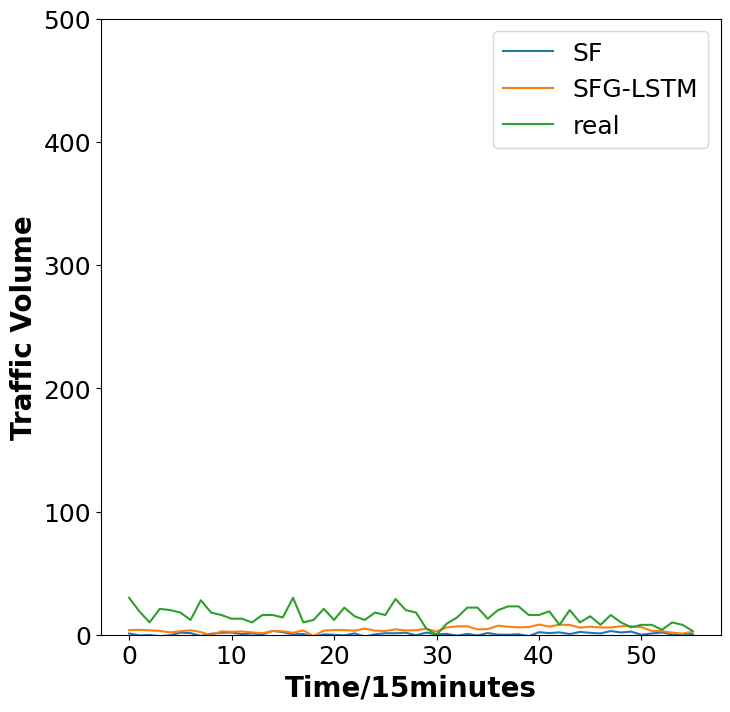

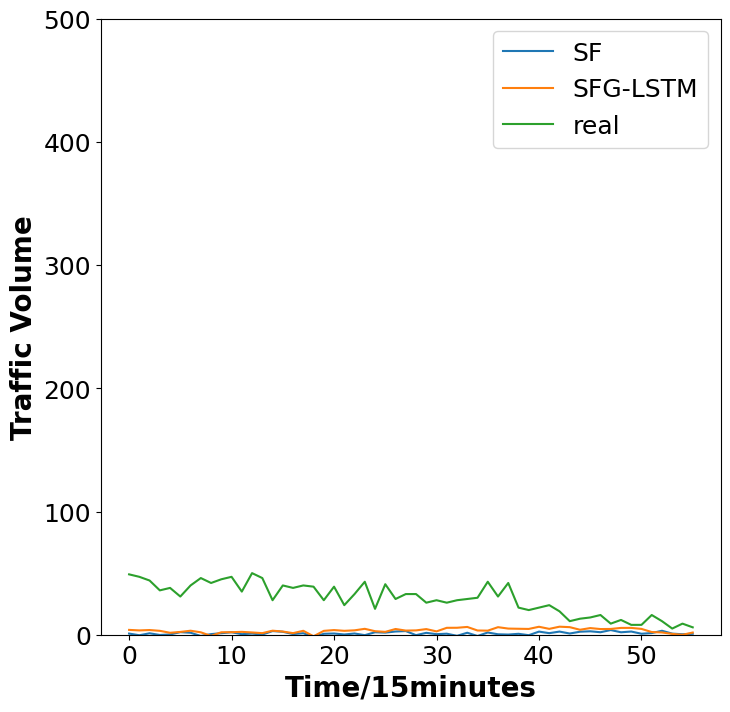

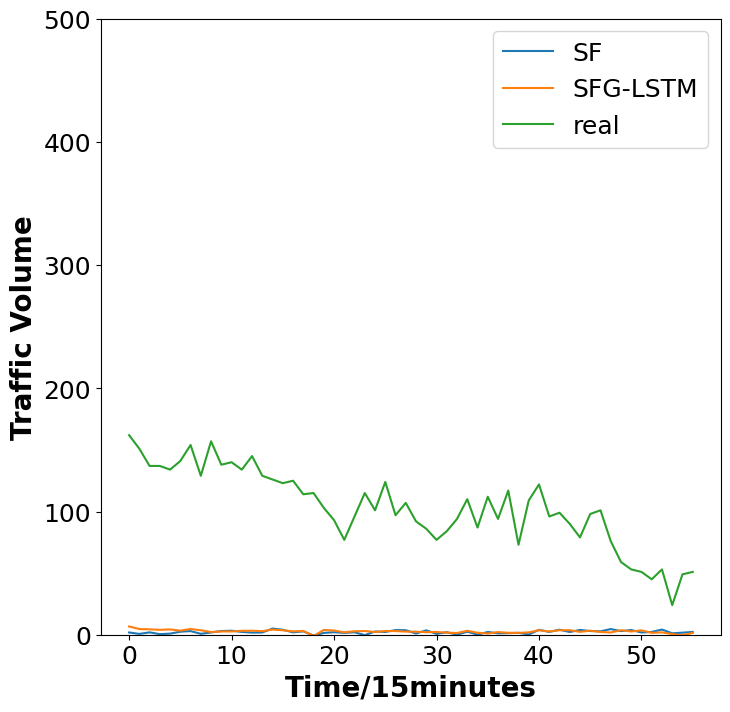

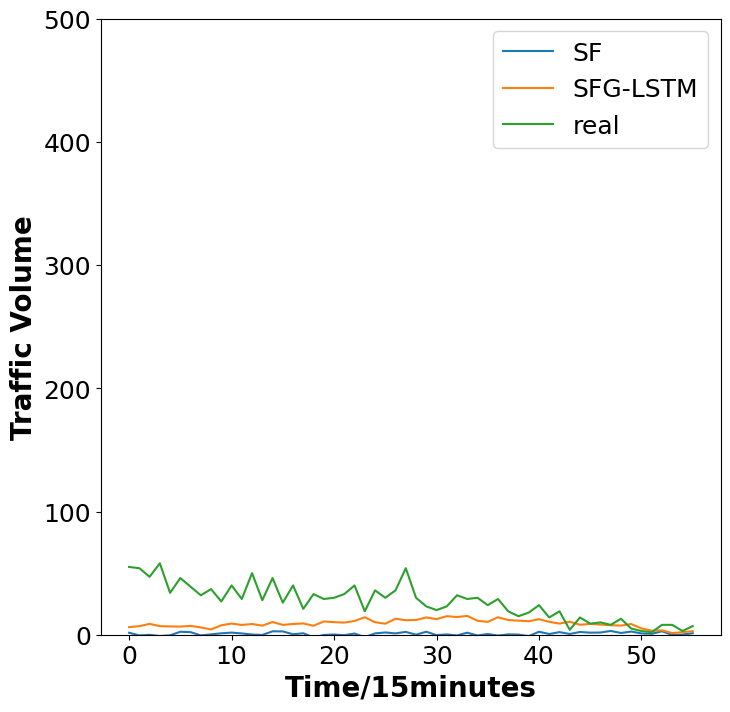

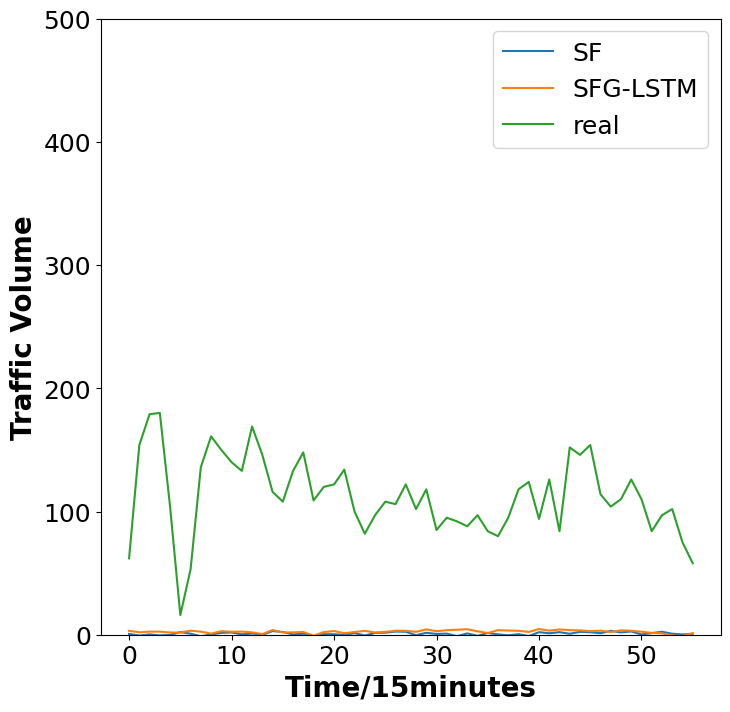

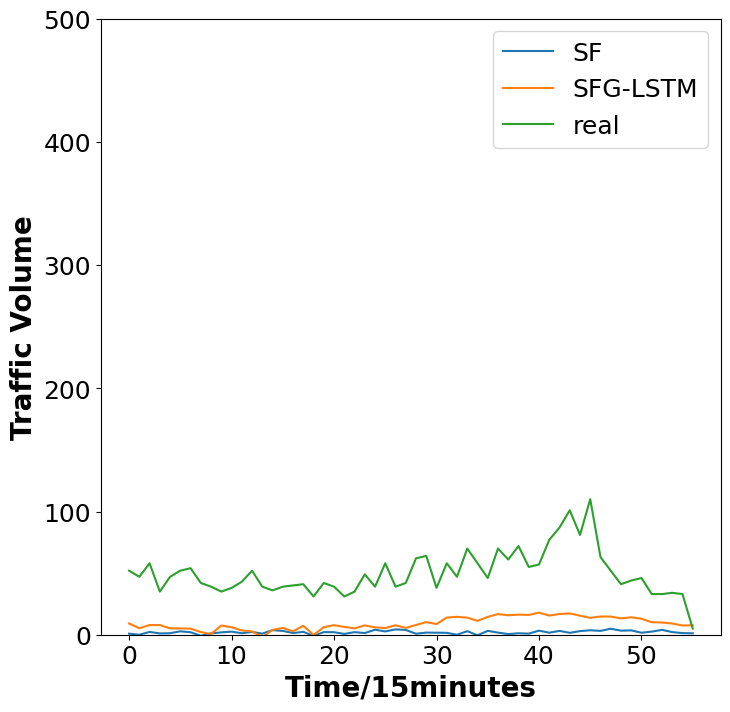

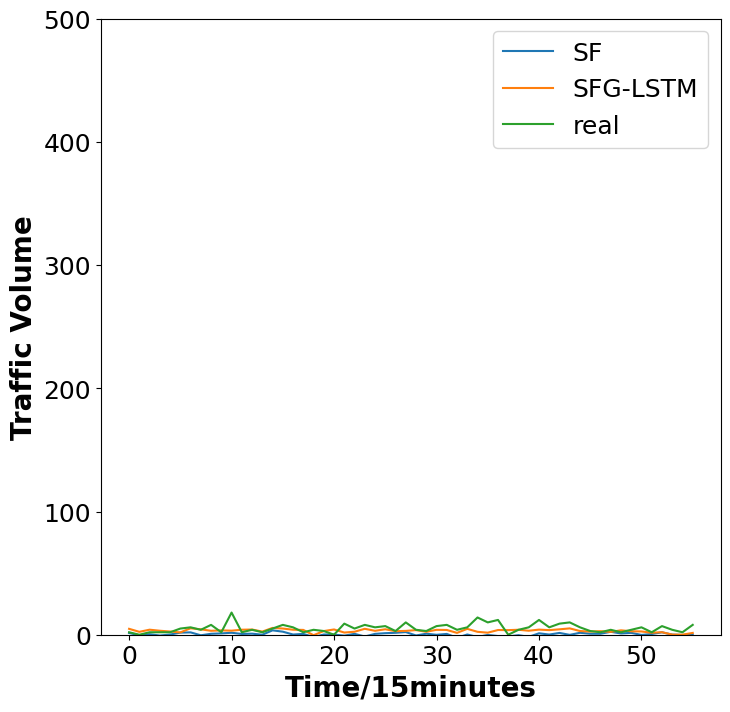

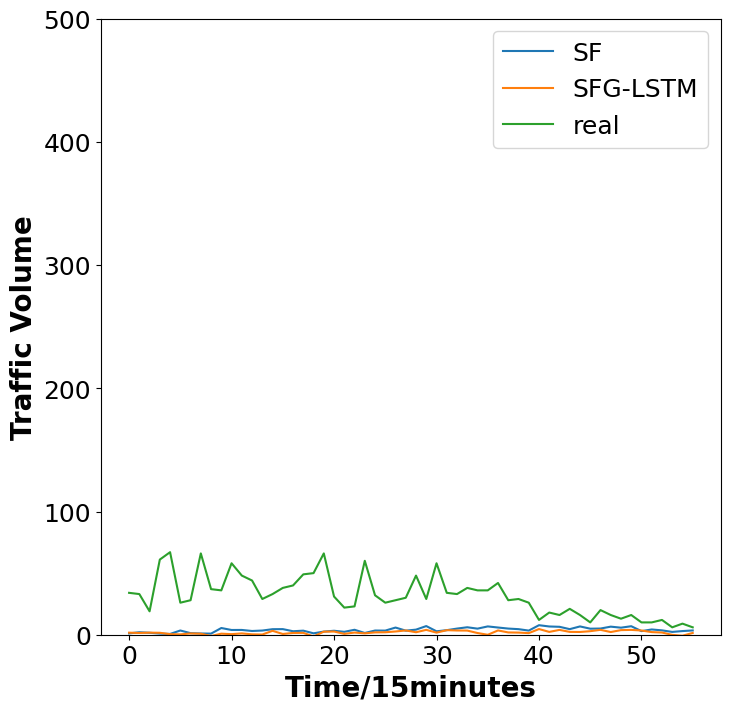

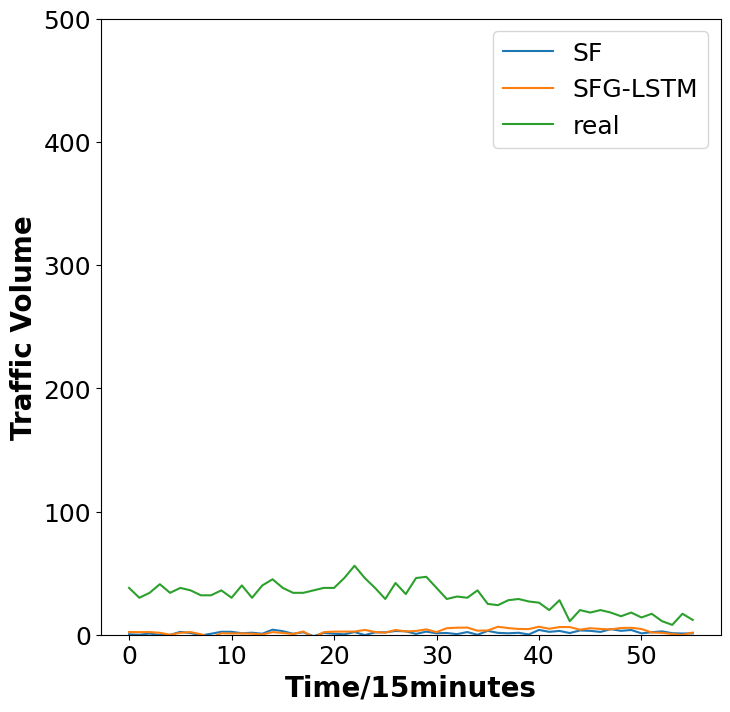

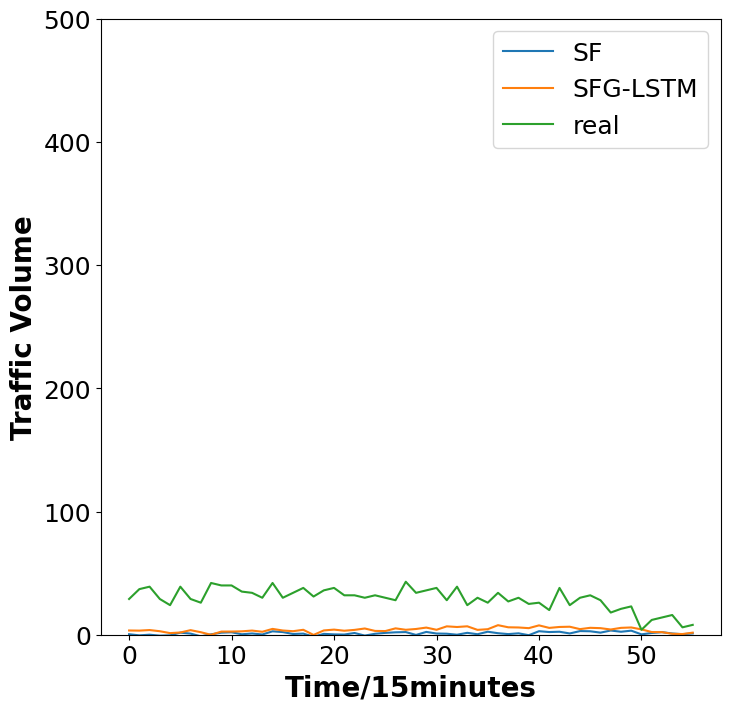

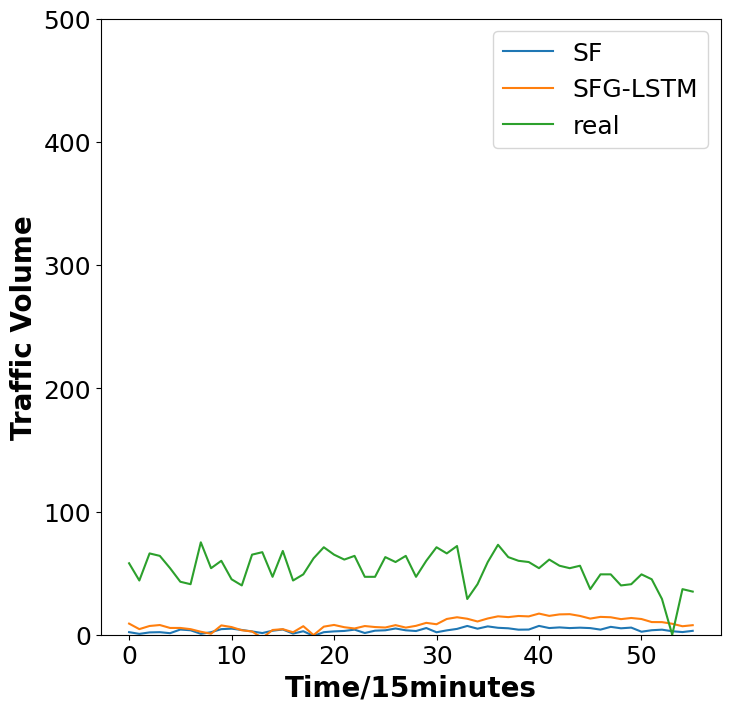

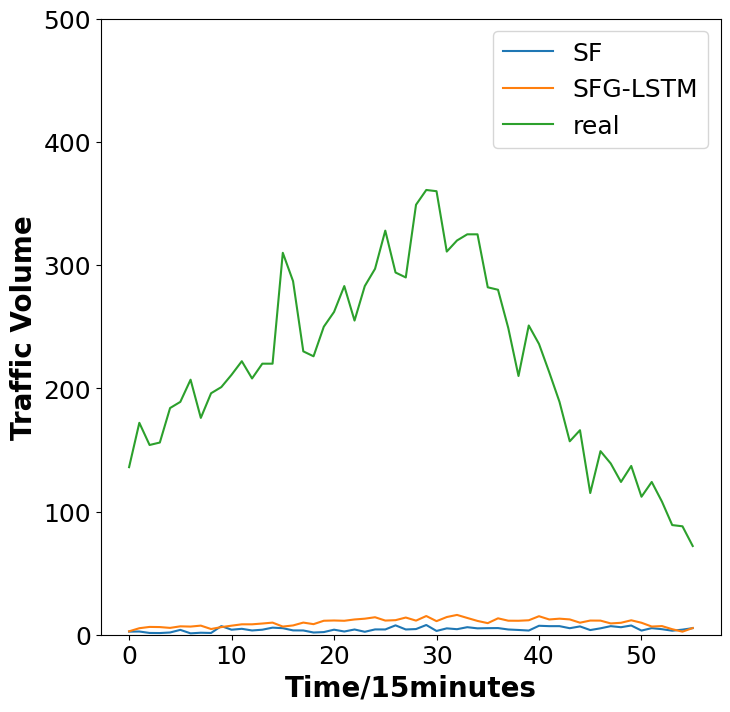

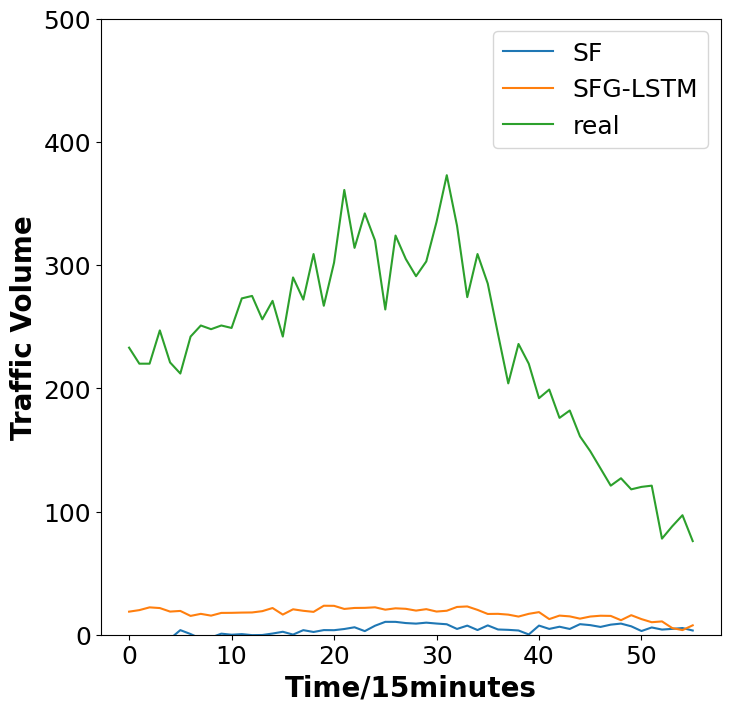

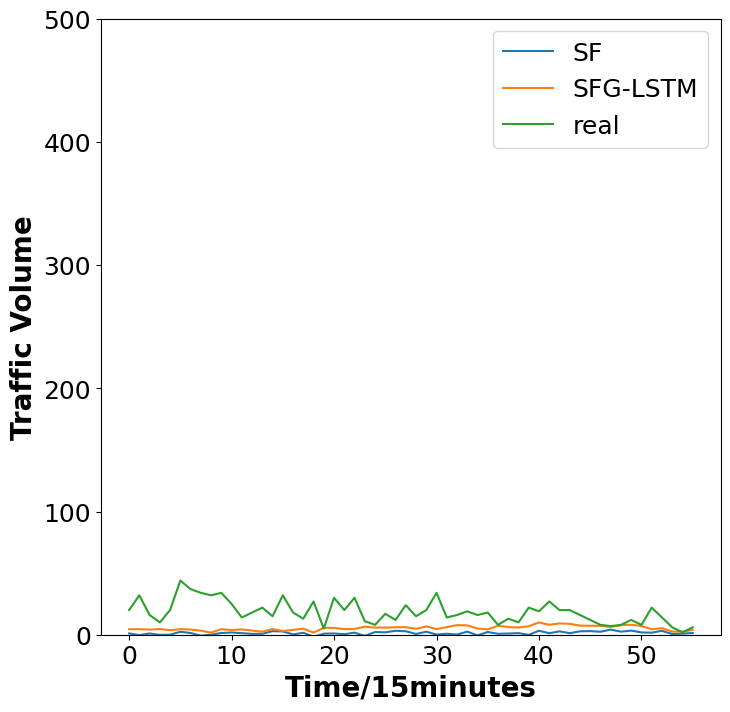

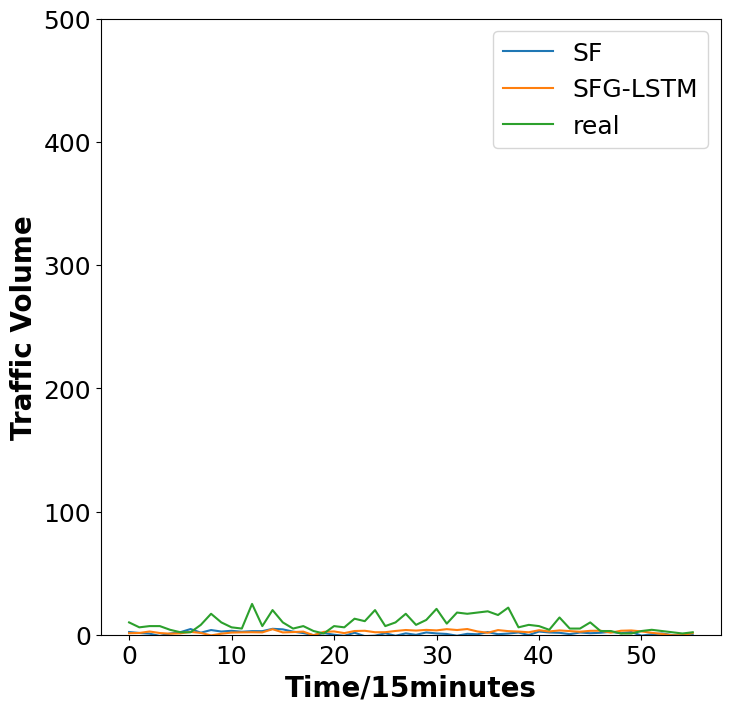

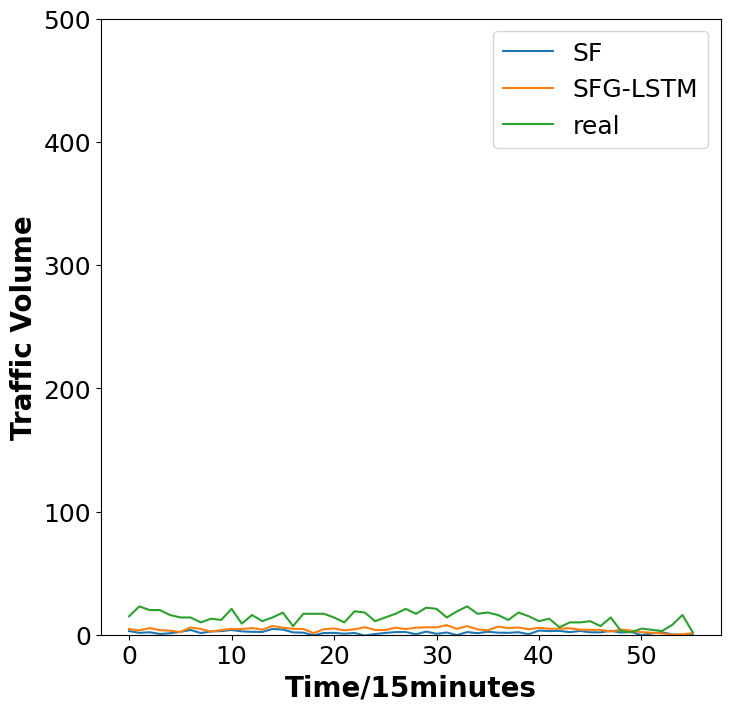

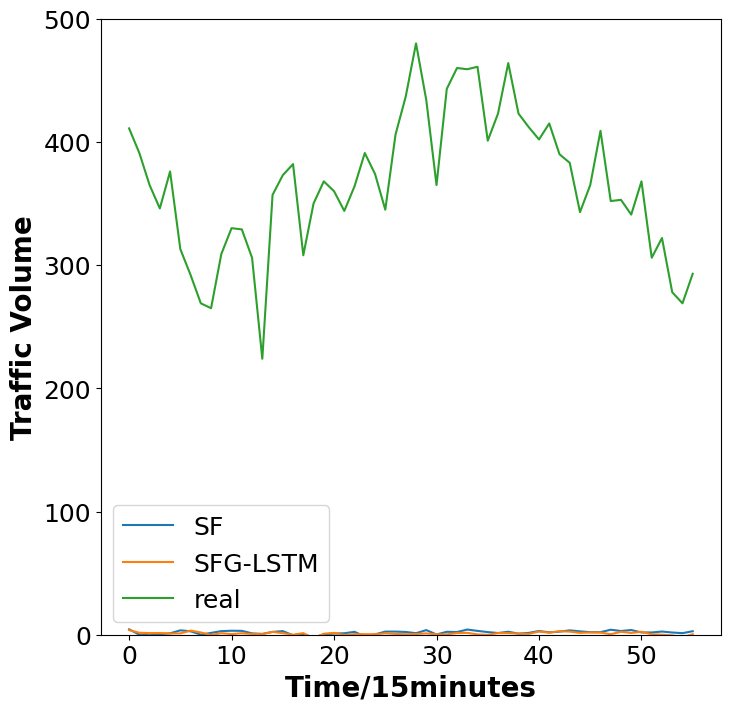

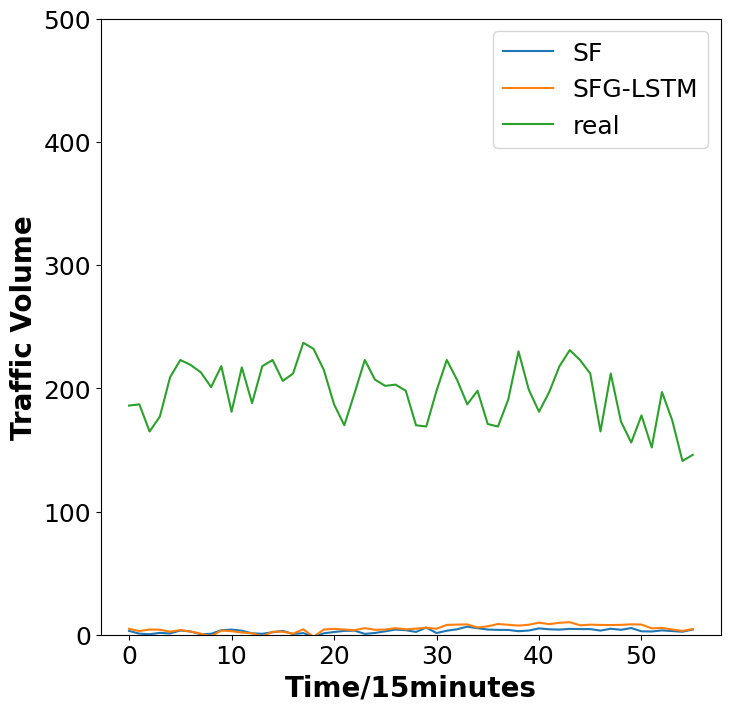

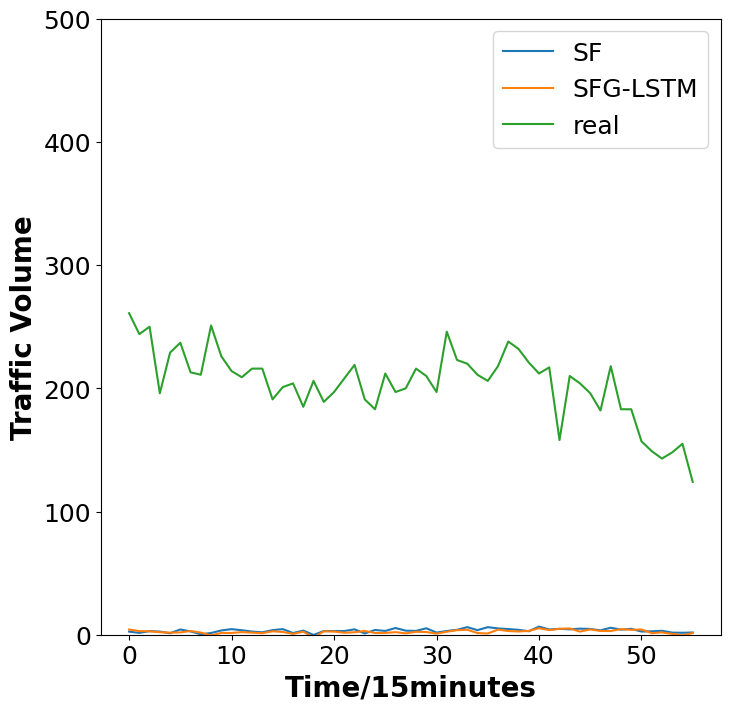

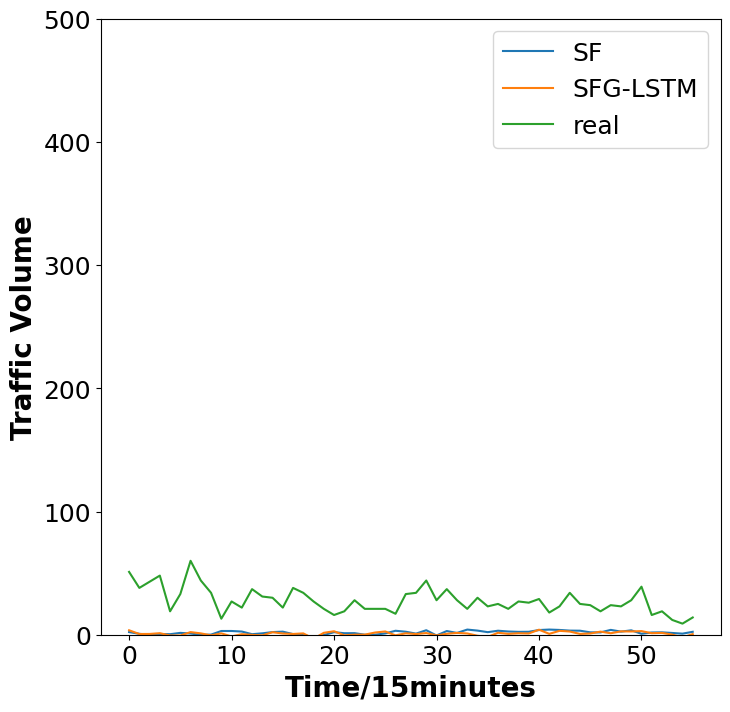

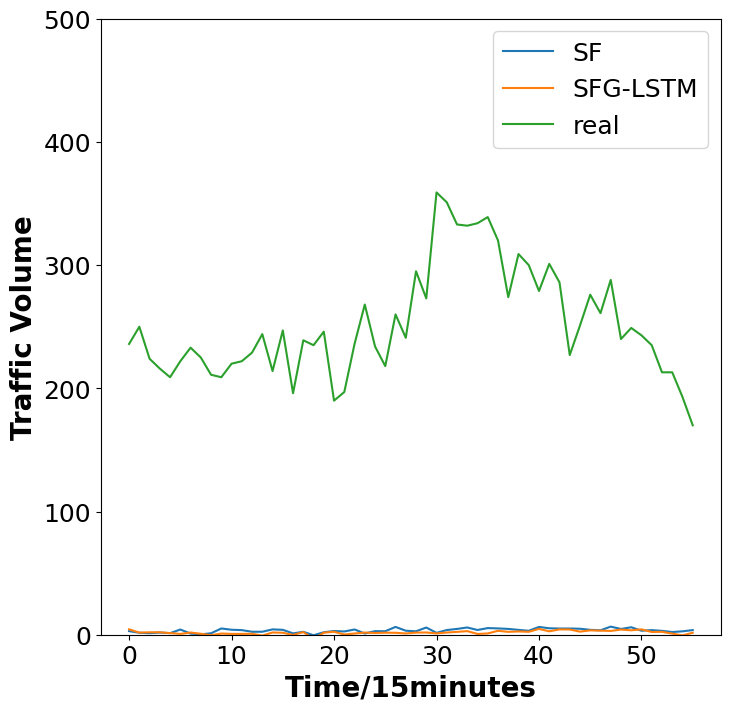

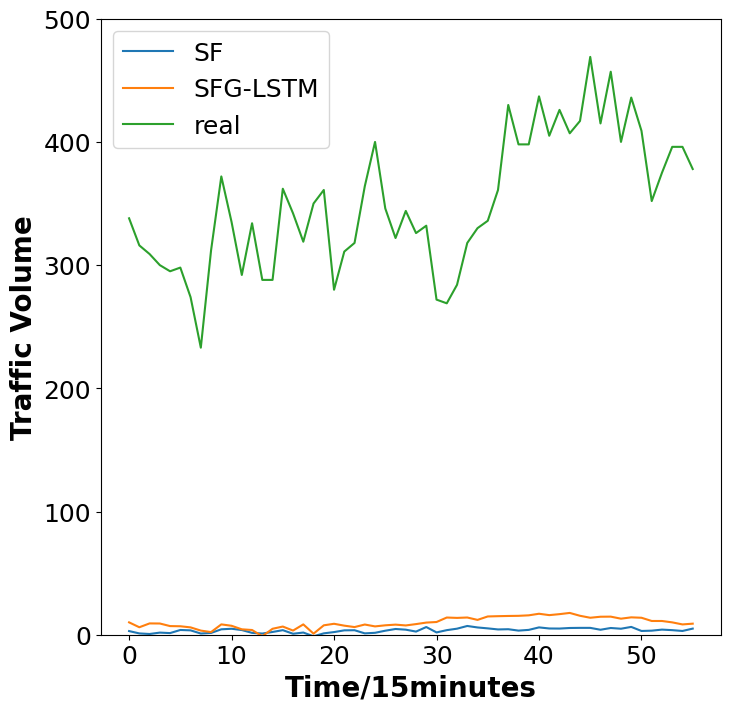

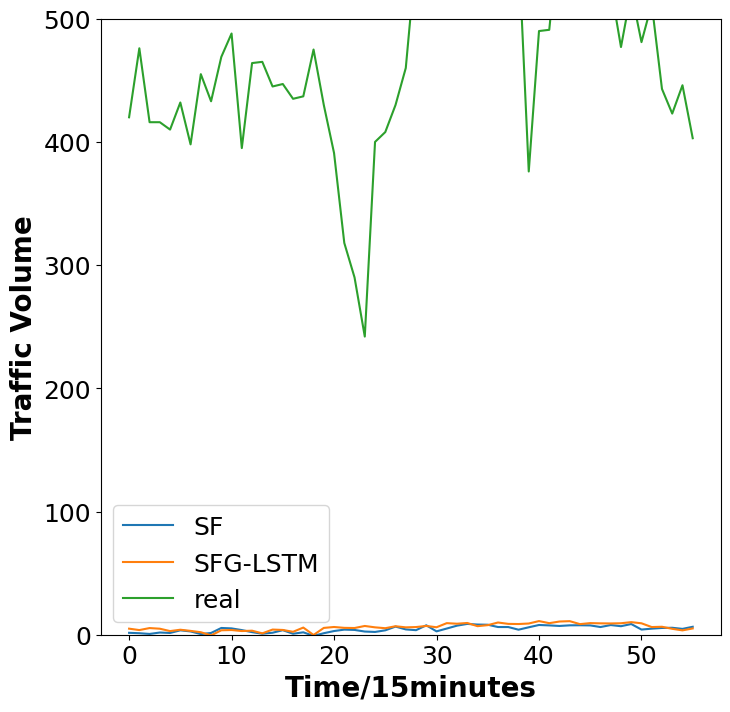

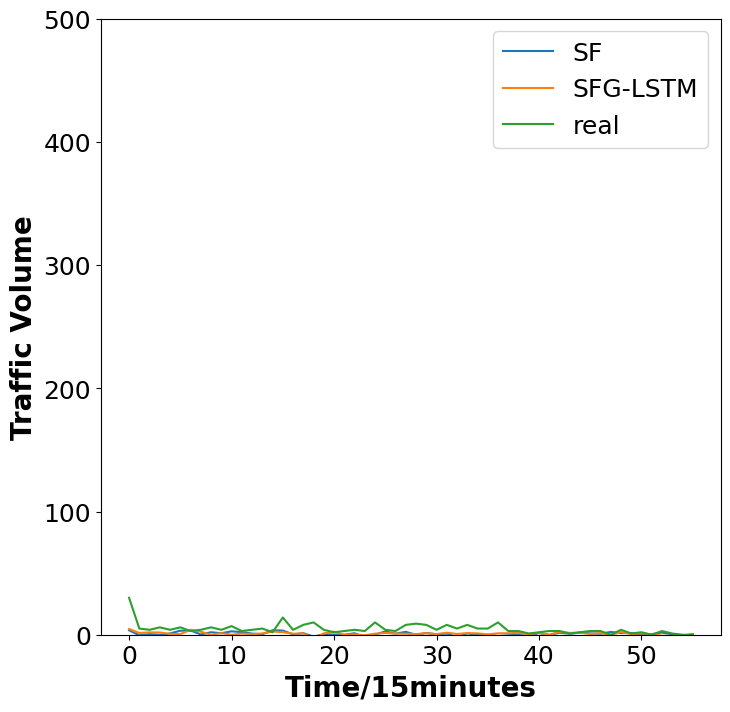

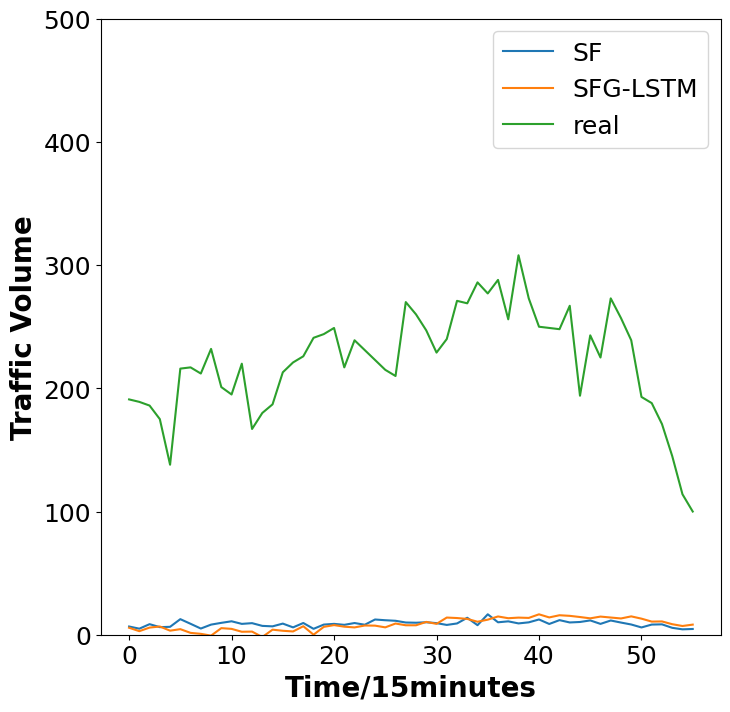

In [88]:
for i in range(100):
    mask_1 = batch.y[:, 0] != -1
    a1 = out1[mask_1][i]* 150 + 139
    a2 = out2[mask_1][i]* 150 + 139
    b = batch.y[mask_1][i]* 150 + 139

    plt.figure(figsize=(8, 8))
    plt.plot(a1.cpu().detach().numpy(), label='SF')
    plt.plot(a2.cpu().detach().numpy(), label='SFG-LSTM')
    plt.plot(b.cpu().detach().numpy(), label='real')
    plt.xlabel('Time/15minutes', fontdict=font)
    plt.ylabel('Traffic Volume',fontdict=font)
    plt.ylim((0, 500))
    plt.rcParams.update({'font.size': 18})
    plt.legend()
    plt.savefig(os.path.join(r'../Figure/Examples/', str(mmm) + '_' + str(i) + '.png'), pci=300)

### Train without scoioeconomic features

In [187]:
class Net3(torch.nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        
        self.num_layers = 1
        
# #         street view images features extraction
#         self.svi1 = nn.Linear(256 * 64 * 64, 256)
#         self.svi2 = nn.Linear(256, 128)
#         self.svi3 = nn.Linear(128, 128)
        
# #         remote sensing images features extraction
#         self.rm1 = nn.Linear(256 * 64 * 64, 256)
#         self.rm2 = nn.Linear(256, 128)
#         self.rm3 = nn.Linear(128, 128)
        
#         road segment features extraction
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        self.sep3_2 = nn.Linear(365, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        self.sep7 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(128, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

        self.lstm1 = nn.LSTM(20, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(128, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 64)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(64, 56)
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
#         x_road = x_all[:, 1:3]
#         x_location = x_all[:,3:16]
#         x_se = x_all[:, 16:56]
        x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

#         x_road = self.sep1(x_road)
#         x_road = F.sigmoid(x_road)
#         x_road = self.sep4(x_road)
#         x_road = F.relu(x_road)
        
#         x_location = self.sep2(x_location)
#         x_location = F.sigmoid(x_location)
#         x_location = self.sep5(x_location)
#         x_location = F.relu(x_location)
        
#         x_se = self.sep3(x_se)
#         x_se = F.sigmoid(x_se)
#         x_se = self.sep6(x_se)
#         x_se = F.relu(x_se)
        
#         **************SVI********************************
        x_svi = self.sep3_2(x_svi)
        x_svi = F.relu(x_svi)
        x_svi = self.sep7(x_svi)
        x_svi = F.relu(x_svi)
        
#         x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
#         x = torch.cat((x_road, x_location, x_se), 1)
    
        x = self.conv1(x_svi, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

        _, (hn, _) = self.lstm1(t, (h0, c0))

        t = hn[0]
        x = torch.cat((x, t), 1)
        
        x = self.linear1(x)
        x = F.relu(x)
#         x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return x

In [184]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = Net3().to(device)

learning_rate = 0.001
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
# loss_function = MAPE()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [185]:
# model = Net().to(device)
# model.load_state_dict(torch.load(r'../Weights/best.pt'))
epoch = 300


train_loss_list = []
val_loss_list = []

train_loss_percentage_list = []
val_loss_percentage_list = []


for i in range(epoch):
    
    print('------------' + str(i) + '-------------')
    train_loss = []
    validation_loss = []
    train_loss_percentage = []
    validation_loss_percentage = []
    best = 100000000
    best_path = r'../Weights_nose/best.pt'
    
    
    
    for batch in tqdm(training_dataloader):

        optimizer.zero_grad()
        batch.to(device)
        out = model(batch)
#         print(out)

#         l = loss_function(out, batch.y[10:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]
    
    
        l = MAPE(out[mask_1], real)
#         print(l)
        l.backward()
        optimizer.step()

        train_loss.append(l.tolist())
#         train_loss_percentage.append(l.tolist()/(batch.y[train_mask].mean().tolist()+0.000001)) 

    
    with torch.no_grad():
        for batch in validation_dataloader:
            batch.to(device)
            out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
            mask_1 = batch.y[:, 0] != -1
            real = batch.y[mask_1]
    
    
            loss_val = MAPE(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)
    
            
            validation_loss.append(loss_val.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
                
    train_loss = np.array(train_loss)
#     train_loss_percentage = np.array(train_loss_percentage)

    train_loss = train_loss[~pd.isnull(train_loss)].tolist()
#     train_loss_percentage = train_loss_percentage[~pd.isnull(train_loss_percentage)].tolist()
    
    

    validation_loss = np.array(validation_loss)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_train_loss = sum(train_loss)/len(train_loss)
    average_val_loss = sum(validation_loss)/len(validation_loss)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)
#     average_val_loss_percentage = sum(validation_loss_percentage)/len(validation_loss_percentage)
    
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)
#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('Trainning loss is: ' + str(average_train_loss) + '    , validation loss is: ' + str(average_val_loss))
#     print('Trainning loss p is: ' + str(average_train_loss_percentage) + '    , validation p loss is: ' + str(average_val_loss_percentage))

    
    if average_val_loss < best:
        best = average_val_loss
        torch.save(model.state_dict(), best_path)
    if i%5 == 0:
        epoch_path = os.path.join(r'../Weights_nose/', str(i) + '_3.pt')
        torch.save(model.state_dict(), epoch_path)

------------0-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 1.7269705596723055    , validation loss is: 0.8574051525857713
------------1-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.6416976883223182    , validation loss is: 0.5597788294156393
------------2-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.5089358405063027    , validation loss is: 0.5141154809130563
------------3-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.4683003958902861    , validation loss is: 0.4802096900012758
------------4-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.4425481479418905    , validation loss is: 0.4760146703985002
------------5-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.43049309206636327    , validation loss is: 0.4610712809695138
------------6-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.42890877629581253    , validation loss is: 0.4620155642429988
------------7-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.4132226282044461    , validation loss is: 0.43472251461611855
------------8-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.05it/s]


Trainning loss is: 0.39992731025344447    , validation loss is: 0.4208171003394657
------------9-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.40061614780049576    , validation loss is: 0.423414033320215
------------10-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.39599431502191645    , validation loss is: 0.4189160548978382
------------11-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.3847523935531315    , validation loss is: 0.4192059553331799
------------12-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.383942153893019    , validation loss is: 0.40068140129248303
------------13-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.21it/s]


Trainning loss is: 0.384785143168349    , validation loss is: 0.4113035947084427
------------14-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.4014360951749902    , validation loss is: 0.43580707907676697
------------15-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.3992412607920797    , validation loss is: 0.3901856972111596
------------16-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.3823781946772023    , validation loss is: 0.3794048834178183
------------17-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.12it/s]


Trainning loss is: 0.36326249884931666    , validation loss is: 0.3846687666243977
------------18-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.36996233502500936    , validation loss is: 0.4299214051829444
------------19-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.3607691302895546    , validation loss is: 0.38940368923876023
------------20-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.3555024987772891    , validation loss is: 0.3710000581211514
------------21-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.35369148066169337    , validation loss is: 0.3650914165708754
------------22-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.3528606472046752    , validation loss is: 0.3611331052250332
------------23-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.35580233484506607    , validation loss is: 0.3890312810738881
------------24-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.34400929549806997    , validation loss is: 0.39893103308147854
------------25-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.3677131670870279    , validation loss is: 0.39531051615873974
------------26-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.35380414991002335    , validation loss is: 0.3638364349802335
------------27-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.33309061433139603    , validation loss is: 0.3541826208432515
------------28-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.3239090113263381    , validation loss is: 0.3397154418958558
------------29-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.3336900880462245    , validation loss is: 0.3621057454082701
------------30-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.32721659697984395    , validation loss is: 0.3624475830131107
------------31-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.3193846737083636    , validation loss is: 0.33569194707605576
------------32-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.3203677127235814    , validation loss is: 0.3401280716061592
------------33-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.3130192901743086    , validation loss is: 0.3527683855758773
------------34-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.31502962465349    , validation loss is: 0.34609565883874893
------------35-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]


Trainning loss is: 0.3163869627996495    , validation loss is: 0.34320228464073604
------------36-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.3081127534571447    , validation loss is: 0.3501535654067993
------------37-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.31027566014151825    , validation loss is: 0.33096906542778015
------------38-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.3109422090806459    , validation loss is: 0.35075757735305363
------------39-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.3162495674271333    , validation loss is: 0.32706160346666974
------------40-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.3059294862966788    , validation loss is: 0.3321169109808074
------------41-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.3061709086361684    , validation loss is: 0.3273872683445613
------------42-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.30424326854316813    , validation loss is: 0.3225320428609848
------------43-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.32418815830820485    , validation loss is: 0.36534132063388824
------------44-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.30242547079136495    , validation loss is: 0.3157065676318275
------------45-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.29506883456518773    , validation loss is: 0.3190112950073348
------------46-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2968220177449678    , validation loss is: 0.3198919478389952
------------47-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.29682368589074987    , validation loss is: 0.35346023738384247
------------48-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.304003701790383    , validation loss is: 0.32658327453666264
------------49-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.295644411915227    , validation loss is: 0.32836900485886467
------------50-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.3012321469815154    , validation loss is: 0.33135343177451027
------------51-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.29523586168100957    , validation loss is: 0.3184121573964755
------------52-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2927930574668081    , validation loss is: 0.31345435314708286
------------53-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2923426290875987    , validation loss is: 0.31613025565942127
------------54-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2884718752221057    , validation loss is: 0.31407729619079167
------------55-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2883518071551072    , validation loss is: 0.3118656418389744
------------56-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2861580707524952    , validation loss is: 0.3167498889896605
------------57-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  3.99it/s]


Trainning loss is: 0.2886513342198573    , validation loss is: 0.31357783410284257
------------58-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2860869071201274    , validation loss is: 0.30821432173252106
------------59-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.29it/s]


Trainning loss is: 0.2922789752483368    , validation loss is: 0.3100368024574386
------------60-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.28238499243008464    , validation loss is: 0.31208738601870006
------------61-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2822694449048293    , validation loss is: 0.30757611493269604
------------62-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.28655180844821426    , validation loss is: 0.3173935015996297
------------63-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2843403039794219    , validation loss is: 0.30321327017413247
------------64-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.28191839746738734    , validation loss is: 0.30862247778309715
------------65-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2815677856928424    , validation loss is: 0.30492453856600654
------------66-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.32it/s]


Trainning loss is: 0.2797485511553915    , validation loss is: 0.3049336299300194
------------67-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.27880905450958954    , validation loss is: 0.31453730745448005
------------68-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.27619136791480214    , validation loss is: 0.3071663760476642
------------69-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2779015228152275    , validation loss is: 0.30220861319038606
------------70-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.27793042165668386    , validation loss is: 0.30667560050884884
------------71-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.28353624202703176    , validation loss is: 0.30067361146211624
------------72-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.27357736073042216    , validation loss is: 0.30375589099195266
------------73-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.27607425341480657    , validation loss is: 0.3051406964659691
------------74-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.2728002008638884    , validation loss is: 0.30445365028248894
------------75-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2746600759656806    , validation loss is: 0.30530595862203175
------------76-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.27132299385572733    , validation loss is: 0.3033951711323526
------------77-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.27301147109583807    , validation loss is: 0.30168841116958195
------------78-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2749851342094572    , validation loss is: 0.30070540722873473
------------79-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2686928593014416    , validation loss is: 0.2956368128458659
------------80-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.2685540079286224    , validation loss is: 0.3014431827598148
------------81-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2682052286047685    , validation loss is: 0.29989942494365907
------------82-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.270263897353097    , validation loss is: 0.30066227250629
------------83-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2703571562704287    , validation loss is: 0.2985894713136885
------------84-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2722865754836484    , validation loss is: 0.29632549898491967
------------85-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.26616448595335607    , validation loss is: 0.3005005005333159
------------86-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2662513044319655    , validation loss is: 0.2961020718018214
------------87-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.26506420224905014    , validation loss is: 0.296565012799369
------------88-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.26475920802668523    , validation loss is: 0.29907437082793975
------------89-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2642111786101994    , validation loss is: 0.29627012295855415
------------90-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.26615304303796666    , validation loss is: 0.297418426308367
------------91-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2697436095852601    , validation loss is: 0.2992423118816482
------------92-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2710476662767561    , validation loss is: 0.29583435753981274
------------93-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.26548614784290914    , validation loss is: 0.300369031727314
------------94-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.26462817741067785    , validation loss is: 0.3012745264503691
------------95-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2632007598876953    , validation loss is: 0.2967873199118508
------------96-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2650444962476429    , validation loss is: 0.2967450792590777
------------97-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.26156272190181834    , validation loss is: 0.2962331490384208
------------98-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.26576939303624003    , validation loss is: 0.3021584740943379
------------99-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.26354154865992696    , validation loss is: 0.29730962382422554
------------100-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.2581864779717044    , validation loss is: 0.29579317155811524
------------101-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.26491864966718776    , validation loss is: 0.29718757917483646
------------102-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.25922189731346934    , validation loss is: 0.30366068250603145
------------103-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.26333831721230555    , validation loss is: 0.29932724518908393
------------104-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2638417486297457    , validation loss is: 0.2992391561468442
------------105-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.26193048726571233    , validation loss is: 0.29971422337823445
------------106-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.26259426694167287    , validation loss is: 0.29941075791915256
------------107-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2634437503783326    , validation loss is: 0.3000452104541991
------------108-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2606040113850644    , validation loss is: 0.30055592871374553
------------109-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.26135350646157013    , validation loss is: 0.30792206443018383
------------110-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.25921361814988286    , validation loss is: 0.30209960291783017
------------111-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.25881287259490865    , validation loss is: 0.30395355489518905
------------112-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.25922524419270065    , validation loss is: 0.30285201221704483
------------113-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2594752417583215    , validation loss is: 0.303503838678201
------------114-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.25989984211168793    , validation loss is: 0.2975854045814938
------------115-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]


Trainning loss is: 0.2574734511344056    , validation loss is: 0.2966665741470125
------------116-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2547563181111687    , validation loss is: 0.3004800081253052
------------117-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2585504333439626    , validation loss is: 0.30096281733777785
------------118-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.25838343603046315    , validation loss is: 0.3039294381936391
------------119-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.25566412233992625    , validation loss is: 0.29638368388017017
------------120-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.25419157665026815    , validation loss is: 0.29569055885076523
------------121-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.21it/s]


Trainning loss is: 0.2534025436953494    , validation loss is: 0.29927312913868165
------------122-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2566934984765555    , validation loss is: 0.29830460581514573
------------123-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2563548142972745    , validation loss is: 0.2993691952692138
------------124-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.25377113019165237    , validation loss is: 0.297202751868301
------------125-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.25387377213490636    , validation loss is: 0.30174829810857773
------------126-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2586754093828954    , validation loss is: 0.3156568441126082
------------127-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2557283639907837    , validation loss is: 0.29895590245723724
------------128-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.25274599696460526    , validation loss is: 0.30085307359695435
------------129-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.25312158739880514    , validation loss is: 0.3090694596370061
------------130-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2515626663440152    , validation loss is: 0.30057988315820694
------------131-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.25175353178852483    , validation loss is: 0.3040303968720966
------------132-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.25384173267766047    , validation loss is: 0.30389532032940125
------------133-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.25186057153501007    , validation loss is: 0.31072699940866894
------------134-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2516210557598817    , validation loss is: 0.3013366510470708
------------135-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2518296884863    , validation loss is: 0.2952095824811194
------------136-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24941879746161008    , validation loss is: 0.30188002934058505
------------137-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.25072326903280456    , validation loss is: 0.3044660993748241
------------138-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2525611813915403    , validation loss is: 0.3062933170133167
------------139-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.25109158181830454    , validation loss is: 0.303363555835353
------------140-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2516104092723445    , validation loss is: 0.2981118866138988
------------141-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.24915541590828644    , validation loss is: 0.30359825326336753
------------142-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24749388820246646    , validation loss is: 0.2999400777949227
------------143-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2511457424414785    , validation loss is: 0.3083851652012931
------------144-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24948573739905106    , validation loss is: 0.30420872817436856
------------145-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24906261147637115    , validation loss is: 0.30705128610134125
------------146-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.24921684908239464    , validation loss is: 0.3021136050422986
------------147-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.24760698683952032    , validation loss is: 0.29978009478913414
------------148-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24584896039021642    , validation loss is: 0.2994816791680124
------------149-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.24693426411402852    , validation loss is: 0.29945360620816547
------------150-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2446302053959746    , validation loss is: 0.30045024388366276
------------151-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2506712396678172    , validation loss is: 0.3011828454004394
------------152-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2536288225337079    , validation loss is: 0.3137221684058507
------------153-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.24776755312555715    , validation loss is: 0.3019356338514222
------------154-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24880686637602353    , validation loss is: 0.2997821494936943
------------155-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24440586998274452    , validation loss is: 0.30174077302217484
------------156-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24599451571702957    , validation loss is: 0.3054577617181672
------------157-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.24502734369353243    , validation loss is: 0.3001556462711758
------------158-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24613891345889946    , validation loss is: 0.3070641921626197
------------159-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2441820988529607    , validation loss is: 0.30554914722839993
------------160-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.24284424672001287    , validation loss is: 0.29914235489235985
------------161-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24314764887094498    , validation loss is: 0.2997874385780758
------------162-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2428261672979907    , validation loss is: 0.3038749968012174
------------163-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2432623054636152    , validation loss is: 0.29949188729127246
------------164-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24242255875938817    , validation loss is: 0.29760178095764583
------------165-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.25208497047424316    , validation loss is: 0.309391174879339
------------166-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.24579590088442752    , validation loss is: 0.2997114368610912
------------167-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.24583875897683596    , validation loss is: 0.30660657833019894
------------168-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.24537114563741183    , validation loss is: 0.30491994818051654
------------169-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2437545602258883    , validation loss is: 0.3146378778749042
------------170-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2443236402775112    , validation loss is: 0.30794234325488407
------------171-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24089362276227852    , validation loss is: 0.2983205657866266
------------172-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24130029035241982    , validation loss is: 0.31035549690326053
------------173-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.24214494306790202    , validation loss is: 0.30418475882874596
------------174-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24098163254951177    , validation loss is: 0.3033805663386981
------------175-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.2401086590007732    , validation loss is: 0.3052419258488549
------------176-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24048636657627007    , validation loss is: 0.31511464797788197
------------177-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24202765877309598    , validation loss is: 0.30071167565054363
------------178-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.27it/s]


Trainning loss is: 0.2475840786569997    , validation loss is: 0.31214480184846455
------------179-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.18it/s]


Trainning loss is: 0.24228173259057498    , validation loss is: 0.3164594935046302
------------180-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24538562211551165    , validation loss is: 0.30887286944521797
------------181-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.23969958095174088    , validation loss is: 0.3091245980726348
------------182-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.24261390300173508    , validation loss is: 0.3057064670655463
------------183-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.23862492959750325    , validation loss is: 0.31154991851912606
------------184-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.12it/s]


Trainning loss is: 0.240540895022844    , validation loss is: 0.30942554192410576
------------185-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.24018002066173053    , validation loss is: 0.3087202575471666
------------186-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.23930111370588603    , validation loss is: 0.3070725467469957
------------187-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.2373800901205916    , validation loss is: 0.3083298123545117
------------188-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.24056574035631983    , validation loss is: 0.31281310154332054
------------189-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.2385680287292129    , validation loss is: 0.30366011212269467
------------190-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.17it/s]


Trainning loss is: 0.23929676452749654    , validation loss is: 0.31184114350212944
------------191-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.23813603426280774    , validation loss is: 0.3036428648564551
------------192-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.24630044792827807    , validation loss is: 0.3091059898336728
------------193-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.23980717557041267    , validation loss is: 0.30072716375192005
------------194-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2358337056479956    , validation loss is: 0.30345290650924045
------------195-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.23338835725658819    , validation loss is: 0.2950454577803612
------------196-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2346497519235862    , validation loss is: 0.30528761860397124
------------197-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.23917942415726812    , validation loss is: 0.3041866223017375
------------198-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.2331466517950359    , validation loss is: 0.3096430194046762
------------199-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.36it/s]


Trainning loss is: 0.23258550308252635    , validation loss is: 0.3047104908360375
------------200-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.23353842567456395    , validation loss is: 0.29921888891193604
------------201-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.23316879452843414    , validation loss is: 0.30078263415230644
------------202-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.23507516831159592    , validation loss is: 0.3013945097724597
------------203-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2357836797049171    , validation loss is: 0.30280811505185234
------------204-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.23447161952131673    , validation loss is: 0.2994648797644509
------------205-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.23273834742997823    , validation loss is: 0.29536614815394086
------------206-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.23210780165697398    , validation loss is: 0.3001662558979458
------------207-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.23474171718484477    , validation loss is: 0.30618414365582997
------------208-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.23523483307738052    , validation loss is: 0.3034997814231449
------------209-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.23465611119019358    , validation loss is: 0.30397335025999284
------------210-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]


Trainning loss is: 0.23168318091254486    , validation loss is: 0.3000546420613925
------------211-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.23036212121185504    , validation loss is: 0.3029143810272217
------------212-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.23161412540235018    , validation loss is: 0.29920938197109437
------------213-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2288022347186741    , validation loss is: 0.3017967823478911
------------214-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22874414724738976    , validation loss is: 0.29759780565897626
------------215-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2318917277612184    , validation loss is: 0.293790722058879
------------216-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22900291061715075    , validation loss is: 0.2968176661266221
------------217-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.22910831162804052    , validation loss is: 0.29669169584910077
------------218-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.22825515897650467    , validation loss is: 0.3014538925555017
------------219-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.23075243046409205    , validation loss is: 0.3026433073812061
------------220-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.10it/s]


Trainning loss is: 0.22851366196808062    , validation loss is: 0.3096660499771436
------------221-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.22839734193525815    , validation loss is: 0.3008234053850174
------------222-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.22it/s]


Trainning loss is: 0.2286915696765247    , validation loss is: 0.3001607656478882
------------223-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.22914835614593407    , validation loss is: 0.3014681546224488
------------224-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]


Trainning loss is: 0.23158281218064458    , validation loss is: 0.3019755408167839
------------225-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.23010090699321345    , validation loss is: 0.3047651938266224
------------226-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.23208081447764448    , validation loss is: 0.29779238750537235
------------227-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2281032847730737    , validation loss is: 0.30157167712847394
------------228-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22757302224636078    , validation loss is: 0.30164972527159584
------------229-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22921417810414968    , validation loss is: 0.3039497575826115
------------230-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2274625697418263    , validation loss is: 0.30292438301775193
------------231-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.22819440968726812    , validation loss is: 0.2938871449894375
------------232-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22851024019090752    , validation loss is: 0.29924899339675903
------------233-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.22805125540808627    , validation loss is: 0.29674356430768967
------------234-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2273924923256824    , validation loss is: 0.3046514242887497
------------235-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.22805701705970263    , validation loss is: 0.30218152619070476
------------236-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2284391283204681    , validation loss is: 0.3045142731732792
------------237-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22671358836324593    , validation loss is: 0.3050706990891033
------------238-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2267418060647814    , validation loss is: 0.3053068369626999
------------239-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.31it/s]


Trainning loss is: 0.2299902952815357    , validation loss is: 0.30546659810675514
------------240-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22832672219527395    , validation loss is: 0.30148710641596055
------------241-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.22667644721897026    , validation loss is: 0.30952538632684284
------------242-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22723108137908735    , validation loss is: 0.2925732342733277
------------243-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.22474616295412966    , validation loss is: 0.29725776695542866
------------244-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.22464385275778018    , validation loss is: 0.29205791652202606
------------245-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22510517702290886    , validation loss is: 0.297633885509438
------------246-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2274910333125215    , validation loss is: 0.2991749718785286
------------247-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22408527606411985    , validation loss is: 0.29641522881057525
------------248-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.22501573946915174    , validation loss is: 0.2967528642879592
------------249-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22573248257762507    , validation loss is: 0.3033616965015729
------------250-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22380186695801585    , validation loss is: 0.29655975186162525
------------251-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.23372136174063934    , validation loss is: 0.3031436676780383
------------252-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22635807371453234    , validation loss is: 0.30566124700837666
------------253-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22838401480724937    , validation loss is: 0.31038203090429306
------------254-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.226004316618568    , validation loss is: 0.29478202097945744
------------255-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2277549097412511    , validation loss is: 0.3028728672199779
------------256-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.22545347558824638    , validation loss is: 0.29718733082214993
------------257-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.2272379970864246    , validation loss is: 0.2926536409391297
------------258-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2237221296680601    , validation loss is: 0.2878297070662181
------------259-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2283268394438844    , validation loss is: 0.29490893168581855
------------260-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2253296614477509    , validation loss is: 0.29607223139868843
------------261-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.22352588019872965    , validation loss is: 0.29750871575540966
------------262-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.22496402655777178    , validation loss is: 0.30111270232333076
------------263-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22841793494789223    , validation loss is: 0.304156815012296
------------264-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22920678085402438    , validation loss is: 0.3053592054380311
------------265-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2246351716549773    , validation loss is: 0.29415273004108006
------------266-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.22460270555395828    , validation loss is: 0.2976205059223705
------------267-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.22233845528803373    , validation loss is: 0.29509160502089393
------------268-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2226278252507511    , validation loss is: 0.3019310649898317
------------269-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2199715383742985    , validation loss is: 0.2909228015277121
------------270-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.22219851220908918    , validation loss is: 0.2984850588772032
------------271-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.22323310179145714    , validation loss is: 0.30044539603922105
------------272-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22464606479594582    , validation loss is: 0.29731345425049466
------------273-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2217343049614053    , validation loss is: 0.2986135573850738
------------274-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2217804844442167    , validation loss is: 0.29402657598257065
------------275-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22075740953809336    , validation loss is: 0.29463528593381244
------------276-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.22102669155911395    , validation loss is: 0.2977762089835273
------------277-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.21992987943323036    , validation loss is: 0.2909293837017483
------------278-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.45it/s]


Trainning loss is: 0.2206658066103333    , validation loss is: 0.29458392908175784
------------279-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.2201724777880468    , validation loss is: 0.2905948998199569
------------280-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.22023443956124156    , validation loss is: 0.2878868389460776
------------281-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2184244206077174    , validation loss is: 0.2910420439309544
------------282-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.21970901873550916    , validation loss is: 0.29529575672414565
------------283-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.2166689916660911    , validation loss is: 0.2937108286552959
------------284-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.21858340854707517    , validation loss is: 0.29399754686488044
------------285-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2179728715043319    , validation loss is: 0.2942870631814003
------------286-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.2182016843243649    , validation loss is: 0.29159020218584275
------------287-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.21893882594610514    , validation loss is: 0.2945985703004731
------------288-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.22025615839581741    , validation loss is: 0.2932577422923512
------------289-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.21665780167830617    , validation loss is: 0.29216862552695805
------------290-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.44it/s]


Trainning loss is: 0.21639959710208992    , validation loss is: 0.28847796469926834
------------291-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.41it/s]


Trainning loss is: 0.2204156031734065    , validation loss is: 0.28953985538747573
------------292-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.21668020047639547    , validation loss is: 0.29724377062585616
------------293-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.21682892465277723    , validation loss is: 0.28157076819075477
------------294-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.21583884366248784    , validation loss is: 0.29431043813625973
------------295-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.21864017373637148    , validation loss is: 0.2921011754208141
------------296-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.21808084845542908    , validation loss is: 0.2908958974811766
------------297-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.38it/s]


Trainning loss is: 0.21840260844481618    , validation loss is: 0.2918848478131824
------------298-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


Trainning loss is: 0.21787254473096446    , validation loss is: 0.2831746174229516
------------299-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.43it/s]


Trainning loss is: 0.21754202129025207    , validation loss is: 0.2941157552931044


In [200]:
model = Net3().to(device)
model.load_state_dict(torch.load(r'../Weights_nose/best.pt'))
model.eval()

Net3(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(128, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56

In [201]:
validation_loss = []
rmse_all = []
with torch.no_grad():
    for batch in test_dataloader:
        batch.to(device)
        out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]


        loss_val = MAPE(out_val[mask_1], real)
        rmse = loss_function(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)


        validation_loss.append(loss_val.tolist())
        rmse_all.append(rmse.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
    
    

    validation_loss = np.array(validation_loss)
    rmse_all = np.array(rmse_all)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
    rmse_all = rmse_all[~pd.isnull(rmse_all)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_val_loss = sum(validation_loss)/len(validation_loss)
    average_rmse_loss = sum(rmse_all)/len(rmse_all)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)

#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('mape: ' + str(average_val_loss) + ', rmse: ' + str(average_rmse_loss * 150))
#     print('Trainning loss p is: ' + str(average_train_lo

mape: 0.23530124021427973, rmse: 27.130878583661147


In [206]:
class Net4(torch.nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        
        self.num_layers = 1
        
# #         street view images features extraction
#         self.svi1 = nn.Linear(256 * 64 * 64, 256)
#         self.svi2 = nn.Linear(256, 128)
#         self.svi3 = nn.Linear(128, 128)
        
# #         remote sensing images features extraction
#         self.rm1 = nn.Linear(256 * 64 * 64, 256)
#         self.rm2 = nn.Linear(256, 128)
#         self.rm3 = nn.Linear(128, 128)
        
#         road segment features extraction
        
        self.sep1 = nn.Linear(2, 64)
        self.sep2 = nn.Linear(13, 64)
        self.sep3 = nn.Linear(40, 128)
        self.sep3_2 = nn.Linear(365, 128)
        
        self.sep4 = nn.Linear(64, 64)
        self.sep5 = nn.Linear(64, 64)
        self.sep6 = nn.Linear(128, 128)
        self.sep7 = nn.Linear(128, 128)
        
#         

        self.conv1 = GATConv(128, 128)
#         self.norm1 = torch.nn.BatchNorm1d(128)

        self.conv2 = GATConv(128, 128)
#         self.norm2 = torch.nn.BatchNorm1d(128)

        self.conv3 = GATConv(128, 64)
#         self.norm5 = torch.nn.BatchNorm1d(64)

        self.lstm1 = nn.LSTM(20, 64, num_layers=self.num_layers)
#         self.norm6 = torch.nn.BatchNorm1d(64)
        
        
#         Fully connected layer to get the result
        self.linear1 = nn.Linear(64, 64)
        self.norm7 = torch.nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 64)
        self.norm8 = torch.nn.BatchNorm1d(8)
        
        self.linear3 = nn.Linear(64, 56)
        
    def forward(self, data):
#         print('#################################################################')
        
        x_all, edge_index = data.x, data.edge_index
        
#         x_road = x_all[:, 1:3]
#         x_location = x_all[:,3:16]
#         x_se = x_all[:, 16:56]
#         x_svi = x_all[:, 56:421]
        t = x_all[:, 421:].reshape((1, x_all.shape[0], 20))  

#         x_road = self.sep1(x_road)
#         x_road = F.sigmoid(x_road)
#         x_road = self.sep4(x_road)
#         x_road = F.relu(x_road)
        
#         x_location = self.sep2(x_location)
#         x_location = F.sigmoid(x_location)
#         x_location = self.sep5(x_location)
#         x_location = F.relu(x_location)
        
#         x_se = self.sep3(x_se)
#         x_se = F.sigmoid(x_se)
#         x_se = self.sep6(x_se)
#         x_se = F.relu(x_se)
        
#         **************SVI********************************
#         x_svi = self.sep3_2(x_svi)
#         x_svi = F.relu(x_svi)
#         x_svi = self.sep7(x_svi)
#         x_svi = F.relu(x_svi)
        
#         x = torch.cat((x_road, x_location, x_se, x_svi), 1)
#         **************SVI********************************

#         **************nosvi******************************
#         x = torch.cat((x_road, x_location, x_se), 1)
    
#         x = self.conv1(x_svi, edge_index)
#         x = F.relu(x)

#         x = self.conv2(x, edge_index)
#         x = F.relu(x)

#         x = self.conv3(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training, p=0.1) 

        h0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x_all.shape[0], 64).requires_grad_().to(device)

        _, (hn, _) = self.lstm1(t, (h0, c0))

        t = hn[0]
#         x = torch.cat((x, t), 1)
        
        x = self.linear1(t)
        x = F.relu(x)
        x = F.dropout(x, p=0.1)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return x

In [209]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = Net4().to(device)

learning_rate = 0.001
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
# loss_function = MAPE()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [210]:
# model = Net().to(device)
# model.load_state_dict(torch.load(r'../Weights/best.pt'))
epoch = 300


train_loss_list = []
val_loss_list = []

train_loss_percentage_list = []
val_loss_percentage_list = []


for i in range(epoch):
    
    print('------------' + str(i) + '-------------')
    train_loss = []
    validation_loss = []
    train_loss_percentage = []
    validation_loss_percentage = []
    best = 100000000
    best_path = r'../Weights_lstm/best.pt'
    
    
    
    for batch in tqdm(training_dataloader):

        optimizer.zero_grad()
        batch.to(device)
        out = model(batch)
#         print(out)

#         l = loss_function(out, batch.y[10:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]
    
    
        l = MAPE(out[mask_1], real)
#         print(l)
        l.backward()
        optimizer.step()

        train_loss.append(l.tolist())
#         train_loss_percentage.append(l.tolist()/(batch.y[train_mask].mean().tolist()+0.000001)) 

    
    with torch.no_grad():
        for batch in validation_dataloader:
            batch.to(device)
            out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
            mask_1 = batch.y[:, 0] != -1
            real = batch.y[mask_1]
    
    
            loss_val = MAPE(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)
    
            
            validation_loss.append(loss_val.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
                
    train_loss = np.array(train_loss)
#     train_loss_percentage = np.array(train_loss_percentage)

    train_loss = train_loss[~pd.isnull(train_loss)].tolist()
#     train_loss_percentage = train_loss_percentage[~pd.isnull(train_loss_percentage)].tolist()
    
    

    validation_loss = np.array(validation_loss)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_train_loss = sum(train_loss)/len(train_loss)
    average_val_loss = sum(validation_loss)/len(validation_loss)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)
#     average_val_loss_percentage = sum(validation_loss_percentage)/len(validation_loss_percentage)
    
    train_loss_list.append(average_train_loss)
    val_loss_list.append(average_val_loss)
#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('Trainning loss is: ' + str(average_train_loss) + '    , validation loss is: ' + str(average_val_loss))
#     print('Trainning loss p is: ' + str(average_train_loss_percentage) + '    , validation p loss is: ' + str(average_val_loss_percentage))

    
    if average_val_loss < best:
        best = average_val_loss
        torch.save(model.state_dict(), best_path)
    if i%5 == 0:
        epoch_path = os.path.join(r'../Weights_lstm/', str(i) + '_3.pt')
        torch.save(model.state_dict(), epoch_path)

------------0-------------


100%|███████████████████████████████████████████| 38/38 [00:07<00:00,  5.09it/s]


Trainning loss is: 1.835381158088383    , validation loss is: 1.0121278034316168
------------1-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.6126050917725814    , validation loss is: 0.5315710388951831
------------2-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.53it/s]


Trainning loss is: 0.46645339617603704    , validation loss is: 0.47964775562286377
------------3-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.43783294448727056    , validation loss is: 0.48025694323910606
------------4-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]


Trainning loss is: 0.42112309917023305    , validation loss is: 0.4359618259800805
------------5-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.418778857118205    , validation loss is: 0.41203125152322984
------------6-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.40858108197387893    , validation loss is: 0.41592006716463303
------------7-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.28it/s]


Trainning loss is: 0.39518488629868154    , validation loss is: 0.4059152503808339
------------8-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.3913628960910596    , validation loss is: 0.40053678966230816
------------9-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.38726940437367086    , validation loss is: 0.4101344611909654
------------10-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.69it/s]


Trainning loss is: 0.3925202041864395    , validation loss is: 0.40828294555346173
------------11-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.3844837530663139    , validation loss is: 0.39116304284996456
------------12-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.3783802037176333    , validation loss is: 0.38824622829755145
------------13-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.3674341730381313    , validation loss is: 0.3880583826038573
------------14-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.3592524124603522    , validation loss is: 0.3831929489970207
------------15-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.36407635988373505    , validation loss is: 0.4021072718832228
------------16-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.69it/s]


Trainning loss is: 0.36213889874910055    , validation loss is: 0.37972286509142983
------------17-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3564877478699935    , validation loss is: 0.3702659060557683
------------18-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.3517296435801606    , validation loss is: 0.3754785872168011
------------19-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.72it/s]


Trainning loss is: 0.3529641224365485    , validation loss is: 0.3863423665364583
------------20-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.35733997272817714    , validation loss is: 0.41659531659550136
------------21-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.49it/s]


Trainning loss is: 0.3501214494830684    , validation loss is: 0.3915213801794582
------------22-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.3450594595388362    , validation loss is: 0.36581012937757706
------------23-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.34it/s]


Trainning loss is: 0.34390575948514435    , validation loss is: 0.36742815044191146
------------24-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.34300385807689865    , validation loss is: 0.3647102639079094
------------25-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.3425475782469699    , validation loss is: 0.37061564789878
------------26-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.3424706937451112    , validation loss is: 0.3649990227487352
------------27-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.34397812971943303    , validation loss is: 0.3748132950729794
------------28-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.3407434621139577    , validation loss is: 0.35545985649029416
------------29-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.3308081419060105    , validation loss is: 0.35883446286122006
------------30-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.3340975889249852    , validation loss is: 0.3548632976081636
------------31-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.70it/s]


Trainning loss is: 0.3379453675527322    , validation loss is: 0.35851457466681796
------------32-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.3337733635776921    , validation loss is: 0.35249245911836624
------------33-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.71it/s]


Trainning loss is: 0.34609463497212056    , validation loss is: 0.37810707920127445
------------34-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.3287953326576634    , validation loss is: 0.3471923776798778
------------35-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.32466046394486175    , validation loss is: 0.35150352617104846
------------36-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.3251802784047629    , validation loss is: 0.35440660681989455
------------37-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.3224600584883439    , validation loss is: 0.34501902345154023
------------38-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.3216591218584462    , validation loss is: 0.3375079466236962
------------39-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.20it/s]


Trainning loss is: 0.3215657272621205    , validation loss is: 0.34582753479480743
------------40-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.33222613326813044    , validation loss is: 0.3770024784737163
------------41-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.33198443094366475    , validation loss is: 0.4037975271542867
------------42-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3380410655548698    , validation loss is: 0.3437596269779735
------------43-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.70it/s]


Trainning loss is: 0.3149824730659786    , validation loss is: 0.3539173553387324
------------44-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3162385197846513    , validation loss is: 0.3343904068072637
------------45-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.31193289748932185    , validation loss is: 0.3358515352010727
------------46-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.25it/s]


Trainning loss is: 0.3206211203023007    , validation loss is: 0.33527057617902756
------------47-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3215850199523725    , validation loss is: 0.3292030567924182
------------48-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3123169078638679    , validation loss is: 0.3345531506670846
------------49-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.3089196619234587    , validation loss is: 0.3337501494420899
------------50-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.30860655990086105    , validation loss is: 0.3294029169612461
------------51-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.30682369517652613    , validation loss is: 0.33659547567367554
------------52-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.52it/s]


Trainning loss is: 0.30444666743278503    , validation loss is: 0.3259342047903273
------------53-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.30452610003320796    , validation loss is: 0.33342261529631084
------------54-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.3043215439507836    , validation loss is: 0.3305421123902003
------------55-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.30282243694129746    , validation loss is: 0.33760066744354034
------------56-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.70it/s]


Trainning loss is: 0.3099468675883193    , validation loss is: 0.32588700619008804
------------57-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.30194584554747533    , validation loss is: 0.3239852810899417
------------58-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.3019127724202056    , validation loss is: 0.33357953362994724
------------59-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.3027178205941853    , validation loss is: 0.33085333307584125
------------60-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2993894344881961    , validation loss is: 0.3313262222541703
------------61-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.3027598469665176    , validation loss is: 0.3231863006949425
------------62-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.3144657451071237    , validation loss is: 0.3374074755443467
------------63-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.3003563222132231    , validation loss is: 0.32667165994644165
------------64-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.29501512136898544    , validation loss is: 0.32680195156070924
------------65-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.29572619380135284    , validation loss is: 0.3176403128438526
------------66-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.33it/s]


Trainning loss is: 0.2975682000580587    , validation loss is: 0.3277766290638182
------------67-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.46it/s]


Trainning loss is: 0.29378633554044525    , validation loss is: 0.321576998465591
------------68-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2939300399861838    , validation loss is: 0.3184714540839195
------------69-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.29503615122092397    , validation loss is: 0.31798851986726123
------------70-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.29524133079930354    , validation loss is: 0.3214670875006252
------------71-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.21it/s]


Trainning loss is: 0.2973513642424031    , validation loss is: 0.32479168888595367
------------72-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.29601961687991496    , validation loss is: 0.32685727377732593
------------73-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.2968408602632974    , validation loss is: 0.3238511068953408
------------74-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.2894822363006441    , validation loss is: 0.3174829151895311
------------75-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.04it/s]


Trainning loss is: 0.2888414040207863    , validation loss is: 0.317998468875885
------------76-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.29001918474310323    , validation loss is: 0.3205090777741538
------------77-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2918400838971138    , validation loss is: 0.3303188226289219
------------78-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2883940844943649    , validation loss is: 0.3229040387603972
------------79-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2930383882240245    , validation loss is: 0.32264916433228386
------------80-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.29176557377765056    , validation loss is: 0.3146142851975229
------------81-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2901118029105036    , validation loss is: 0.3224027074045605
------------82-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2883270429937463    , validation loss is: 0.3234929227166706
------------83-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.2887797794843975    , validation loss is: 0.3208080836468273
------------84-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.28840596346478714    , validation loss is: 0.3216811137066947
------------85-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2878620169664684    , validation loss is: 0.3134852300087611
------------86-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.69it/s]


Trainning loss is: 0.2861113367896331    , validation loss is: 0.31594931996530956
------------87-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2841222376415604    , validation loss is: 0.318982086247868
------------88-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.30it/s]


Trainning loss is: 0.28919926638665955    , validation loss is: 0.3172108034292857
------------89-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.2831437379906052    , validation loss is: 0.31364718576272327
------------90-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.15it/s]


Trainning loss is: 0.28560528982626765    , validation loss is: 0.32038255367014146
------------91-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2851059487775752    , validation loss is: 0.3206547357969814
------------92-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2855949045011872    , validation loss is: 0.31502800848748946
------------93-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.2829833442443295    , validation loss is: 0.3126540208856265
------------94-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2793530900227396    , validation loss is: 0.3147006755073865
------------95-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2831147199398593    , validation loss is: 0.3169986555973689
------------96-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2829806451734744    , validation loss is: 0.3135342043307092
------------97-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.28331838469756276    , validation loss is: 0.31474658681286705
------------98-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.27936117664763804    , validation loss is: 0.31651754925648373
------------99-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.285562754069504    , validation loss is: 0.3204856523209148
------------100-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2862247801140735    , validation loss is: 0.3345710419946247
------------101-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.28351633917344243    , validation loss is: 0.3176550757553842
------------102-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.2822724439595875    , validation loss is: 0.3130549829867151
------------103-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2821828613155766    , validation loss is: 0.3209212612774637
------------104-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.28603860853533997    , validation loss is: 0.3184673496418529
------------105-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2785023356738843    , validation loss is: 0.3211200477348434
------------106-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2803946337417552    , validation loss is: 0.31099233196841347
------------107-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.53it/s]


Trainning loss is: 0.28236371082694905    , validation loss is: 0.3153681150741047
------------108-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.51it/s]


Trainning loss is: 0.28143764522514847    , validation loss is: 0.3162534294856919
------------109-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.48it/s]


Trainning loss is: 0.27836706214829493    , validation loss is: 0.3169372371501393
------------110-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.03it/s]


Trainning loss is: 0.2809972053295688    , validation loss is: 0.31695405145486194
------------111-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.28903867970956    , validation loss is: 0.31601085099909043
------------112-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.22it/s]


Trainning loss is: 0.27858356464850276    , validation loss is: 0.3147133183148172
------------113-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2824200434904349    , validation loss is: 0.3163827641142739
------------114-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.27642977041633504    , validation loss is: 0.3142366177505917
------------115-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.27661415973776265    , validation loss is: 0.31558803220589954
------------116-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.37it/s]


Trainning loss is: 0.2831363179966023    , validation loss is: 0.31616009026765823
------------117-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.13it/s]


Trainning loss is: 0.2775239481737739    , validation loss is: 0.3136107855372959
------------118-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.53it/s]


Trainning loss is: 0.2801431597847688    , validation loss is: 0.31179579761293197
------------119-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2751710242346713    , validation loss is: 0.3171217052472962
------------120-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2818532013579419    , validation loss is: 0.3160877716210153
------------121-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.52it/s]


Trainning loss is: 0.27773982404093994    , validation loss is: 0.3146293560663859
------------122-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.13it/s]


Trainning loss is: 0.27512037087427943    , validation loss is: 0.3127573885851436
------------123-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2804948479721421    , validation loss is: 0.3154623765084479
------------124-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.27428985779222687    , validation loss is: 0.31595811744530994
------------125-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.28519969551186813    , validation loss is: 0.3234543196029133
------------126-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.69it/s]


Trainning loss is: 0.2782357899766219    , validation loss is: 0.3191951654023594
------------127-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.2772853562706395    , validation loss is: 0.3162761554121971
------------128-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.2797466516494751    , validation loss is: 0.3180345545212428
------------129-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2773245631864196    , validation loss is: 0.31704143103626037
------------130-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2728499605467445    , validation loss is: 0.3120703548192978
------------131-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.27974025003219904    , validation loss is: 0.3182600314418475
------------132-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.52it/s]


Trainning loss is: 0.27510603007517365    , validation loss is: 0.31664566778474385
------------133-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.39it/s]


Trainning loss is: 0.2766866531026991    , validation loss is: 0.31732294460137683
------------134-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.17it/s]


Trainning loss is: 0.27861764125133814    , validation loss is: 0.31982653422488105
------------135-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2764685444141689    , validation loss is: 0.3187985006305907
------------136-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.27475772131430476    , validation loss is: 0.31211572057671017
------------137-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2798973137610837    , validation loss is: 0.327469886177116
------------138-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.2740375952501046    , validation loss is: 0.31219352864556843
------------139-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2748052669983161    , validation loss is: 0.31671193573209977
------------140-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2732240855693817    , validation loss is: 0.32083794722954434
------------141-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.275002726206654    , validation loss is: 0.3146296764413516
------------142-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.23it/s]


Trainning loss is: 0.2748898859871061    , validation loss is: 0.3173736491137081
------------143-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.42it/s]


Trainning loss is: 0.2734951486713008    , validation loss is: 0.3194042394558589
------------144-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.27634676232149724    , validation loss is: 0.3216607520977656
------------145-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2719890800745864    , validation loss is: 0.3107072081830766
------------146-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.27885291607756363    , validation loss is: 0.33252760933505165
------------147-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.27657222434094075    , validation loss is: 0.31762072030040955
------------148-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.277555593142384    , validation loss is: 0.32599003861347836
------------149-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.2803486785606334    , validation loss is: 0.32394591139422524
------------150-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.28060224338581685    , validation loss is: 0.3336714208126068
------------151-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.28133941833910187    , validation loss is: 0.3373196091916826
------------152-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.2823445691089881    , validation loss is: 0.32757658511400223
------------153-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.28161104768514633    , validation loss is: 0.31522274679607815
------------154-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2793230343806116    , validation loss is: 0.32290882617235184
------------155-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.27914436475226756    , validation loss is: 0.33009622659948135
------------156-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2785196123938811    , validation loss is: 0.3216949982775582
------------157-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.27485106689365285    , validation loss is: 0.31830521921316784
------------158-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.27337245486284556    , validation loss is: 0.3191007574399312
------------159-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2776988329071748    , validation loss is: 0.3194153805573781
------------160-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.28006347935450704    , validation loss is: 0.31911131656832165
------------161-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.27513802875029414    , validation loss is: 0.31383176147937775
------------162-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.27277105889822306    , validation loss is: 0.327053958343135
------------163-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.27539744032056707    , validation loss is: 0.31811368299855125
------------164-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2752793952822685    , validation loss is: 0.31654369003242916
------------165-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2721783224689333    , validation loss is: 0.3154576536681917
------------166-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2721863855656825    , validation loss is: 0.3199516874220636
------------167-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.27295176253507014    , validation loss is: 0.3219582926895883
------------168-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.27266511830844375    , validation loss is: 0.32291512108511394
------------169-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.2743069678544998    , validation loss is: 0.32010194410880405
------------170-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.27144657153832286    , validation loss is: 0.31734342873096466
------------171-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2758500470142615    , validation loss is: 0.31760883662435746
------------172-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.27087233450851944    , validation loss is: 0.3149018974767791
------------173-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.27156341232751546    , validation loss is: 0.3161728282769521
------------174-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.27297582359690414    , validation loss is: 0.32242451608181
------------175-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.27138235890551615    , validation loss is: 0.31760946495665443
------------176-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.27346887008139964    , validation loss is: 0.31960011190838283
------------177-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2720530895810378    , validation loss is: 0.3220425819357236
------------178-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.2720254020471322    , validation loss is: 0.316067093776332
------------179-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2686958940405595    , validation loss is: 0.3116428934865528
------------180-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.26815708726644516    , validation loss is: 0.31839917186233735
------------181-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2682259882751264    , validation loss is: 0.3201910000708368
------------182-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.2745747577987219    , validation loss is: 0.3228839395774735
------------183-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.27640924798814875    , validation loss is: 0.3187296812733014
------------184-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2736263835900708    , validation loss is: 0.3209516795145141
------------185-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2705199647890894    , validation loss is: 0.31477998279862934
------------186-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.69it/s]


Trainning loss is: 0.26827597147540044    , validation loss is: 0.3179205490483178
------------187-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.26629911167056936    , validation loss is: 0.31485628253883785
------------188-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.26621497030320923    , validation loss is: 0.3174145660466618
------------189-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2670944293862895    , validation loss is: 0.3127814523047871
------------190-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2675812707135552    , validation loss is: 0.3263916009002262
------------191-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2696331704133435    , validation loss is: 0.31885479473405415
------------192-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.26718876667712865    , validation loss is: 0.314925164812141
------------193-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.26748288658104447    , validation loss is: 0.31803764402866364
------------194-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2676545569771214    , validation loss is: 0.31811954494979644
------------195-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.26573507487773895    , validation loss is: 0.32821284151739544
------------196-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.26757734504185227    , validation loss is: 0.3158811355630557
------------197-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.47it/s]


Trainning loss is: 0.2649551367289142    , validation loss is: 0.314144351416164
------------198-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.24it/s]


Trainning loss is: 0.2667834327409142    , validation loss is: 0.3171529637442695
------------199-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2658974508705892    , validation loss is: 0.32623110628790325
------------200-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.26910711746466787    , validation loss is: 0.32275766134262085
------------201-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.27059050492550196    , validation loss is: 0.3141825480593575
------------202-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2686301524701871    , validation loss is: 0.3134367697768741
------------203-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.2657037498919587    , validation loss is: 0.31737613512410057
------------204-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2666647747943276    , validation loss is: 0.32232046375672024
------------205-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.26739606849457087    , validation loss is: 0.3247072274486224
------------206-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2661735517413993    , validation loss is: 0.3167605565653907
------------207-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.26917275864827006    , validation loss is: 0.3190411585900519
------------208-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.266458112942545    , validation loss is: 0.3214617959327168
------------209-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2662865770490546    , validation loss is: 0.31641131308343673
------------210-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.265680835435265    , validation loss is: 0.3241134161750476
------------211-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.35it/s]


Trainning loss is: 0.264138930330151    , validation loss is: 0.31869925806919736
------------212-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.26322206619538757    , validation loss is: 0.3146001779370838
------------213-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.26810247529494136    , validation loss is: 0.3186056489745776
------------214-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.26708821481780004    , validation loss is: 0.31786421686410904
------------215-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.26472645645078857    , validation loss is: 0.31884827464818954
------------216-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2655318159806101    , validation loss is: 0.3119868263602257
------------217-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2615341093195112    , validation loss is: 0.3149190942446391
------------218-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.2612475819493595    , validation loss is: 0.31604986803399193
------------219-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2635317166384898    , validation loss is: 0.3187640102373229
------------220-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.2628406172520236    , validation loss is: 0.319249738421705
------------221-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.26389089540431376    , validation loss is: 0.32665519167979556
------------222-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2642123075692277    , validation loss is: 0.3224598740537961
------------223-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2643054378660102    , validation loss is: 0.3190687091814147
------------224-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.26076992758010564    , validation loss is: 0.3167663920256827
------------225-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2636034586711934    , validation loss is: 0.31529154380162555
------------226-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.54it/s]


Trainning loss is: 0.26485618243091985    , validation loss is: 0.32411739147371715
------------227-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2649537634692694    , validation loss is: 0.3211534884240892
------------228-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2631305828690529    , validation loss is: 0.31815607845783234
------------229-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.26181039763124364    , validation loss is: 0.3178585295875867
------------230-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.26448627914253037    , validation loss is: 0.31883099840746987
------------231-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.2614311230810065    , validation loss is: 0.3178706409202682
------------232-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2604484381644349    , validation loss is: 0.31788069754838943
------------233-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2618299444255076    , validation loss is: 0.3178305567966567
------------234-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.26201713751805455    , validation loss is: 0.3155813581413693
------------235-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.2637651076442317    , validation loss is: 0.32351356827550465
------------236-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2614379893792303    , validation loss is: 0.3184347732199563
------------237-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.25988232226748215    , validation loss is: 0.31774283862776226
------------238-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.25976427801345525    , validation loss is: 0.31663038747178185
------------239-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2615797158918883    , validation loss is: 0.3208498979608218
------------240-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.26062131908379105    , validation loss is: 0.31768641869227093
------------241-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.26379256224945974    , validation loss is: 0.3225054931309488
------------242-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2630585055602224    , validation loss is: 0.3257425187362565
------------243-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.26175632406222193    , validation loss is: 0.3228355406059159
------------244-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2608409010266003    , validation loss is: 0.3172849126987987
------------245-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.25987090052742706    , validation loss is: 0.3187917239136166
------------246-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.25904496759176254    , validation loss is: 0.31902608689334655
------------247-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.25862857817034973    , validation loss is: 0.32396549731492996
------------248-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.26164593390728297    , validation loss is: 0.32061298108763164
------------249-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.67it/s]


Trainning loss is: 0.2604071627321996    , validation loss is: 0.31813083589076996
------------250-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2579003039159273    , validation loss is: 0.324041417075528
------------251-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2590055857834063    , validation loss is: 0.3137391491068734
------------252-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.2603792030560343    , validation loss is: 0.316672714220153
------------253-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2588470989936276    , validation loss is: 0.31389550533559585
------------254-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2602821615965743    , validation loss is: 0.3251437296470006
------------255-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.25971116792214544    , validation loss is: 0.31600672751665115
------------256-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.55it/s]


Trainning loss is: 0.2608245015144348    , validation loss is: 0.3257205999559826
------------257-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2578794979735425    , validation loss is: 0.32772030267450547
------------258-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2634859892882799    , validation loss is: 0.3226328020294507
------------259-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2606989988370946    , validation loss is: 0.32079391264253193
------------260-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2594300304588519    , validation loss is: 0.31724969628784394
------------261-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2609660837211107    , validation loss is: 0.31795089609093136
------------262-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.25837017752622304    , validation loss is: 0.3168717506859038
------------263-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2584197074174881    , validation loss is: 0.3198687210679054
------------264-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.25727781771044983    , validation loss is: 0.3207014128565788
------------265-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.53it/s]


Trainning loss is: 0.2583241917585072    , validation loss is: 0.3176971839533912
------------266-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.258482851088047    , validation loss is: 0.3222569218940205
------------267-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2570356616848393    , validation loss is: 0.31705322364966076
------------268-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.68it/s]


Trainning loss is: 0.25888360997563914    , validation loss is: 0.3279587792025672
------------269-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.25988849213248805    , validation loss is: 0.32529841115077335
------------270-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


Trainning loss is: 0.25862844915766464    , validation loss is: 0.3249931616915597
------------271-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2590595970028325    , validation loss is: 0.3165432396862242
------------272-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.26217137473194224    , validation loss is: 0.3170501920912001
------------273-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.257655189617684    , validation loss is: 0.3318699457579189
------------274-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.25706139128459127    , validation loss is: 0.32113998217715156
------------275-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2599396101738277    , validation loss is: 0.3237670436501503
------------276-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2578733688906619    , validation loss is: 0.3180209919810295
------------277-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2595982810384349    , validation loss is: 0.323132255838977
------------278-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.25791859705197184    , validation loss is: 0.32303807222180897
------------279-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.25562118307540294    , validation loss is: 0.32268840488460326
------------280-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2566890367551854    , validation loss is: 0.32433811244037414
------------281-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.27it/s]


Trainning loss is: 0.25798469703448446    , validation loss is: 0.32263993471860886
------------282-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.05it/s]


Trainning loss is: 0.2566548444722828    , validation loss is: 0.322641570534971
------------283-------------


100%|███████████████████████████████████████████| 38/38 [00:09<00:00,  4.12it/s]


Trainning loss is: 0.25510877410047933    , validation loss is: 0.3234276125828425
------------284-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.2586137268104051    , validation loss is: 0.320126726395554
------------285-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.65it/s]


Trainning loss is: 0.2560543461065543    , validation loss is: 0.3234429872698254
------------286-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2547013849804276    , validation loss is: 0.3174004563026958
------------287-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


Trainning loss is: 0.25671786422792237    , validation loss is: 0.3233623057603836
------------288-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.25988538249542836    , validation loss is: 0.32022901872793835
------------289-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


Trainning loss is: 0.2577665510930513    , validation loss is: 0.3238115393453174
------------290-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.62it/s]


Trainning loss is: 0.2572617244563605    , validation loss is: 0.3150545027520921
------------291-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2547778722486998    , validation loss is: 0.3167396891448233
------------292-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.61it/s]


Trainning loss is: 0.2559893990033551    , validation loss is: 0.32081712616814506
------------293-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


Trainning loss is: 0.2547025108023694    , validation loss is: 0.32109660903612774
------------294-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.25697913412985046    , validation loss is: 0.3211699277162552
------------295-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


Trainning loss is: 0.25744086660836873    , validation loss is: 0.32153073449929553
------------296-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


Trainning loss is: 0.25802339495796905    , validation loss is: 0.3159816207157241
------------297-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.56it/s]


Trainning loss is: 0.2536000338824172    , validation loss is: 0.3216025084257126
------------298-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.2568851223117427    , validation loss is: 0.3213726547029283
------------299-------------


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.63it/s]


Trainning loss is: 0.25482080994467987    , validation loss is: 0.32112810677952236


In [211]:
model = Net3().to(device)
model.load_state_dict(torch.load(r'../Weights_lstm/best.pt'))
model.eval()

Net3(
  (sep1): Linear(in_features=2, out_features=64, bias=True)
  (sep2): Linear(in_features=13, out_features=64, bias=True)
  (sep3): Linear(in_features=40, out_features=128, bias=True)
  (sep3_2): Linear(in_features=365, out_features=128, bias=True)
  (sep4): Linear(in_features=64, out_features=64, bias=True)
  (sep5): Linear(in_features=64, out_features=64, bias=True)
  (sep6): Linear(in_features=128, out_features=128, bias=True)
  (sep7): Linear(in_features=128, out_features=128, bias=True)
  (conv1): GATConv(128, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 64, heads=1)
  (lstm1): LSTM(20, 64)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (norm7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (norm8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=64, out_features=56,

In [212]:
validation_loss = []
rmse_all = []
with torch.no_grad():
    for batch in test_dataloader:
        batch.to(device)
        out_val = model(batch)         
#             loss_val = loss_function(out_val, batch.y[40:])
        mask_1 = batch.y[:, 0] != -1
        real = batch.y[mask_1]


        loss_val = MAPE(out_val[mask_1], real)
        rmse = loss_function(out_val[mask_1], real)
#             loss_val_percentage = loss_val/(batch.y[val_mask].mean().tolist()+0.000001)


        validation_loss.append(loss_val.tolist())
        rmse_all.append(rmse.tolist())
#             validation_loss_percentage.append(loss_val_percentage.tolist())
            
    
    

    validation_loss = np.array(validation_loss)
    rmse_all = np.array(rmse_all)
#     validation_loss_percentage = np.array(validation_loss_percentage)

    validation_loss = validation_loss[~pd.isnull(validation_loss)].tolist()
    rmse_all = rmse_all[~pd.isnull(rmse_all)].tolist()
#     validation_loss_percentage = validation_loss_percentage[~pd.isnull(validation_loss_percentage)].tolist()

    average_val_loss = sum(validation_loss)/len(validation_loss)
    average_rmse_loss = sum(rmse_all)/len(rmse_all)
#     average_train_loss_percentage = sum(train_loss_percentage)/len(train_loss_percentage)

#     train_loss_percentage_list.append(average_train_loss_percentage)
#     val_loss_percentage_list.append(average_val_loss_percentage)
    
    print('mape: ' + str(average_val_loss) + ', rmse: ' + str(average_rmse_loss * 150))
#     print('Trainning loss p is: ' + str(average_train_lo

mape: 0.2730817422270775, rmse: 31.649122972573554


### import torchinfo

In [30]:
torchinfo.summary(model, (3, 224, 224))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


RuntimeError: Caught UnicodeDecodeError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch_geometric/data/dataset.py", line 258, in __getitem__
    data = self.get(self.indices()[idx])
  File "/tmp/ipykernel_40655/2174260301.py", line 61, in get
    df_time_series = pd.read_csv(time_path).drop('Unnamed: 0', axis=1).values
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/io/parsers/readers.py", line 488, in _read
    return parser.read(nrows)
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/io/parsers/readers.py", line 1047, in read
    index, columns, col_dict = self._engine.read(nrows)
  File "/home/uil/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/io/parsers/c_parser_wrapper.py", line 224, in read
    chunks = self._reader.read_low_memory(nrows)
  File "pandas/_libs/parsers.pyx", line 801, in pandas._libs.parsers.TextReader.read_low_memory
  File "pandas/_libs/parsers.pyx", line 857, in pandas._libs.parsers.TextReader._read_rows
  File "pandas/_libs/parsers.pyx", line 843, in pandas._libs.parsers.TextReader._tokenize_rows
  File "pandas/_libs/parsers.pyx", line 1917, in pandas._libs.parsers.raise_parser_error
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf7 in position 261127: invalid start byte


In [98]:
train_dataset.time_list[29]

'2016_11_14.csv'

In [80]:
train_dataset.time_list[56]

'2017_10_9.csv'

In [97]:
train_dataset[29]

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf7 in position 261127: invalid start byte

In [147]:
time_path = os.path.join(train_dataset.path, train_dataset.time_list[56])
df_time_series = pd.read_csv(time_path).drop('Unnamed: 0', axis=1)

In [148]:
df_time_series

0    1    2    3    4    5    6    7    8    9  ...   86   87   88  \
0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
1     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
2     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
3     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
4     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
23144 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
23145 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
23146 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
23147 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   
23148 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ... -1.0 -1.0 -1.0   

        89   90   91   92   93   94   95  
0     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
3     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
4     -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
...    ...  ...  ...  ...  ...  ...  ...  
23144 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
23145 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
23146 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
23147 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
23148 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[23149 rows x 96 columns]

In [149]:
df = pd.read_csv(time_path)

In [150]:
df_time_series[df_time_series.isna().any(axis=1)]

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
Index: []

[0 rows x 96 columns]

In [152]:
time = train_dataset.time_list[0]
year = time.split('_')[0]

x_name = 'Divided_' + year + '.csv'
x_path = os.path.join(train_dataset.x_folder, x_name)
#         print(x_path)
x_df = pd.read_csv(x_path)
x_df = x_df[train_dataset.column_list]
x_df = (x_df - x_df.min())/(x_df.max() - x_df.min())

In [153]:
x_df[x_df.isna().any(axis=1)]

SVIID  StreetWidt    Length  Commercial  CulturalFa  EducationF  \
0      0.000000    0.233333  0.032945    0.025641    0.011111    0.019608   
1      0.000052    0.000000  0.038208    0.025641    0.294444    0.166667   
2      0.000052    0.000000  0.038208    0.025641    0.294444    0.166667   
3      0.000104    0.166667  0.455805    0.102564    0.277778    0.264706   
4      0.000156    0.250000  0.129424    0.094017    0.377778    0.196078   
...         ...         ...       ...         ...         ...         ...   
23144  0.999896    0.375000  0.016893    0.051282    0.011111    0.058824   
23145  0.999948    0.375000  0.020920    0.051282    0.011111    0.058824   
23146  0.999948    0.375000  0.020920    0.051282    0.011111    0.058824   
23147  1.000000    0.375000  0.229246    0.034188    0.011111    0.058824   
23148  1.000000    0.375000  0.229246    0.034188    0.011111    0.058824   

       Government  HealthServ  Miscellane  PublicSafe  ...  Avg_B24_15  \
0        0.000000    0.000000    0.142857    0.000000  ...    0.000000   
1        0.388060    0.666667    0.142857    0.153846  ...    0.000000   
2        0.388060    0.666667    0.142857    0.153846  ...    0.000000   
3        0.432836    0.629630    0.428571    0.153846  ...    0.128492   
4        0.447761    0.555556    0.142857    0.076923  ...    0.000000   
...           ...         ...         ...         ...  ...         ...   
23144    0.298507    0.111111    0.000000    0.000000  ...    0.000000   
23145    0.313433    0.111111    0.000000    0.000000  ...    0.000000   
23146    0.313433    0.111111    0.000000    0.000000  ...    0.000000   
23147    0.328358    0.111111    0.000000    0.000000  ...    0.000000   
23148    0.328358    0.111111    0.000000    0.000000  ...    0.000000   

       Avg_B24_16  Avg_B24_17  Avg_B24_18  Avg_B24_19  Avg_B24_20  Avg_B24_21  \
0        0.000000    0.000000    0.000000         NaN    0.000000    0.000000   
1        0.000000    0.000000    0.000000         NaN    0.000000    0.000000   
2        0.000000    0.000000    0.000000         NaN    0.000000    0.000000   
3        0.049067    0.025877    0.057806         NaN    0.144742    0.000000   
4        0.000000    0.000000    0.000000         NaN    0.000000    0.000000   
...           ...         ...         ...         ...         ...         ...   
23144    0.077148    0.170785    0.086176         NaN    0.455422    0.468042   
23145    0.077148    0.170785    0.086176         NaN    0.455422    0.468042   
23146    0.077148    0.170785    0.086176         NaN    0.455422    0.468042   
23147    0.077148    0.170785    0.086176         NaN    0.455422    0.468042   
23148    0.077148    0.170785    0.086176         NaN    0.455422    0.468042   

       Avg_B24_22  Avg_B24_23  Avg_B24_24  
0        0.000000    0.000000         0.0  
1        0.000000    0.000000         0.0  
2        0.000000    0.000000         0.0  
3        0.053449    0.152601         0.0  
4        0.000000    0.000000         0.0  
...           ...         ...         ...  
23144    0.000000    0.322547         0.0  
23145    0.000000    0.322547         0.0  
23146    0.000000    0.322547         0.0  
23147    0.000000    0.322547         0.0  
23148    0.000000    0.322547         0.0  

[23149 rows x 57 columns]

In [154]:
x_df.columns

Index(['SVIID', 'StreetWidt', 'Length', 'Commercial', 'CulturalFa',
       'EducationF', 'Government', 'HealthServ', 'Miscellane', 'PublicSafe',
       'Recreation', 'ReligiousI', 'Residentia', 'SocialServ', 'Transporta',
       'Water', 'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3',
       'Avg_B02001', 'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1',
       'Avg_B080_2', 'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001',
       'Avg_B19013', 'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2',
       'Avg_B240_3', 'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7',
       'Avg_B240_8', 'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12',
       'Avg_B24_13', 'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17',
       'Avg_B24_18', 'Avg_B24_19', 'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22',
       'Avg_B24_23', 'Avg_B24_24'],
      dtype='object')

In [155]:
x_df.isnull().sum()

SVIID             0
StreetWidt        0
Length            0
Commercial        0
CulturalFa        0
EducationF        0
Government        0
HealthServ        0
Miscellane        0
PublicSafe        0
Recreation        0
ReligiousI        0
Residentia        0
SocialServ        0
Transporta        0
Water             0
Avg_B01001        0
Avg_B010_1        0
Avg_B010_2        0
Avg_B010_3        0
Avg_B02001        0
Avg_B020_1        0
Avg_B020_2        0
Avg_B08006        0
Avg_B080_1        0
Avg_B080_2        0
Avg_B08013        0
Avg_B08124        0
Avg_B15003        0
Avg_B19001        0
Avg_B19013        0
Avg_B23013        0
Avg_B24011        0
Avg_B240_1        0
Avg_B240_2        0
Avg_B240_3        0
Avg_B240_4        0
Avg_B240_5        0
Avg_B240_6        0
Avg_B240_7        0
Avg_B240_8        0
Avg_B240_9        0
Avg_B24_10        0
Avg_B24_11        0
Avg_B24_12        0
Avg_B24_13        0
Avg_B24_14        0
Avg_B24_15        0
Avg_B24_16        0
Avg_B24_17        0


In [17]:
dl = []
for i in range(len(SVIID)):
    RMID = str(int(SVIID[i]))
    data_path = os.path.join(r'../RS/embedding/', RMID+'.npy')
    data = np.load(data_path)
    dl.append(data)
    print(i)
    if i > 1000:
        break
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Construct mini graph

#### one day 

In [12]:
y_folder = r'../PreparedData/Y_time/good/Weekday/Train/'
x_folder = r'../PreparedData/X/'

In [13]:
time_list = os.listdir(y_folder)

In [14]:
time = time_list[0]
print(time)

2016_1_6.csv


In [15]:
x_name = 'Divided_' + time.split('_')[0] + '.csv'
x_path = os.path.join(x_folder, x_name)
y_path = os.path.join(y_folder, time)
adj_path = r'../PreparedData/adjacentMatrix.csv'

In [16]:
x_df = pd.read_csv(x_path)
y_df = pd.read_csv(y_path)
adj_df = pd.read_csv(adj_path)

#### Get new network node lists (IDs)

In [64]:
layer1_index = y_df[['Unnamed: 0']][y_df['1'] != -1]['Unnamed: 0'].values
layer1_index = np.random.choice(layer1_index, size=1)
layer2_index = layer1_index
for index in layer1_index:
    index_df = adj_df[adj_df['From'] == index]
    To = index_df['To'].values
    layer2_index = np.concatenate((layer2_index, To))

layer3_index = layer2_index
for index in layer2_index:
    index_df = adj_df[adj_df['From'] == index]
    To = index_df['To'].values
    layer3_index = np.concatenate((layer3_index, To))    
layer4_index = layer3_index
for index in layer3_index:
    index_df = adj_df[adj_df['From'] == index]
    To = index_df['To'].values
    layer4_index = np.concatenate((layer4_index, To))  
layer5_index = layer4_index
for index in layer4_index:
    index_df = adj_df[adj_df['From'] == index]
    To = index_df['To'].values
    layer5_index = np.concatenate((layer5_index, To))  

In [65]:
layer1_index

array([13091])

In [66]:
layer2_index

array([13091,  9647, 12250, 21172])

In [67]:
layer3_index

array([13091,  9647, 12250, 21172,  9647, 12250, 21172,  7880,  9646,
        3810,  6420, 12251, 21171])

In [68]:
layer4_index

array([13091,  9647, 12250, 21172,  9647, 12250, 21172,  7880,  9646,
        3810,  6420, 12251, 21171,  9647, 12250, 21172,  7880,  9646,
        3810,  6420, 12251, 21171,  7880,  9646,  3810,  6420, 12251,
       21171,  7193,  7879, 21391,  9647, 12250, 21172,  6799,  6421,
        6422,  9647, 12250, 21172, 11287, 20613])

In [70]:
layer5_index.shape

(131,)

#### Try embedding

In [75]:
result = np.empty((1, 256 * 64 * 64 ))
i = 0
for index in layer5_index:
    em_path = os.path.join(r'../RS/embedding', str(i) + '.npy')
    em = np.load(em_path)
    
    em = em.reshape((1, 256 * 64 * 64 ))
    result = np.concatenate((result, em))
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130


#### Reconstruct x and y

In [76]:
result.shape

(132, 1048576)

In [77]:
tensor = torch.tensor(result)

In [78]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor.to(device)

tensor([[-9.0855e-12, -1.3983e-11, -5.9105e-10,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0404e-01, -1.0069e-01, -1.0106e-01,  ..., -4.4788e-02,
         -5.3996e-02, -5.8242e-02],
        [-9.5449e-02, -1.9253e-01, -1.7139e-01,  ..., -5.0899e-02,
         -5.7657e-02, -6.1113e-02],
        ...,
        [-1.3434e-01, -2.5417e-01, -2.4110e-01,  ..., -4.7182e-02,
         -5.4247e-02, -5.5513e-02],
        [-3.2580e-02, -1.4638e-01, -1.2239e-01,  ..., -4.6009e-02,
         -5.2494e-02, -5.6291e-02],
        [-1.0825e-02, -8.2556e-02, -1.3476e-01,  ..., -4.9501e-02,
         -5.6421e-02, -6.0582e-02]], device='cuda:0', dtype=torch.float64)

#### Reconstruct adjacent matrix

In [73]:
layer3_index.shape

(678,)

In [27]:
adj_df

Unnamed: 0   From     To
0               0      0    523
1               1      0   1066
2               2      1      2
3               3      1    942
4               4      2      1
...           ...    ...    ...
44576       44576  23146  23144
44577       44577  23146  23145
44578       44578  23147  23148
44579       44579  23148  23146
44580       44580  23148  23147

[44581 rows x 3 columns]

In [41]:
d1 = pd.DataFrame([[-1, -1, -1, -1], [2, 3, 4, 5], [-1, -1, -1, -1], [2, 3, 4, 5], [-1, -1, -1, -1], [5, 6, 7, 8]], columns= ['0', '1', '2', '3'])

In [42]:
mask = d1['0']!= -1

In [43]:
mask

0    False
1     True
2    False
3     True
4    False
5     True
Name: 0, dtype: bool

In [117]:
d1 = torch.tensor(d1.values)

In [119]:
d1

tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.6000,  0.8000,  1.0000,  1.2000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.6000,  0.8000,  1.0000,  1.2000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [ 1.2000,  1.4000,  1.6000,  1.8000]], dtype=torch.float64)

In [120]:
mask = d1[:, 0] != -1

In [122]:
d2 = d1[mask]

In [124]:
d2[d2!= 1]

tensor([0.6000, 0.8000, 1.2000, 0.6000, 0.8000, 1.2000, 1.2000, 1.4000, 1.6000,
        1.8000], dtype=torch.float64)

In [125]:
d2

tensor([[0.6000, 0.8000, 1.0000, 1.2000],
        [0.6000, 0.8000, 1.0000, 1.2000],
        [1.2000, 1.4000, 1.6000, 1.8000]], dtype=torch.float64)

In [213]:


df = pd.read_csv(r'../Weights/loss.csv')

In [215]:
train_loss = df['training'].values
val_loss = df['val'].values

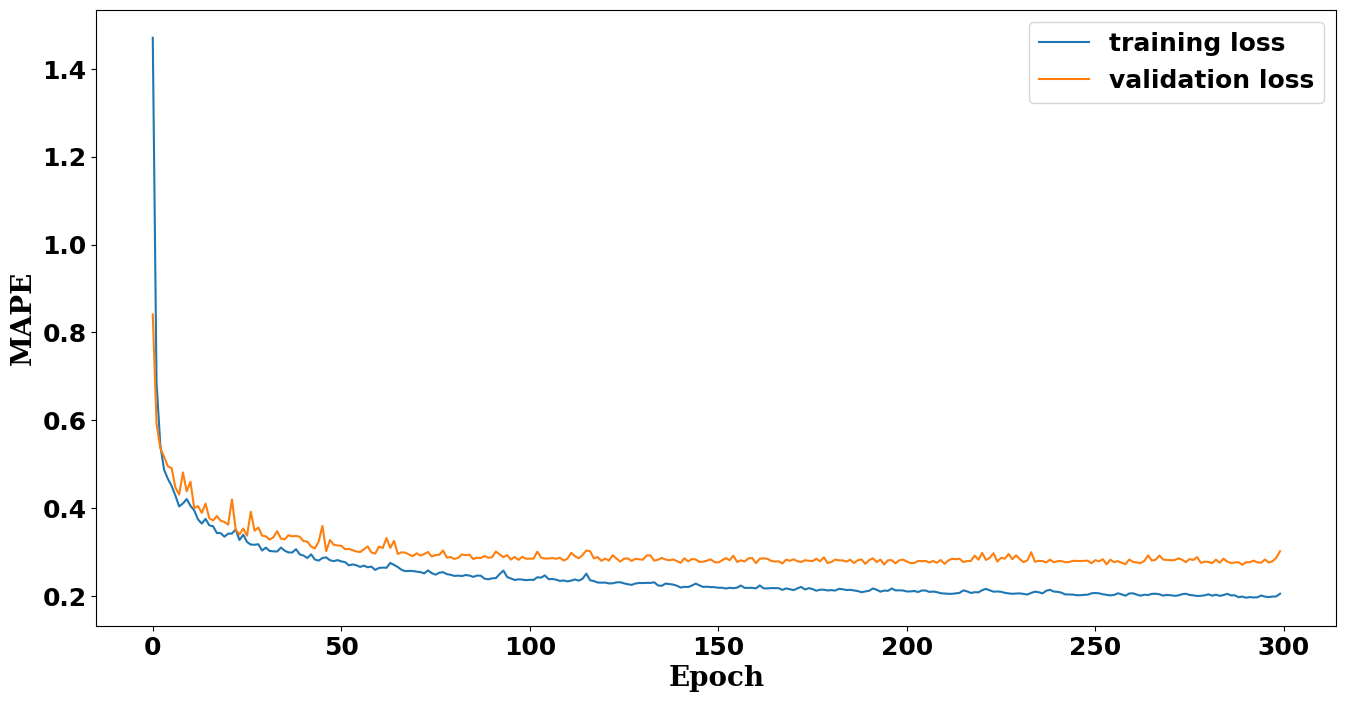

In [241]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }
plt.figure(figsize=(16, 8))
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('MAPE', fontdict=font)
plt.rcParams.update({'font.size': 18})

plt.legend()
plt.savefig(r'../Figure/training.png', pci = 300)

In [226]:
import matplotlib